# DAO delegate recommender

# Performing imports

In [1]:
import json
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
import requests
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/var/folders/lc/cksd2x851xx27g4yf5dxc4mh0000gn/T/ipykernel_50544/2870537951.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Setting snapshot graphql endpoint
transport = RequestsHTTPTransport(
    url="https://hub.snapshot.org/graphql",
    verify=True,
    retries=3,
    timeout = None,
    retry_status_forcelist = [429, 500, 502, 503, 504, 524]
)

client = Client(transport=transport, fetch_schema_from_transport=True,execute_timeout=600)

# Util functions

In [3]:
def fetch_votes(proposal_id):
    votes = []
    # first get the voting power of the top vote
    first_vote_query = gql(f"""
      {{
        votes(
          first: 1000,
          skip: 0,
          where: {{ 
              proposal: "{proposal_id}" 
          }},
          orderBy: "vp",
          orderDirection: desc,
          ) 
          {{
          voter
          vp
          choice
          created
          }}
      }}
      """)
     
    first_vote = client.execute(first_vote_query)
    if first_vote["votes"]:
      votes.extend(first_vote["votes"])
    else:
      return votes
    fetch_flag = True

    prev_vp = votes[-1]['vp']

    #flag for skipping first skip iter inside the for loop
    # since for the 1st instance we already fetch the inintial 1k votes
    skip_first_iter = True
    # repeat till all votes are fetched
    while fetch_flag:
      #extract voting power
      curr_vp = prev_vp
      print("VP = ",curr_vp)

      # stop if more than 50k votes collected (currently only executed for stargate)
      if len(votes) >= 50000:
        break
      
      # get first 5000 votes less than this vp
      for skip in range(0,6000,1000):
        if skip_first_iter:
          skip_first_iter = False
          continue
        votes_query = gql(f"""
        {{
          votes(
            first: 1000,
            skip: {skip},
            where: {{ 
                proposal: "{proposal_id}",
                vp_lt: {curr_vp}
            }},
            orderBy: "vp",
            orderDirection: desc,
            ) 
            {{
            voter
            vp
            choice
            created
            }}
        }}
        """)
        votes_subset = client.execute(votes_query)
        if votes_subset["votes"]:
          votes.extend(votes_subset["votes"])
          if votes[-1]['vp'] == prev_vp:
            print("Duplicate vp encountered")
            prev_vp = prev_vp - 1
          prev_vp = votes[-1]['vp']
        else:
          fetch_flag = False
          break
  

    return votes

In [4]:
def map_choice_value(row):
    raw_choice = row['choice']
    proposal_id = row['proposal_id']
    
    if isinstance(raw_choice, int):
        return raw_choice
    elif isinstance(raw_choice, dict):
        # For ranked or weighted votes: return top choice
        if raw_choice:
            top_choice = max(raw_choice, key=raw_choice.get)
            return top_choice
    elif isinstance(raw_choice, list):
        # For approval votes: return first approved choice
        if raw_choice:
            return raw_choice[0]
    else:
        return np.nan
        print(raw_choice)
        print(proposal_id)
        print(type(raw_choice))
        raise ValueError

In [5]:
# add new column containing voter participation and index for proposal engagement
def enhance_voter_proposal_matrix(df):
    if "voter_participation" in df.columns:
        df = df.drop('proposal_engagement')
        df = df.drop('voter_participation', axis=1)
    df['voter_participation'] = df.sum(axis=1)
    proposal_columns = [col for col in df.columns if col != 'voter_participation']
    proposal_engagement = df[proposal_columns].sum(axis=0)
    proposal_engagement.name = 'proposal_engagement'
    df = pd.concat([df, proposal_engagement.to_frame().T])
    return df

In [6]:
# function to build dataset which will be used for recommendation
def build_dataset(df,steps,threshold=40):
    for i in range(steps):
        df = enhance_voter_proposal_matrix(df)
        print(df['voter_participation'].describe())
        df = df.sort_values(by='voter_participation',ascending=False)
        starting_index = 0
        while True:
            if list(df['voter_participation'])[starting_index] >= df.shape[1]-1:
                starting_index += 1
            else:
                break
        top_voter = df.index[starting_index]
        prune_proposals = df.columns[df.loc[top_voter] == 0].tolist()
        if df.shape[1] - 1 - len(prune_proposals) < threshold:
            prune_proposals.pop()
        df = df.drop(prune_proposals,axis = 1)
        df = enhance_voter_proposal_matrix(df)
        if df.shape[1] - 1 <= threshold:
            break
        print(df.shape)
    df = df[df['voter_participation'] == max(list(df['voter_participation']))]
    return df

In [7]:
# for cosine similiarity
def encode_labels(df,choices,vectorized_labels_mapping):
    result = df.copy()
    vec_len = max([len(choices[prop]) for prop in choices.keys()])
    for col in df.columns:
        # result[col] = result[col].astype(object)
        flag = True
        for choice_label in choices[col]:
            if choice_label not in vectorized_labels_mapping.keys():
                flag = False
                break
        for index in df.index:
            if flag:
                result.at[index,col] = vectorized_labels_mapping[choices[col][result.loc[index,col] - 1]]
            else:
                # encoded_value = [0 for i in range(vec_len)]
                # encoded_value[df.loc[index,col] - 1] = 1
                encoded_value = np.nan
                result.at[index,col] = encoded_value
    result = result.dropna(axis=1)
    return result

In [8]:
def calculate_cosine_similarity(voter_vector, delegate_matrix):
    cos_sim_all = []
    voter_votes = voter_vector.values.tolist()[0]
    for delegate in delegate_matrix.index:
        delegate_votes = delegate_matrix.loc[delegate].values.tolist()
        cos_sim_all.append(np.dot(voter_votes,delegate_votes)/(np.linalg.norm(voter_votes) * np.linalg.norm(delegate_votes)))
    return cos_sim_all

In [18]:
def calculate_eskin_similarity(voter_vector,delegate_matrix,freq_dist):
    eskin_sim_all = []
    voter_vector = voter_vector.dropna(axis=1)
    for possible_delegate in delegate_matrix.index:
        eskin_sim_del = []
        for prop in voter_vector.columns:
            if pd.isna(delegate_matrix.loc[possible_delegate,prop]):
                eskin_sim_del.append(0)
            elif voter_vector[prop].item() == delegate_matrix.loc[possible_delegate,prop]:
                eskin_sim_del.append(1)
            else:
                eskin_sim_del.append(len(freq_dist[prop].keys())**2/(len(freq_dist[prop].keys())**2 + 2))
        eskin_sim_all.append(sum(eskin_sim_del)/len(eskin_sim_del))
    return eskin_sim_all

In [19]:
def calculate_iof_similarity(voter_vector, delegate_matrix,freq_dist):
    iof_sim_all = []
    voter_vector = voter_vector.dropna(axis=1)
    for possible_delegate in delegate_matrix.index:
        iof_sim_del = []
        for prop in voter_vector.columns:
            if pd.isna(delegate_matrix.loc[possible_delegate,prop]):
                iof_sim_del.append(0)
            elif voter_vector[prop].item() == delegate_matrix.loc[possible_delegate,prop]:
                iof_sim_del.append(1)
            else:
                iof_sim_del.append(1/(1+ (np.log(freq_dist[prop][voter_vector[prop].item()]) * np.log(freq_dist[prop][delegate_matrix.loc[possible_delegate,prop]]))))
        iof_sim_all.append(sum(iof_sim_del)/len(iof_sim_del))
    return iof_sim_all

In [20]:
def calculate_of_similarity(voter_vector, delegate_matrix,freq_dist):
    of_sim_all = []
    voter_vector = voter_vector.dropna(axis=1)
    N = len(delegate_matrix.index) + 1
    for possible_delegate in delegate_matrix.index:
        of_sim_del = []
        for prop in voter_vector.columns:
            if pd.isna(delegate_matrix.loc[possible_delegate,prop]):
                of_sim_del.append(0)
            elif voter_vector[prop].item() == delegate_matrix.loc[possible_delegate,prop]:
                of_sim_del.append(1)
            else:
                of_sim_del.append(1/(1+ (np.log(N/freq_dist[prop][voter_vector[prop].item()]) * np.log(N/freq_dist[prop][delegate_matrix.loc[possible_delegate,prop]]))))
        of_sim_all.append(sum(of_sim_del)/len(of_sim_del))
    return of_sim_all

In [21]:
def calculate_lin_similarity(voter_vector, delegate_matrix,freq_dist):
    lin_sim_all = []
    voter_vector = voter_vector.dropna(axis=1)
    for possible_delegate in delegate_matrix.index:
        lin_sim_del = []
        weight_part = 0
        for prop in voter_vector.columns:
            if pd.isna(delegate_matrix.loc[possible_delegate,prop]):
                lin_sim_del.append(0)
                weight_part += np.log(freq_dist[prop][voter_vector[prop].item()]/sum(freq_dist[prop].values()))
            elif voter_vector[prop].item() == delegate_matrix.loc[possible_delegate,prop]:
                lin_sim_del.append(2*np.log(freq_dist[prop][voter_vector[prop].item()]/sum(freq_dist[prop].values())))
                weight_part += np.log(freq_dist[prop][voter_vector[prop].item()]/sum(freq_dist[prop].values())) + np.log(freq_dist[prop][delegate_matrix.loc[possible_delegate,prop]]/sum(freq_dist[prop].values()))
            else:
                lin_sim_del.append(2*np.log((freq_dist[prop][voter_vector[prop].item()]/sum(freq_dist[prop].values())) + (freq_dist[prop][delegate_matrix.loc[possible_delegate,prop]]/sum(freq_dist[prop].values()))))
                weight_part += np.log(freq_dist[prop][voter_vector[prop].item()]/sum(freq_dist[prop].values())) + np.log(freq_dist[prop][delegate_matrix.loc[possible_delegate,prop]]/sum(freq_dist[prop].values()))

        lin_sim_all.append(sum(lin_sim_del)/weight_part)
    return lin_sim_all

In [22]:
def calculate_goodall1_similarity(voter_vector, delegate_matrix,freq_dist):
    goodall1_sim_all = []
    voter_vector = voter_vector.dropna(axis=1)
    for possible_delegate in delegate_matrix.index:
        goodall1_sim_del = []
        for prop in voter_vector.columns:
            if pd.isna(delegate_matrix.loc[possible_delegate,prop]):
                goodall1_sim_del.append(0)
            elif voter_vector[prop].item() == delegate_matrix.loc[possible_delegate,prop]:
                sum_part = 0
                for q in freq_dist[prop].keys():
                    if freq_dist[prop][q] <= freq_dist[prop][voter_vector[prop].item()]:
                        sum_part +=  freq_dist[prop][q]**2
                sum_part = sum_part/(sum(freq_dist[prop].values())**2)
                goodall1_sim_del.append(1-sum_part)
            else:
                goodall1_sim_del.append(0)

        goodall1_sim_all.append(sum(goodall1_sim_del)/len(goodall1_sim_del))
    return goodall1_sim_all

In [23]:
def calculate_goodall2_similarity(voter_vector, delegate_matrix,freq_dist):
    goodall2_sim_all = []
    voter_vector = voter_vector.dropna(axis=1)
    for possible_delegate in delegate_matrix.index:
        goodall2_sim_del = []
        for prop in voter_vector.columns:
            if pd.isna(delegate_matrix.loc[possible_delegate,prop]):
                goodall2_sim_del.append(0)
            elif voter_vector[prop].item() == delegate_matrix.loc[possible_delegate,prop]:
                sum_part = 0
                for q in freq_dist[prop].keys():
                    if freq_dist[prop][q] >= freq_dist[prop][voter_vector[prop].item()]:
                        sum_part +=  freq_dist[prop][q]**2
                sum_part = sum_part/(sum(freq_dist[prop].values())**2)
                goodall2_sim_del.append(1-sum_part)
            else:
                goodall2_sim_del.append(0)

        goodall2_sim_all.append(sum(goodall2_sim_del)/len(goodall2_sim_del))
    return goodall2_sim_all

In [24]:
def calculate_goodall3_similarity(voter_vector, delegate_matrix,freq_dist):
    goodall3_sim_all = []
    voter_vector = voter_vector.dropna(axis=1)
    for possible_delegate in delegate_matrix.index:
        goodall3_sim_del = []
        for prop in voter_vector.columns:
            if pd.isna(delegate_matrix.loc[possible_delegate,prop]):
                goodall3_sim_del.append(0)
            elif voter_vector[prop].item() == delegate_matrix.loc[possible_delegate,prop]:
                goodall3_sim_del.append(1-(freq_dist[prop][voter_vector[prop].item()]/sum(freq_dist[prop].values()))**2)
            else:
                goodall3_sim_del.append(0)

        goodall3_sim_all.append(sum(goodall3_sim_del)/len(goodall3_sim_del))
    return goodall3_sim_all

In [25]:
def calculate_goodall4_similarity(voter_vector, delegate_matrix,freq_dist):
    goodall4_sim_all = []
    voter_vector = voter_vector.dropna(axis=1)
    for possible_delegate in delegate_matrix.index:
        goodall4_sim_del = []
        for prop in voter_vector.columns:
            if pd.isna(delegate_matrix.loc[possible_delegate,prop]):
                goodall4_sim_del.append(0)
            elif voter_vector[prop].item() == delegate_matrix.loc[possible_delegate,prop]:
                goodall4_sim_del.append((freq_dist[prop][voter_vector[prop].item()]/sum(freq_dist[prop].values()))**2)
            else:
                goodall4_sim_del.append(0)

        goodall4_sim_all.append(sum(goodall4_sim_del)/len(goodall4_sim_del))
    return goodall4_sim_all

In [11]:
# defining function for calculating similiarity scores
def recommend_delegates(voter_id, delegate_matrix, metric,freq_dist,top_k = 14):

    if metric == 'cosine_similarity':
        # Compute cosine similarity
        voter_vector = delegate_matrix.loc[[voter_id]]
        delegate_matrix = delegate_matrix.drop(voter_id)
        similarities = calculate_cosine_similarity(voter_vector, delegate_matrix)
        
    elif metric == "overlap":
        #computing overlap similiarity
        voter_vector = delegate_matrix.loc[[voter_id]].values[0]
        delegate_matrix = delegate_matrix.drop(voter_id)
        delegate_matrix_list = delegate_matrix.values
        similarities = []
        for row in delegate_matrix_list:
            similarity = np.sum(voter_vector == row)/len(voter_vector)
            similarities.append(similarity)

    elif metric == "eskin":
        #computing similarity using eskin metric
        voter_vector = delegate_matrix.loc[[voter_id]]
        delegate_matrix = delegate_matrix.drop(voter_id)
        similarities = calculate_eskin_similarity(voter_vector, delegate_matrix,freq_dist)
    
    elif metric == "iof":
        #computing similarity using iof metric
        voter_vector = delegate_matrix.loc[[voter_id]]
        delegate_matrix = delegate_matrix.drop(voter_id)
        similarities = calculate_iof_similarity(voter_vector, delegate_matrix,freq_dist)
    
    elif metric == "of":
        #computing similarity using of metric
        voter_vector = delegate_matrix.loc[[voter_id]]
        delegate_matrix = delegate_matrix.drop(voter_id)
        similarities = calculate_of_similarity(voter_vector, delegate_matrix,freq_dist)

    elif metric == "lin":
        #computing similarity using lin metric
        voter_vector = delegate_matrix.loc[[voter_id]]
        delegate_matrix = delegate_matrix.drop(voter_id)
        similarities = calculate_lin_similarity(voter_vector, delegate_matrix,freq_dist)

    elif metric == "goodall1":
        #computing similarity using goodall1 metric
        voter_vector = delegate_matrix.loc[[voter_id]]
        delegate_matrix = delegate_matrix.drop(voter_id)
        similarities = calculate_goodall1_similarity(voter_vector, delegate_matrix,freq_dist)

    elif metric == "goodall2":
        #computing similarity using goodall2 metric
        voter_vector = delegate_matrix.loc[[voter_id]]
        delegate_matrix = delegate_matrix.drop(voter_id)
        similarities = calculate_goodall2_similarity(voter_vector, delegate_matrix,freq_dist)
    
    elif metric == "goodall3":
        #computing similarity using goodall2 metric
        voter_vector = delegate_matrix.loc[[voter_id]]
        delegate_matrix = delegate_matrix.drop(voter_id)
        similarities = calculate_goodall3_similarity(voter_vector, delegate_matrix,freq_dist)

    elif metric == "goodall4":
        #computing similarity using goodall2 metric
        voter_vector = delegate_matrix.loc[[voter_id]]
        delegate_matrix = delegate_matrix.drop(voter_id)
        similarities = calculate_goodall4_similarity(voter_vector, delegate_matrix,freq_dist)

    # Create DataFrame of results
    sim_df = pd.DataFrame({
        'delegate': delegate_matrix.index,
        'similarity': similarities
    }).sort_values(by='similarity', ascending=False)
    return sim_df.head(top_k)

In [12]:
def evaulate_accuracy(voter_id,delegate_id,eval_set):
    predicted = eval_set.loc[delegate_id].values
    ground_truth = eval_set.loc[voter_id].values
    result = np.equal(predicted,ground_truth)
    return sum(result)/len(result)

In [44]:
def create_boxplots(data_dict, title="Comparing different Similiarity Metrics on Validation set", ylabel="Accuracy"):
    if not data_dict:
        raise ValueError("The dictionary is empty. Please provide at least one dataset.")

    labels = list(data_dict.keys())
    data = list(data_dict.values())

    plt.figure(figsize=(12, 8))
    plt.boxplot(data, vert=True, patch_artist=True, labels=labels, showmeans=True, meanprops={"marker":"o","markerfacecolor":"red","markeredgecolor":"black","markersize":4})

    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()


In [47]:
def create_scatterplots(data_dict, title="Visualizing the recommendation accuracies", ylabel="Accuracy"):
    if not data_dict:
        raise ValueError("The dictionary is empty. Please provide at least one dataset.")

    plt.figure(figsize=(12, 8))

    for label, points in data_dict.items():
        if not points:
            continue
        x = range(len(points))
        y = points
        plt.scatter(x, y, label=label, s=60, alpha=0.7)

    plt.title(title)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


In [15]:
def filter_common_proposals(delegate_i_votes,delegate_j_votes):
    mask = delegate_i_votes.notna() & delegate_j_votes.notna()
    common_proposals = list(delegate_i_votes.index[mask])
    return common_proposals

In [16]:
def plot_similiarity_matrix(similarity_matrix_active_delegates,size=(8, 8)):
    matrix_values = similarity_matrix_active_delegates.apply(pd.to_numeric, errors='coerce').values
    fig, ax = plt.subplots(figsize=size)

    # Show the matrix as an image
    cax = ax.imshow(matrix_values, cmap='summer', interpolation='none')

    # Add colorbar
    fig.colorbar(cax)

    # Set title
    ax.set_title("Similiarity Matrix for Active Delegates")

    # Annotate each cell with the numeric value
    for i in range(matrix_values.shape[0]):
        for j in range(matrix_values.shape[1]):
            value = matrix_values[i, j]
            if not np.isnan(value):  # only annotate non-NaN
                ax.text(j, i, f"{value:.2f}", ha='center', va='center', color='black')

    # Optionally set axis ticks/labels
    ax.set_xticks(range(matrix_values.shape[1]))
    ax.set_yticks(range(matrix_values.shape[0]))
    ax.set_xticklabels(['...'+col[38:] for col in similarity_matrix_active_delegates.columns], rotation=90)
    ax.set_yticklabels(['...'+col[38:] for col in similarity_matrix_active_delegates.columns])

    plt.tight_layout()
    plt.show()

In [17]:
def get_freq_dist_vp_matrix(vp_matrix):
    freq_dict = {}
    for col in vp_matrix.columns:
        freq_dict[col] = vp_matrix[col].value_counts(dropna=True).to_dict()
    return freq_dict

In [38]:
def get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,metric,index):
    common_proposals = filter_common_proposals(voter_proposal_matrix.loc[recommended_delegates[metric][index][0]],voter_proposal_matrix.loc[recommended_delegates[metric][index][1]])
    same_votes = [prop for prop in common_proposals if voter_proposal_matrix.loc[recommended_delegates[metric][index][0]][prop] == voter_proposal_matrix.loc[recommended_delegates[metric][index][1]][prop]]
    return len(same_votes)/len(common_proposals)

# Uniswap DAO

## Getting proposal data

In [4]:
# getting proposals
query = gql("""
{
  proposals(
    first: 1000, 
    skip: 0, 
    where: { 
        space: "uniswapgovernance.eth"
    }, 
    orderBy: "created", 
    orderDirection: desc
) {
    id
    title
    start
    end
    state
    choices
    scores
    scores_total
    scores_updated
    author
    }
}
""")

#running the query
response = client.execute(query)
proposals = response['proposals']

# adding percentage scores to proposals
for i in range(len(proposals)):
    if proposals[i]['scores_total'] != 0:
        proposals[i]['percentage_scores'] = [proposals[i]['scores'][j]/sum(proposals[i]['scores']) for j in range(len(proposals[i]['scores']))]
    else:
        proposals[i]['percentage_scores'] = [0 for _ in range(len(proposals[i]['scores']))]

# converting to dataframe
proposals_df = pd.DataFrame(proposals)
proposals_df.head()

,id,title,start,end,state,choices,scores,scores_total,scores_updated,author,percentage_scores
0,0xea4a1505c96ce4ef5c1f88e6cc3ec89d63f3d88219aa...,Uniswap Delegate Reward Initiative - Cycle 4,1755091100,1755523100,active,"[For, Against, Abstain]","[19467279.189017583, 0.12, 1003106.5723114891]",2.047039e+07,1755426715,0xECC2a9240268BC7a26386ecB49E1Befca2706AC9,"[0.950997177184314, 5.862126913271887e-09, 0.0..."
1,0xc689d74757ccf1de09c3b8656dcd2f0d678972c9715a...,[TEMP CHECK] - Etherlink Co-incentives Proposal,1752192000,1752624000,closed,"[Approve $150k of Coincentives, Do Not Approve]","[7868931.523455135, 12324914.237951944]",2.019385e+07,1752624060,0x3FB19771947072629C8EEE7995a2eF23B72d4C8A,"[0.38966978437032684, 0.6103302156296732]"
2,0x537a301c4c94c1ec0b972bab558e2e36b1fa1111f0cb...,Uniswap Unichain - USDS and sUSDS Co-Incentive...,1750168677,1750600677,closed,"[For, Against, Abstain]","[19952014.082556143, 49292.083728599406, 35071...",2.350849e+07,1750600697,0xECC2a9240268BC7a26386ecB49E1Befca2706AC9,"[0.8487150770010451, 0.0020967775215152886, 0...."
3,0x5915e661808f896203ff5759e737e04861bf8fa09525...,Trial run a Technical Advisory Board (TAB),1749722400,1750154400,closed,"[For, Against, Abstain]","[4344.19961944543, 25132056.095661193, 1409328...",2.654573e+07,1750154419,0xc5547B4907418C2EC0C2A95beC6fEE8354657759,"[0.00016364966338953735, 0.946745748499228, 0...."
4,0xb9a79884fab779132907835d8c6360b781ed0a17c8a3...,Uniswap Accountability Committee S4 Elections,1747872000,1748304000,closed,"[Sov, Doo Wan Nam, Jordan Karstadt, Kevin Niel...","[3067743.121292669, 7217752.238456799, 7220475...",2.998898e+07,1748304024,0x3FB19771947072629C8EEE7995a2eF23B72d4C8A,"[0.10229566518752552, 0.24068011472895745, 0.2..."


In [5]:
# deleting rows with zero engagement
proposals_df = proposals_df[proposals_df['scores_total'] != 0]

In [7]:
# saving proposals as json
proposals_df.to_json('snapshot_proposals_uniswap.json', orient='records', indent=4)

In [8]:
# identify proposals with high disasgreement
for row in proposals_df.itertuples():
    if max(row.percentage_scores) < 0.9:
        index = np.argmax(row.percentage_scores)
        print(row.choices[index],round(row.percentage_scores[index],3))

Do Not Approve 0.61
For 0.849
Jordan Karstadt 0.241
Abstain 0.743
Abstain 0.565
For 0.686
For 0.559
For $375k 0.868
For 0.603
Against 0.554
For 0.826
Yes 0.737
Against 0.759
For 0.549
Alex Duckworth 0.261
Do not sponsor 0.658
For 0.85
Yes, activate additional tiers 0.882
Base 0.365
Against 0.711
$250k 0.886
$750k 0.684
Fund 300,000 UNI 0.335
For 0.771
karpatkey 0.257
Update Process 0.814
Incentivize $500k 0.811
 Launch Working Group 0.76
Reject amendment 0.599
$250k 0.579
$1m 0.561
$250k 0.401
$250k 0.711
$500k 0.698
$250k 0.614
$500k 0.584
$500k 0.584
$250k 0.602
$250k 0.54
Abdullah (Michigan Blockchain) 0.231
I was eligible 0.873
404 DAO 0.207
Invest in Ekubo Protocol 0.638
Honn - @honn24x 0.186
Combined Liquidity Incentives 0.489
Yes 0.845
USDC 0.547
No Fee 0.453
Doo Wan Nam (StableLab) 0.213
Wormhole 0.623
Yes 0.803
Yes  0.741
Yes - Deploy Uniswap v3 to Boba 0.781
individual creates an address 0.631
Yes, grant the license. 0.828
YES,  allocate 500k UNI to CHF 0.655
Leave it unchang

In [9]:
#defining contreversial proposals
mask = proposals_df['percentage_scores'].apply(lambda scores: max(scores) < 0.7)
contreversial_proposals = proposals_df[mask]
print(contreversial_proposals['percentage_scores'].shape)

(37,)


## Getting voter data

In [10]:
# getting votes for each proposal
voting_data = []
for proposal in proposals:
    votes_for_proposal = fetch_votes(proposal['id'])
    for vote in votes_for_proposal:
        vote['proposal_id'] = proposal['id']
        voting_data.append(vote)
voting_df = pd.DataFrame(voting_data)

In [11]:
# saving voter data
voting_df.to_json('all_votes_snapshot_uniswap.json', orient='records', indent=4) 

In [12]:
# exploring types of proposals
proposals_categories = {'approval': 0,"weighted": 0, "single_choice":0}
prev_prop = None
for row in voting_df.itertuples():
    curr_prop = row.proposal_id
    if curr_prop != prev_prop:
        prev_prop = curr_prop
        if curr_prop in list(contreversial_proposals['id']):
            if isinstance(row.choice,int):
                proposals_categories['single_choice'] += 1
            elif isinstance(row.choice,dict):
                proposals_categories['weighted'] += 1
            elif isinstance(row.choice, list):
                proposals_categories['approval'] += 1

            else:
                raise ValueError
    else:
        continue

print(proposals_categories)

{'approval': 5, 'weighted': 6, 'single_choice': 26}


## Getting participation stats of delegates

In [13]:
# setting participation value
voting_df['participated'] = 1

# creating voter proposal matrix
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='participated',
    fill_value=0
)

In [14]:
voter_proposal_matrix.shape

(30309, 178)

In [15]:
#getting participation rate
participation_rate = voter_proposal_matrix.sum(axis=1) / voter_proposal_matrix.shape[1]

In [21]:
active_delegates = voter_proposal_matrix[participation_rate >= 0.5]
active_delegates.shape

(53, 178)

## Creating optimal training dataset

In [ ]:
# getting votes for controversial proposal as basis for training set
voting_df = voting_df[voting_df.proposal_id.isin(contreversial_proposals.id)]

In [44]:
# setting participation value
voting_df['participated'] = 1

# creating voter proposal matrix
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='participated',
    fill_value=0
)

voter_proposal_matrix.shape

(17338, 37)

In [45]:
recommendation_dataset = build_dataset(voter_proposal_matrix,20,25)
print(recommendation_dataset.shape)
recommendation_dataset

count    17338.000000
mean         3.232034
std          3.760613
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         33.000000
Name: voter_participation, dtype: float64
(17339, 34)
count    17338.000000
mean         3.147883
std          3.771941
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         33.000000
Name: voter_participation, dtype: float64
(17339, 33)
count    17338.000000
mean         3.137617
std          3.738539
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         32.000000
Name: voter_participation, dtype: float64
(17339, 32)
count    17338.000000
mean         3.106933
std          3.653929
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         31.000000
Name: voter_participation, dtype: float64
(17339, 31)
count    17338.000000
mean         3.091245
std          3.613993
min          0

proposal_id,0x0ced7d4ed383fe37e3905c187fe668382a32090b994cffc257ecb8a035542d64,0x1f94902b026cf7722ddc9761621d075f22e56b833e91d795374b3a7065d2de0e,0x1fcec1597c5fdd6d53aed8d4491a07d41c02fd3e20fcc55936be807f189fb6c2,0x24d918618eb4fadb8e9d17f5da5a57d74a1d51470d4c9125b1f42d8c268d0f52,0x3d8d2f44677c19f49a5bbe4466e4b50068b1a704861801d95384c898b1cbde54,0x4b362044000714197ab43d5f2155977976dcc7cf1cb28d945e1168ae7ac61f90,0x51ab2ced6ddc652531d0a4f719aa43b62beba11b5d97773750e682b6e8aed5a0,0x58f16ed9e140551bb80d265ea9b958e96c542a7d7afc081610f72506a4f7cb05,0x64aca6822b43a7a4eff64613e16091d0cd9d50483cea78e0d959875dbebf6b69,0x675c9697cc6c8d1cab27e1cffab3fdc7740b3e978eb37d8b6dcce76d1726670f,...,0xb471984c1daef6742be4d4983339af7ad140c3dfcfc883508fd975f5abe0e8c9,0xb9a79884fab779132907835d8c6360b781ed0a17c8a33ac41594a27f6c366ce4,0xbd612a383a061c6371a95a00d02b253e42fea2335ea596a6dbca4fe4a27f710f,0xd457a6cdb9e20002d74c30818b7b35a694af04c627cc7bf6d855d4ece9409333,0xde949c58934541240b76597b9461f2bc7987da23835459921737967d6a38d5da,0xdf2d95ccfadebf141847b90e058f8fafb4f76d8ca2ec2a7351d93353187df560,0xdfdb91486c2f8d5d63114da161cc2fe6e7f9bd5adbfca90eb4cd86616136f81f,0xe2fa09de5e3ff44b57c40b2fe049f43e47cb8e3b192bd1dc52ef3b42d8b5c363,0xf551e90e767fccfac8593a3233b6e2f2e2a3a773e1e9f9abbb9a4d2678f101f8,voter_participation
0xCA99d35880CE5F6c62EbdC82bdAa02A8EA96101F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0
0xE0E216283eef00895b6ABAa73848448596B85724,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0
0xAefCDA6b2cF4EcC7A7E07099C79a729a7c8b91f7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0
0xD42104BE307A17e7897F0e14720bfdcC7F0D993c,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0
0x1f8231Ef50E99D361B5252A24EC2eC44285367e1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0
0x571C9B09aFe7248421563e7958459413B3af98fc,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0
0x13BDaE8c5F0fC40231F0E6A4ad70196F59138548,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0
0x88F659b4B6D5614B991c6404b34f821e10390eC0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0
0xCEF28ce7884Ae973990fb826C1986afaa9319B9A,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0
0x4d9Ba778B7f121e58E5d3BB6aef514e035A7c7F5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0


In [46]:
recommendation_dataset = recommendation_dataset.drop('voter_participation', axis = 1)

In [ ]:
proposal_choices_dict = contreversial_proposals.set_index('id')['choices'].to_dict()
voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice_value',
    aggfunc='first',
    fill_value="NaN"
)
recommendation_dataset_matrix = voter_proposal_matrix.loc[voter_proposal_matrix.index.isin(recommendation_dataset.index)]
recommendation_dataset_matrix = recommendation_dataset_matrix.drop([col for col in recommendation_dataset_matrix.columns if col not in recommendation_dataset.columns], axis = 1)
recommendation_dataset_matrix[recommendation_dataset_matrix.columns] = recommendation_dataset_matrix[recommendation_dataset_matrix.columns].astype(int)
recommendation_dataset_matrix

proposal_id,0x0ced7d4ed383fe37e3905c187fe668382a32090b994cffc257ecb8a035542d64,0x1f94902b026cf7722ddc9761621d075f22e56b833e91d795374b3a7065d2de0e,0x1fcec1597c5fdd6d53aed8d4491a07d41c02fd3e20fcc55936be807f189fb6c2,0x24d918618eb4fadb8e9d17f5da5a57d74a1d51470d4c9125b1f42d8c268d0f52,0x3d8d2f44677c19f49a5bbe4466e4b50068b1a704861801d95384c898b1cbde54,0x4b362044000714197ab43d5f2155977976dcc7cf1cb28d945e1168ae7ac61f90,0x51ab2ced6ddc652531d0a4f719aa43b62beba11b5d97773750e682b6e8aed5a0,0x58f16ed9e140551bb80d265ea9b958e96c542a7d7afc081610f72506a4f7cb05,0x64aca6822b43a7a4eff64613e16091d0cd9d50483cea78e0d959875dbebf6b69,0x675c9697cc6c8d1cab27e1cffab3fdc7740b3e978eb37d8b6dcce76d1726670f,...,0x86ded24b11c4714e0f4f2b6e4ca489f60dc33e6f2f4ababa5575bf5ab973a005,0xb471984c1daef6742be4d4983339af7ad140c3dfcfc883508fd975f5abe0e8c9,0xb9a79884fab779132907835d8c6360b781ed0a17c8a33ac41594a27f6c366ce4,0xbd612a383a061c6371a95a00d02b253e42fea2335ea596a6dbca4fe4a27f710f,0xd457a6cdb9e20002d74c30818b7b35a694af04c627cc7bf6d855d4ece9409333,0xde949c58934541240b76597b9461f2bc7987da23835459921737967d6a38d5da,0xdf2d95ccfadebf141847b90e058f8fafb4f76d8ca2ec2a7351d93353187df560,0xdfdb91486c2f8d5d63114da161cc2fe6e7f9bd5adbfca90eb4cd86616136f81f,0xe2fa09de5e3ff44b57c40b2fe049f43e47cb8e3b192bd1dc52ef3b42d8b5c363,0xf551e90e767fccfac8593a3233b6e2f2e2a3a773e1e9f9abbb9a4d2678f101f8
voter,,,,,,,,,,,,,,,,,,,,,
0x019Ed608dD806b80193942F2A960e7AC8aBb2EE3,1,2,1,2,1,2,2,1,1,1,...,4,2,1,1,1,1,1,1,1,2
0x13BDaE8c5F0fC40231F0E6A4ad70196F59138548,1,4,5,2,1,2,3,1,1,3,...,1,1,5,1,1,2,1,2,1,2
0x1f8231Ef50E99D361B5252A24EC2eC44285367e1,1,1,1,4,1,2,1,1,1,1,...,1,2,1,2,4,1,1,4,1,1
0x4d9Ba778B7f121e58E5d3BB6aef514e035A7c7F5,1,3,1,2,1,2,2,1,1,1,...,1,2,1,1,1,1,7,1,4,1
0x571C9B09aFe7248421563e7958459413B3af98fc,1,1,1,1,1,2,1,1,1,1,...,1,2,1,1,1,1,1,1,1,3
0x7e21749ab7fc3bC1A77fA5814cDFB651CA9E241c,1,3,1,2,1,1,2,1,1,1,...,1,1,1,1,1,1,1,1,4,2
0x88F659b4B6D5614B991c6404b34f821e10390eC0,1,3,1,2,1,2,1,1,1,1,...,1,2,1,1,1,1,1,1,5,1
0xAefCDA6b2cF4EcC7A7E07099C79a729a7c8b91f7,1,3,1,2,1,2,1,1,1,1,...,1,2,7,1,1,2,6,1,1,1
0xCA99d35880CE5F6c62EbdC82bdAa02A8EA96101F,1,3,1,2,1,2,1,1,1,1,...,1,2,1,1,1,1,7,1,1,1


In [48]:
# saving recommendation_dataset_matrix into json
recommendation_dataset_matrix.to_json('recommendation_dataset_matrix_uniswap.json', orient='table', indent=4)

In [49]:
# evaluating behavior for active delegates in these proposals
proposals = list(recommendation_dataset_matrix.columns)
for prop in proposals:
    prop_voting_data = list(recommendation_dataset_matrix[prop])
    voter_behaviour = {}
    for vote in prop_voting_data:
        if vote in voter_behaviour.keys():
            voter_behaviour[vote] += 1
        else:
            voter_behaviour[vote] = 1
    stats = round(max(voter_behaviour.values())/sum(voter_behaviour.values()),2)
    print('agreement rate for prop: ', prop, ' = ',stats)
    # print(voter_behaviour)

agreement rate for prop:  0x0ced7d4ed383fe37e3905c187fe668382a32090b994cffc257ecb8a035542d64  =  0.92
agreement rate for prop:  0x1f94902b026cf7722ddc9761621d075f22e56b833e91d795374b3a7065d2de0e  =  0.62
agreement rate for prop:  0x1fcec1597c5fdd6d53aed8d4491a07d41c02fd3e20fcc55936be807f189fb6c2  =  0.77
agreement rate for prop:  0x24d918618eb4fadb8e9d17f5da5a57d74a1d51470d4c9125b1f42d8c268d0f52  =  0.77
agreement rate for prop:  0x3d8d2f44677c19f49a5bbe4466e4b50068b1a704861801d95384c898b1cbde54  =  1.0
agreement rate for prop:  0x4b362044000714197ab43d5f2155977976dcc7cf1cb28d945e1168ae7ac61f90  =  0.92
agreement rate for prop:  0x51ab2ced6ddc652531d0a4f719aa43b62beba11b5d97773750e682b6e8aed5a0  =  0.46
agreement rate for prop:  0x58f16ed9e140551bb80d265ea9b958e96c542a7d7afc081610f72506a4f7cb05  =  1.0
agreement rate for prop:  0x64aca6822b43a7a4eff64613e16091d0cd9d50483cea78e0d959875dbebf6b69  =  1.0
agreement rate for prop:  0x675c9697cc6c8d1cab27e1cffab3fdc7740b3e978eb37d8b6dcce76d1

## Creating training and validation sets 

In [26]:
recommendation_dataset = pd.read_json('recommendation_dataset_matrix_uniswap.json', orient='table')

In [27]:
# calcualting agreement to filter training and validation sets
training_set = recommendation_dataset

In [28]:
choices = {}
for prop in training_set.columns:
    # getting choices
    query = gql(f"""
    {{
    proposals(
        first: 1000, 
        skip: 0, 
        where: {{ 
            space: "uniswapgovernance.eth",
            id: "{prop}"
        }}, 
        orderBy: "created", 
        orderDirection: desc
    ) {{
        choices
        }}
    }}
    """)
    #running the query
    response = client.execute(query)
    choices[prop] = response['proposals'][0]['choices']
print(choices)

{'0x0ced7d4ed383fe37e3905c187fe668382a32090b994cffc257ecb8a035542d64': ['_JoJo', 'Jayyu23', 'Alex Duckworth', 'Alicecorsini', 'Doo', 'Marian', 'Takeshi', 'Kevin Nielson', 'Sov', 'Drllau'], '0x1f94902b026cf7722ddc9761621d075f22e56b833e91d795374b3a7065d2de0e': ['$250k', '$500k', '$750k', '$1m', 'Abstain', 'Against'], '0x1fcec1597c5fdd6d53aed8d4491a07d41c02fd3e20fcc55936be807f189fb6c2': ['$250k', '$500k', '$750k', '$1m', 'Abstain', 'Against'], '0x24d918618eb4fadb8e9d17f5da5a57d74a1d51470d4c9125b1f42d8c268d0f52': ['$250k', '$500k', '$750k', '$1m', 'Abstain', 'Against'], '0x3d8d2f44677c19f49a5bbe4466e4b50068b1a704861801d95384c898b1cbde54': ['Accept amendment', 'Reject amendment'], '0x4b362044000714197ab43d5f2155977976dcc7cf1cb28d945e1168ae7ac61f90': ['DAI', 'USDC', 'ETH', 'UNI'], '0x51ab2ced6ddc652531d0a4f719aa43b62beba11b5d97773750e682b6e8aed5a0': ['Sponsor Unicorn Partner (250k)', 'Sponsor Panda Partner (100k)', 'Do not sponsor', 'Abstain'], '0x58f16ed9e140551bb80d265ea9b958e96c542a7d7afc

In [30]:
voting_df = pd.read_json("all_votes_snapshot_uniswap.json",orient="records").set_index("voter")
voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)
vp_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice_value',
    aggfunc='first',
    fill_value=np.nan
)
freq_dist = get_freq_dist_vp_matrix(training_set)

/var/folders/lc/cksd2x851xx27g4yf5dxc4mh0000gn/T/ipykernel_50544/1994615656.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vp_matrix = voting_df.pivot_table(


In [31]:
# building a new dict for vectorizing labels
vectorized_labels_mapping = {
    '$250k' : 1,
    '$500k' : 2,
    '$750k' : 3,
    '$1m' : 4,
    'Abstain': 0,
    'Against': -1,
    'Do not proceed with the proposal': -1,
    'Accept amendment' : 1,
    'Reject amendment' : -1,
    'For' : 1
}

In [32]:
transformed_df = encode_labels(training_set,choices,vectorized_labels_mapping)

In [33]:
# performing the recommendation
recommended_delegates = {'cosine_similarity':[], 'overlap': [],'eskin': [],'iof':[], 'of': [], 'lin': [], 'goodall1': [], 'goodall2': [], 'goodall3': [], 'goodall4': []}
for voter_id in training_set.index:
    # storing results of cosine similiarity
    top_delegate = recommend_delegates(voter_id,transformed_df,"cosine_similarity",freq_dist).iloc[0,0]
    recommended_delegates['cosine_similarity'].append((voter_id,top_delegate))
    #storing overlap distance
    top_delegate = recommend_delegates(voter_id,training_set,"overlap",freq_dist).iloc[0,0]
    recommended_delegates['overlap'].append((voter_id,top_delegate))
    #storing results for eskin
    top_delegate = recommend_delegates(voter_id,training_set,"eskin",freq_dist).iloc[0,0]
    recommended_delegates['eskin'].append((voter_id,top_delegate))
    #storing results for iof
    top_delegate = recommend_delegates(voter_id,training_set,"iof",freq_dist).iloc[0,0]
    recommended_delegates['iof'].append((voter_id,top_delegate))
    #storing results for of
    top_delegate = recommend_delegates(voter_id,training_set,"of",freq_dist).iloc[0,0]
    recommended_delegates['of'].append((voter_id,top_delegate))
    #storing results for lin
    top_delegate = recommend_delegates(voter_id,training_set,"lin",freq_dist).iloc[0,0]
    recommended_delegates['lin'].append((voter_id,top_delegate))
    #storing results for goodall1
    top_delegate = recommend_delegates(voter_id,training_set,"goodall1",freq_dist).iloc[0,0]
    recommended_delegates['goodall1'].append((voter_id,top_delegate))
    #storing results for goodall2
    top_delegate = recommend_delegates(voter_id,training_set,"goodall2",freq_dist).iloc[0,0]
    recommended_delegates['goodall2'].append((voter_id,top_delegate))
    #storing results for goodall3
    top_delegate = recommend_delegates(voter_id,training_set,"goodall3",freq_dist).iloc[0,0]
    recommended_delegates['goodall3'].append((voter_id,top_delegate))
    #storing results for goodall4
    top_delegate = recommend_delegates(voter_id,training_set,"goodall4",freq_dist).iloc[0,0]
    recommended_delegates['goodall4'].append((voter_id,top_delegate))


## Evaluating on non controversial proposals

In [34]:
# getting voting data for non controversial proposals
voting_df = pd.read_json('all_votes_snapshot_uniswap.json', orient='records')
voting_df = voting_df[~voting_df.proposal_id.isin(recommendation_dataset.columns)]
voting_df = voting_df[voting_df.voter.isin(recommendation_dataset.index)]

In [35]:
proposals = pd.read_json('snapshot_proposals_uniswap.json', orient='records')

In [36]:
proposal_choices_dict = proposals.set_index('id')['choices'].to_dict()
voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice_value',
    aggfunc='first',
    fill_value=np.nan
)

/var/folders/lc/cksd2x851xx27g4yf5dxc4mh0000gn/T/ipykernel_50544/4098446546.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  voter_proposal_matrix = voting_df.pivot_table(


In [37]:
voter_proposal_matrix

proposal_id,0x0020f65948996b728ebce6c8a6ce5148d936a0151dd48f2e43bbcf34330cf542,0x011e2297060cd82da866185392a54f506118cbece76c88c1e2a02fac4cd75893,0x04af1fcb7538cf5458c5c17baa50fe410952d48e98d451a6ca5f7b94fea87ee8,0x0c7b3acc56ad1d276cd4c9338e2ef8ca9e15e8ab3e3a22d395fd34398bda40af,0x0f8a85d90759acf3a6fdc018e20b991f3562847122a8142c4e166c71d0e755e3,0x14aa7becb547ccb8fdcfc69054bda1557a90f1ebe3ac45569f049b5e29e98d76,0x15031b68121659b87a3f5e33c303cd517bcbc003d3f60fc82f1299620475bcab,0x178ac7eb76480798dbb656cbae4a405c3adaad48f9af4ae4c528b2cbd0f6af39,0x1b31cc6ab6b8ceb3ea3ada7684d08debc20d8a3b29fd94363223892264ab937d,0x255d43357e17858f8664ffaaeaf7660bfd8be5f7dabc414edf98d3fadb3f1588,...,0xfe8cb4e08138df2f0d136480e85edadf22679cca73b68f3f376d12f322dd2565,0xff05f8e61540a8ad3ca98b9a65a4b135d7834bdb0cf286a1346dcd6fcda85df0,QmP3H8WGLiWTP2WumKyrq8yA1xz1XbwkT8brdGYePuAcES,QmRKyYeGRFAhBnsqRXHVVwpmmVWxWdybUTVqLM7c52EonT,QmScNLeajiF2hQh1z9DYqTFKGgrRhHwrHisV4ynmDEQwxH,QmWbgzHJ8nK2TDaj6LF6BxAMPahy97dMmbbU5kRBw1QkXt,QmWhemJom3RZdH91rBPmjvAFZEr9HdFRSFVNtAae6kgbyE,QmcVpxCSkL8rPmZgow8uL2GbdPZtUKS3huY9aSExKNfEK6,Qmcs5pAv7eGBzqGn1G8LJGusME3t7bTCSfZjdyWmw88LaM,Qmeza7LnzTLAGhHeA2psNtf1ua4kgm2Q1NHAMPeVzs5C2i
voter,,,,,,,,,,,,,,,,,,,,,
0x019Ed608dD806b80193942F2A960e7AC8aBb2EE3,NaN,1.0,1.0,1.0,NaN,1,NaN,1,1,NaN,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0x13BDaE8c5F0fC40231F0E6A4ad70196F59138548,5.0,1.0,1.0,1.0,1.0,1,1.0,1,2,NaN,...,1,1,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0
0x1f8231Ef50E99D361B5252A24EC2eC44285367e1,1.0,1.0,1.0,1.0,NaN,1,NaN,2,1,NaN,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0x4d9Ba778B7f121e58E5d3BB6aef514e035A7c7F5,2.0,1.0,1.0,1.0,1.0,1,1.0,1,2,NaN,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0x571C9B09aFe7248421563e7958459413B3af98fc,1.0,1.0,1.0,1.0,NaN,1,NaN,1,1,NaN,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0x7e21749ab7fc3bC1A77fA5814cDFB651CA9E241c,2.0,1.0,1.0,1.0,1.0,1,1.0,1,2,NaN,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0x88F659b4B6D5614B991c6404b34f821e10390eC0,2.0,1.0,1.0,1.0,1.0,1,1.0,1,1,3.0,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0xAefCDA6b2cF4EcC7A7E07099C79a729a7c8b91f7,2.0,1.0,NaN,NaN,1.0,1,1.0,1,1,NaN,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0xCA99d35880CE5F6c62EbdC82bdAa02A8EA96101F,2.0,1.0,1.0,1.0,1.0,1,1.0,1,1,NaN,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# performing evaluation
non_cont_eval_result = {'cosine_similarity':[], 'overlap': [], 'eskin': [],'iof':[], 'of': [], 'lin': [], 'goodall1': [], 'goodall2': [], 'goodall3': [], 'goodall4': [], "random":[]}
# get number of evaluation points
eval_points = len(recommended_delegates['cosine_similarity'])
for i in range(eval_points):
    # evaluating cosine similiarity
    non_cont_eval_result['cosine_similarity'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'cosine_similarity',i))

    # evaluating overlap similiarity
    non_cont_eval_result['overlap'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'overlap',i))

    # evaluating eskin similiarity
    non_cont_eval_result['eskin'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'eskin',i))

    # evaluating iof similiarity
    non_cont_eval_result['iof'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'iof',i))

    # evaluating of similiarity
    non_cont_eval_result['of'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'of',i))

    # evaluating lin similiarity
    non_cont_eval_result['lin'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'lin',i))

    # evaluating goodall1 similiarity
    non_cont_eval_result['goodall1'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall1',i))

    # evaluating goodall2 similiarity
    non_cont_eval_result['goodall2'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall2',i))

    # evaluating goodall3 similiarity
    non_cont_eval_result['goodall3'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall3',i))

    # evaluating goodall4 similiarity
    non_cont_eval_result['goodall4'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall4',i))

    # evaluating random delegation (baseline)
    baseline_for_voter = []
    for possible_delegate in voter_proposal_matrix.drop(recommended_delegates['overlap'][i][0]).index:
        common_proposals = filter_common_proposals(voter_proposal_matrix.loc[recommended_delegates['overlap'][i][0]],voter_proposal_matrix.loc[possible_delegate])
        if common_proposals:
            same_votes = [prop for prop in common_proposals if voter_proposal_matrix.loc[recommended_delegates['overlap'][i][0]][prop] == voter_proposal_matrix.loc[possible_delegate][prop]]
            baseline_for_voter.append(len(same_votes)/len(common_proposals))
    non_cont_eval_result['random'].append(sum(baseline_for_voter)/len(baseline_for_voter))


In [40]:
# Printing out stats
print("Cosine Similarity")
print(pd.Series(non_cont_eval_result['cosine_similarity']).describe())
print()
print("Overlap Similarity")
print(pd.Series(non_cont_eval_result['overlap']).describe())
print()
print("Eskin")
print(pd.Series(non_cont_eval_result['eskin']).describe())
print()
print("iof")
print(pd.Series(non_cont_eval_result['iof']).describe())
print()
print("of")
print(pd.Series(non_cont_eval_result['of']).describe())
print()
print("lin")
print(pd.Series(non_cont_eval_result['lin']).describe())
print()
print("goodall1")
print(pd.Series(non_cont_eval_result['goodall1']).describe())
print()
print("goodall2")
print(pd.Series(non_cont_eval_result['goodall2']).describe())
print()
print("goodall3")
print(pd.Series(non_cont_eval_result['goodall3']).describe())
print()
print("goodall4")
print(pd.Series(non_cont_eval_result['goodall4']).describe())
print()
print("Random Delegation (Baseline)")
print(pd.Series(non_cont_eval_result['random']).describe())

Cosine Similarity
count    13.000000
mean      0.898987
std       0.036096
min       0.849057
25%       0.878788
50%       0.888889
75%       0.942029
max       0.958333
dtype: float64

Overlap Similarity
count    13.000000
mean      0.922356
std       0.038040
min       0.870968
25%       0.882353
50%       0.920635
75%       0.958333
max       0.971429
dtype: float64

Eskin
count    13.000000
mean      0.920452
std       0.039001
min       0.870968
25%       0.884615
50%       0.920635
75%       0.958333
max       0.971429
dtype: float64

iof
count    13.000000
mean      0.922502
std       0.038343
min       0.870968
25%       0.884615
50%       0.914894
75%       0.958333
max       0.971429
dtype: float64

of
count    13.000000
mean      0.923838
std       0.037606
min       0.865385
25%       0.882353
50%       0.920635
75%       0.958333
max       0.971429
dtype: float64

lin
count    13.000000
mean      0.916135
std       0.045783
min       0.843137
25%       0.882353
50%       0

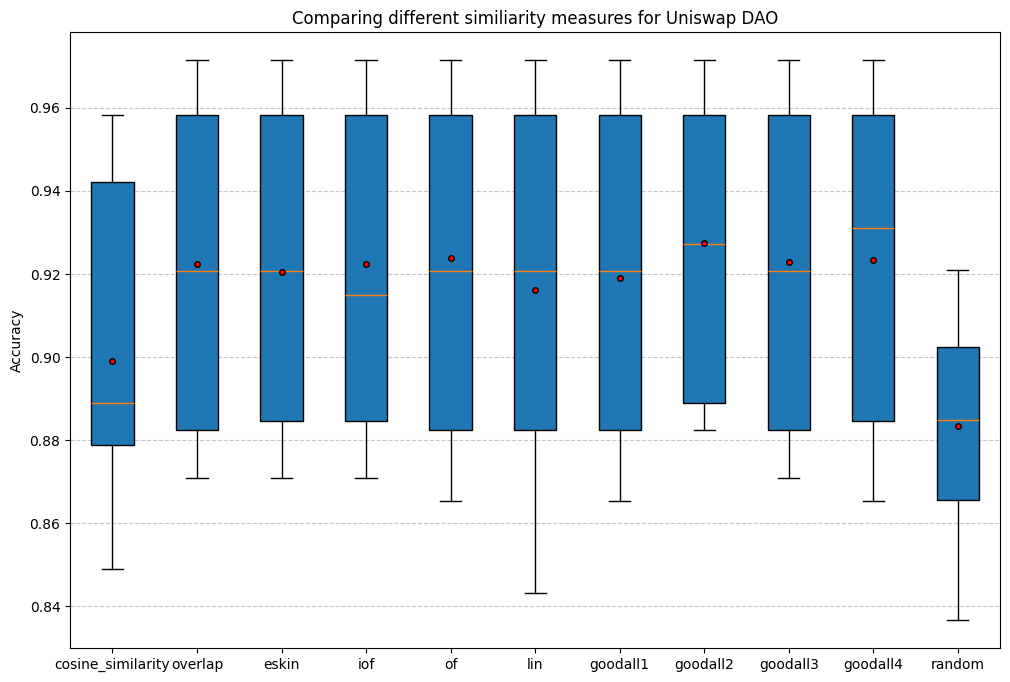

In [45]:
create_boxplots(non_cont_eval_result,"Comparing different similiarity measures for Uniswap DAO")

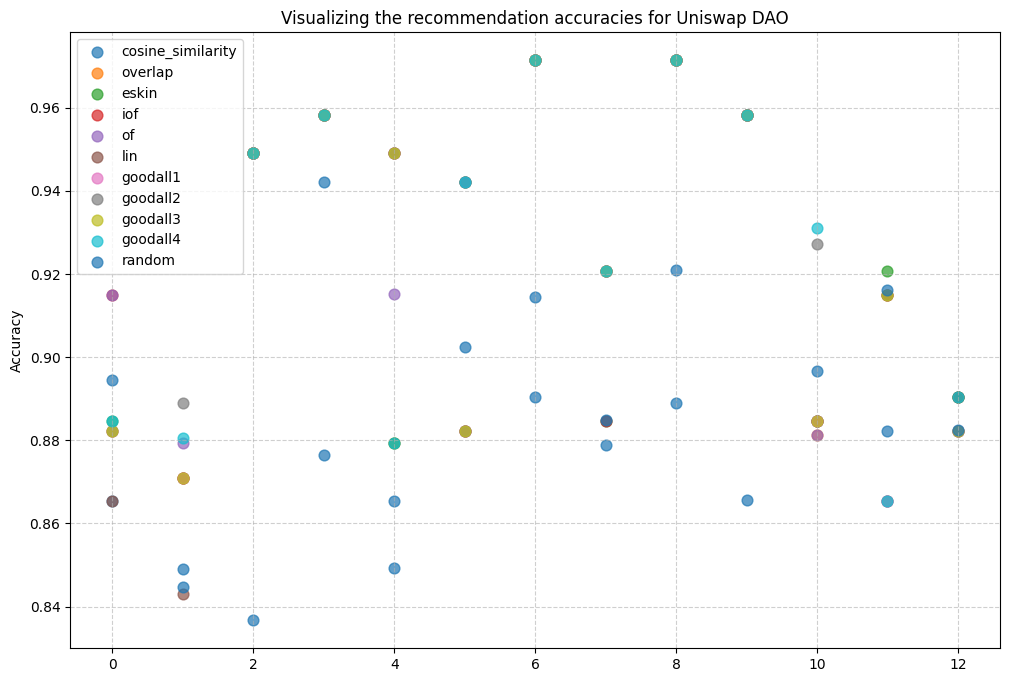

In [48]:
create_scatterplots(non_cont_eval_result,"Visualizing the recommendation accuracies for Uniswap DAO")

## Evaluating similiarity between active delegate

In [150]:
voting_df = pd.read_json('all_votes_snapshot_uniswap.json', orient='records').set_index('voter')
# setting participation value
voting_df['participated'] = 1

# creating voter proposal matrix
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='participated',
    fill_value=0
)
participation_rate = voter_proposal_matrix.sum(axis=1) / voter_proposal_matrix.shape[1]

In [151]:
active_delegates = voter_proposal_matrix[participation_rate >= 0.7]

In [152]:
proposals_df = pd.read_json('snapshot_proposals_uniswap.json', orient='records')

In [153]:
voting_df['choice'] = voting_df.apply(map_choice_value, axis=1)
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice',
    aggfunc='first'
)

In [154]:
voter_proposal_matrix = voter_proposal_matrix.loc[voter_proposal_matrix.index.isin(active_delegates.index)]

In [155]:
similarity_matrix_active_delegates = pd.DataFrame(np.nan, index=voter_proposal_matrix.index, columns=voter_proposal_matrix.index)

In [ ]:
for delegate_i in voter_proposal_matrix.index:
    for delegate_j in voter_proposal_matrix.index:
        common_proposals = filter_common_proposals(voter_proposal_matrix.loc[delegate_i],voter_proposal_matrix.loc[delegate_j])
        same_votes = [prop for prop in common_proposals if voter_proposal_matrix.loc[delegate_i][prop] == voter_proposal_matrix.loc[delegate_j][prop]]
        similarity_matrix_active_delegates.loc[delegate_i,delegate_j] = len(same_votes)/len(common_proposals)

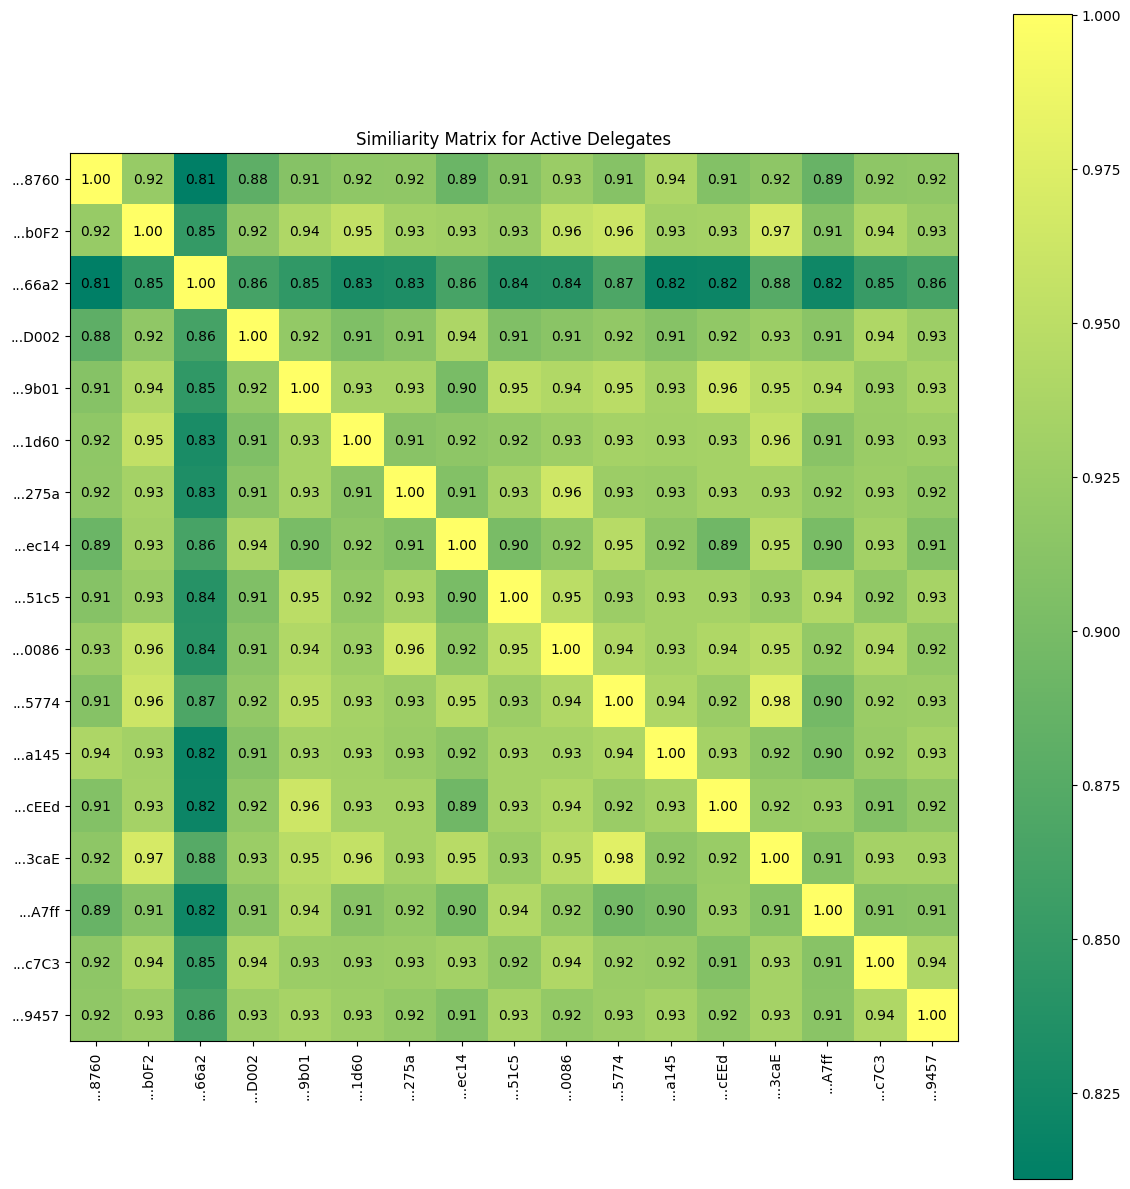

In [162]:
plot_similiarity_matrix(similarity_matrix_active_delegates,(12,12))

# Arbitrum DAO

## Fetching proposal data

In [163]:
# getting proposals
query = gql("""
{
  proposals(
    first: 1000, 
    skip: 0, 
    where: { 
        space: "arbitrumfoundation.eth",
        state: "closed"
    }, 
    orderBy: "created", 
    orderDirection: desc
) {
    id
    title
    start
    end
    state
    choices
    scores
    scores_total
    scores_updated
    author
    }
}
""")

#running the query
response = client.execute(query)
proposals = response['proposals']

# adding percentage scores to proposals
for i in range(len(proposals)):
    if proposals[i]['scores_total'] != 0:
        proposals[i]['percentage_scores'] = [proposals[i]['scores'][j]/sum(proposals[i]['scores']) for j in range(len(proposals[i]['scores']))]
    else:
        proposals[i]['percentage_scores'] = [0 for _ in range(len(proposals[i]['scores']))]

# converting to dataframe
proposals_df = pd.DataFrame(proposals)
proposals_df.head()

,id,title,start,end,state,choices,scores,scores_total,scores_updated,author,percentage_scores
0,0x008f190725018c3db0e6464bf31d44f09a4d7773fd14...,"[Non-Constitutional] - Updates to the DIP, The...",1753999200,1754604000,closed,"[For: Upgrade to v1.7, Against: Keep v1.6, Abs...","[152230002.93846214, 767088.967409029, 3623993...",1.892370e+08,1754604060,0xAbAbE91A907fAdff921720C43ABe4098e7245E99,"[0.8044408951532882, 0.004053588147496653, 0.1..."
1,0x95a85f5d3d82215793ba9771ff06610d2ba9e2eaf58c...,Consolidate Idle USDC to the ATMC’s Stablecoin...,1753376400,1753981200,closed,"[For, Against, Abstain]","[173946614.40768936, 30284.231970744073, 16083...",1.900606e+08,1753981260,0xb4c064f466931B8d0F637654c916E3F203c46f13,"[0.9152167892874437, 0.00015933990807857494, 0..."
2,0xd5a66f784523841511f7ffec4171b9c14404fdbf7c20...,[Constitutional] AIP: Disable Legacy Tether Br...,1753369200,1753974000,closed,"[For, Against, Abstain]","[159441989.69554573, 5446.188570151988, 318117...",1.912592e+08,1753974060,0xb5B069370Ef24BC67F114e185D185063CE3479f8,"[0.8336435923269522, 2.8475436193319953e-05, 0..."
3,0xd3d164905fee7dfd8516db6150a97f7f91cf6f9377f6...,Updating the Code of Conduct & DAO’s Procedures,1752798600,1753403400,closed,"[For, Against, Abstain]","[158977276.85507533, 128180.9578519028, 160734...",1.751789e+08,1753403460,0xb4c064f466931B8d0F637654c916E3F203c46f13,"[0.9075136953349665, 0.0007317144753825378, 0...."
4,0x586de5bf366820c4369c041b0bbad2254d78fafe1dcc...,[CONSTITUTIONAL] Register $BORING in the Arbit...,1752181200,1752786000,closed,"[For, Against, Abstain]","[183520320.9515755, 3914.3737581862, 16832598....",2.003568e+08,1752786060,0x1B686eE8E31c5959D9F5BBd8122a58682788eeaD,"[0.9159673662223944, 1.9537011504257012e-05, 0..."


In [166]:
# deleting rows with zero engagement
proposals_df = proposals_df[proposals_df['scores_total'] != 0]

In [168]:
# saving proposals as json
proposals_df.to_json('snapshot_proposals_arbitrum.json', orient='records', indent=4)

In [169]:
# identify proposals with high disasgreement
for row in proposals_df.itertuples():
    if max(row.percentage_scores) < 0.9:
        index = np.argmax(row.percentage_scores)
        print(row.choices[index],round(row.percentage_scores[index],3))

For: Upgrade to v1.7 0.804
For 0.834
For 0.898
For 0.792
Don't Extend 0.798
For 0.78
Gustavo Grieco 0.79
Against 0.503
For 0.85
For: Wind Down the MSS 0.874
B - Reduce delegation to 100K 0.698
For 0.86
For 0.826
Yes to both 0.893
For 0.888
NO, Deploy Nothing 0.581
YES, Deploy Stablecoin Strategy 0.723
Patrick McCorry (stonecoldpat) 0.266
Against 0.675
For 0.894
For, Deploy Capital 0.617
#3 Only Deploy Stable Strategy 0.631
For 0.546
For 0.861
Against 0.791
Against 0.802
Flook 0.7
Juandi 0.557
SEEDGov 0.835
CastleCapital 0.378
For 0.805
FOR, without POAP - $55,800 0.387
OpenZeppelin 0.716
Nethermind 0.596
Llama Research & Castle Capital 0.423
Frisson (Comm Role) 0.265
For 0.661
Renew with 5 domains (adding Orb 0.847
Against 0.856
Against 0.65
In favour, no onchain mechanism 0.521
Against 0.81
For 0.726
For 0.853
Against 0.695
Funded with 1.73M USDC + Council 0.649
Do not fund 0.552
FOR - DIP V1.5 0.755
For 0.867
For 0.636
Online event 0.615
Against 0.766
Against 0.66
Against 0.709
Yes -

In [172]:
#defining contreversial proposals
mask = proposals_df['percentage_scores'].apply(lambda scores: max(scores) < 0.7)
contreversial_proposals = proposals_df[mask]
print(contreversial_proposals['percentage_scores'].shape)

(128,)


## Getting voting data

In [173]:
# getting votes for each proposal
voting_data = []
for proposal in proposals:
    votes_for_proposal = fetch_votes(proposal['id'])
    for vote in votes_for_proposal:
        vote['proposal_id'] = proposal['id']
        voting_data.append(vote)
voting_df = pd.DataFrame(voting_data)

In [175]:
# saving voter data
voting_df.to_json('all_votes_snapshot_arbitrum.json', orient='records', indent=4) 

In [176]:
# exploring types of proposals
proposals_categories = {'approval': 0,"weighted": 0, "single_choice":0}
prev_prop = None
for row in voting_df.itertuples():
    curr_prop = row.proposal_id
    if curr_prop != prev_prop:
        prev_prop = curr_prop
        if curr_prop in list(contreversial_proposals['id']):
            if isinstance(row.choice,int):
                proposals_categories['single_choice'] += 1
            elif isinstance(row.choice,dict):
                proposals_categories['weighted'] += 1
            elif isinstance(row.choice, list):
                proposals_categories['approval'] += 1

            else:
                raise ValueError
    else:
        continue

print(proposals_categories)

{'approval': 14, 'weighted': 15, 'single_choice': 99}


## Getting participation stats of delegates

In [177]:
# setting participation value
voting_df['participated'] = 1

# creating voter proposal matrix
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='participated',
    fill_value=0
)

In [178]:
voter_proposal_matrix.shape

(275465, 385)

In [179]:
#getting participation rate
participation_rate = voter_proposal_matrix.sum(axis=1) / voter_proposal_matrix.shape[1]

In [187]:
active_delegates = voter_proposal_matrix[participation_rate >= 0.5]
active_delegates.shape

(4455, 385)

## Creating optimal training dataset

In [189]:
# getting votes for controversial proposal as basis for training set
voting_df = voting_df[voting_df.proposal_id.isin(contreversial_proposals.id)]

In [195]:
# setting participation value
voting_df['participated'] = 1

# creating voter proposal matrix
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='participated',
    fill_value=0
)

voter_proposal_matrix.shape

/var/folders/lc/cksd2x851xx27g4yf5dxc4mh0000gn/T/ipykernel_75605/1962510995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voting_df['participated'] = 1


(193821, 128)

In [196]:
recommendation_dataset = build_dataset(voter_proposal_matrix,50,130)
print(recommendation_dataset.shape)
recommendation_dataset

count    193821.000000
mean         11.503377
std          18.487123
min           1.000000
25%           2.000000
50%           3.000000
75%          12.000000
max         128.000000
Name: voter_participation, dtype: float64
(68, 129)


proposal_id,0x029f9208ec4560c5c4868bcf1a5633ffb15aa69f5000fbaa22146632b440188a,0x04097bb3affd01c6ffb1644bba4c85efffa9fe65a744dbd57a63a95578b64a7a,0x04971448620419df86ea930d3f4ae75ad4fff2ebcaead84687a27475f00e24d5,0x04c5984e2e2b8270a793bfb1bbe35c2c8a360429e2e1a5e72a3917215c51144d,0x070a960cf0d8824badc07f0478040a16e92959c71b6e1ca49e67d96714dabc42,0x07123f95a95de16814cb92b311088e9df9741c585d48d7b6a82364b253729efe,0x0a74ae1f83f1521e98588598d851dcac1d218c072bcb105151bfddc977b3068b,0x0aca1e2dd1d7ac5f6b687fe68fc8ed11affbb0ea261511736cc50498d55006a2,0x107fc8aecc6054725266830cd9097b7ff71f632c708c5ca39e58c5be88f46f14,0x14dceb2c20209f29b536c1d9e7cd56445a66d20df9d1009f5024f9e7dcc6aab2,...,0xf922eb584e616475100222fba40b0d6574ffc113bbb5b92b76e40bb2a91e45dc,0xf949b8c0629644390752cc09ba1ae641116fdf10733d32c35f8968e3ce79a399,0xf9fd09839ad10b0bb16c97a1cc4618270ed4145a38561da35ac4afe84516a107,0xfa78979a7afa0b0df5c885ebf3a0d46c3676152c6c95b482ed9e91c2ed2dcca5,0xfbc7855075da7b93d7c95354e9b2adf848099562afcafa42fa7b7f6fa6e7804b,0xfd4085bda4daaa79445627ac2886656cdc1ef90cfbe0e8b82f955773cbfd4290,0xfd973e0ea26cee54a45f9894ac9be82b87dc2e1f2aa73ba2c3eba83f47201ff4,0xfe0f73537ca4c571fc860ae97e6664373044c0fc7865bcae34b93f25cc70df82,0xfecc89e867edd3f626b497c935bc6aa93b389f306e5047cc0c740687cefe8551,voter_participation
0x2D4eBc28b8321aE28Dae4554A49d4459e8ab2096,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128.0
0x2E3C66954C617Ee0C1977DE94b711107d5126721,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128.0
0xBBFB1dCd271d3600E23f1079f9Fae2F9504bb782,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128.0
0xe08497757a45044A25B9c81d224170B4B2B327DA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128.0
0x8eC4304E501f0f9a86C87611e4bb910B55bb2599,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x9Dc051ce8Da00508838D152C35f1Fb94DE32b6Ae,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128.0
0x28d424Ca841F4f1D08d76D491f3a221783C85581,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128.0
0x01eCfB58d228cfD6AcCAD9d142e347091c20AB13,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128.0
0x26eBD72C4420Bc2B836fb070b1cafa1Dd590B3FC,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128.0


In [197]:
recommendation_dataset = recommendation_dataset.drop('voter_participation', axis = 1)

In [201]:
proposal_choices_dict = contreversial_proposals.set_index('id')['choices'].to_dict()
voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice_value',
    aggfunc='first',
    fill_value=np.nan
)
recommendation_dataset_matrix = voter_proposal_matrix.loc[voter_proposal_matrix.index.isin(recommendation_dataset.index)]
recommendation_dataset_matrix = recommendation_dataset_matrix.drop([col for col in recommendation_dataset_matrix.columns if col not in recommendation_dataset.columns], axis = 1)
recommendation_dataset_matrix = recommendation_dataset_matrix.dropna(axis=0)
recommendation_dataset_matrix[recommendation_dataset_matrix.columns] = recommendation_dataset_matrix[recommendation_dataset_matrix.columns].astype(int)
recommendation_dataset_matrix

/var/folders/lc/cksd2x851xx27g4yf5dxc4mh0000gn/T/ipykernel_75605/628604434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)
/var/folders/lc/cksd2x851xx27g4yf5dxc4mh0000gn/T/ipykernel_75605/628604434.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  voter_proposal_matrix = voting_df.pivot_table(


proposal_id,0x029f9208ec4560c5c4868bcf1a5633ffb15aa69f5000fbaa22146632b440188a,0x04097bb3affd01c6ffb1644bba4c85efffa9fe65a744dbd57a63a95578b64a7a,0x04971448620419df86ea930d3f4ae75ad4fff2ebcaead84687a27475f00e24d5,0x04c5984e2e2b8270a793bfb1bbe35c2c8a360429e2e1a5e72a3917215c51144d,0x070a960cf0d8824badc07f0478040a16e92959c71b6e1ca49e67d96714dabc42,0x07123f95a95de16814cb92b311088e9df9741c585d48d7b6a82364b253729efe,0x0a74ae1f83f1521e98588598d851dcac1d218c072bcb105151bfddc977b3068b,0x0aca1e2dd1d7ac5f6b687fe68fc8ed11affbb0ea261511736cc50498d55006a2,0x107fc8aecc6054725266830cd9097b7ff71f632c708c5ca39e58c5be88f46f14,0x14dceb2c20209f29b536c1d9e7cd56445a66d20df9d1009f5024f9e7dcc6aab2,...,0xf49d88ec2f4fa7373efc66a7cf9441d916519f48a2d90e7db3ea688357150a44,0xf922eb584e616475100222fba40b0d6574ffc113bbb5b92b76e40bb2a91e45dc,0xf949b8c0629644390752cc09ba1ae641116fdf10733d32c35f8968e3ce79a399,0xf9fd09839ad10b0bb16c97a1cc4618270ed4145a38561da35ac4afe84516a107,0xfa78979a7afa0b0df5c885ebf3a0d46c3676152c6c95b482ed9e91c2ed2dcca5,0xfbc7855075da7b93d7c95354e9b2adf848099562afcafa42fa7b7f6fa6e7804b,0xfd4085bda4daaa79445627ac2886656cdc1ef90cfbe0e8b82f955773cbfd4290,0xfd973e0ea26cee54a45f9894ac9be82b87dc2e1f2aa73ba2c3eba83f47201ff4,0xfe0f73537ca4c571fc860ae97e6664373044c0fc7865bcae34b93f25cc70df82,0xfecc89e867edd3f626b497c935bc6aa93b389f306e5047cc0c740687cefe8551
voter,,,,,,,,,,,,,,,,,,,,,
0x01eCfB58d228cfD6AcCAD9d142e347091c20AB13,2,1,2,1,1,1,1,1,2,2,...,1,1,3,1,3,1,13,1,1,1
0x03E4c131F96080343b439809Df56a4a779a357c7,2,1,2,1,2,1,1,2,2,2,...,3,1,3,1,3,4,7,2,1,1
0x0c7c99776e2cA74c6589D962Cfa0C84EcCF8d437,2,1,3,1,1,1,1,3,2,1,...,1,1,1,3,3,1,3,1,1,1
0x16EC0BbA2A44d6D397AB6a6ebA3F86676893560f,2,1,2,1,1,1,1,2,2,2,...,1,1,3,1,3,1,13,1,1,1
0x17296956b4E07Ff8931E4ff4eA06709FaB70b879,2,1,2,2,1,2,1,1,1,2,...,4,1,1,1,1,3,2,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xf0FA01501bB9ec23abdaFD69DCA839dd5BB545df,2,1,2,1,2,1,1,1,2,2,...,3,1,3,1,1,6,13,2,1,1
0xf139513a12DfEb5e1C76C2AB4cA603b845B6a5e6,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0xf5FE401658C64B087a18Ae9d37AdD3ade8A823e7,2,1,2,1,1,1,1,1,1,2,...,3,1,1,1,3,1,2,2,1,1


In [204]:
# saving recommendation_dataset_matrix into json
recommendation_dataset_matrix.to_json('recommendation_dataset_matrix_arbitrum.json', orient='table', indent=4)

In [205]:
# evaluating behavior for active delegates in these proposals
proposals = list(recommendation_dataset_matrix.columns)
for prop in proposals:
    prop_voting_data = list(recommendation_dataset_matrix[prop])
    voter_behaviour = {}
    for vote in prop_voting_data:
        if vote in voter_behaviour.keys():
            voter_behaviour[vote] += 1
        else:
            voter_behaviour[vote] = 1
    stats = round(max(voter_behaviour.values())/sum(voter_behaviour.values()),2)
    print('agreement rate for prop: ', prop, ' = ',stats)
    # print(voter_behaviour)

agreement rate for prop:  0x029f9208ec4560c5c4868bcf1a5633ffb15aa69f5000fbaa22146632b440188a  =  0.75
agreement rate for prop:  0x04097bb3affd01c6ffb1644bba4c85efffa9fe65a744dbd57a63a95578b64a7a  =  0.88
agreement rate for prop:  0x04971448620419df86ea930d3f4ae75ad4fff2ebcaead84687a27475f00e24d5  =  0.62
agreement rate for prop:  0x04c5984e2e2b8270a793bfb1bbe35c2c8a360429e2e1a5e72a3917215c51144d  =  0.86
agreement rate for prop:  0x070a960cf0d8824badc07f0478040a16e92959c71b6e1ca49e67d96714dabc42  =  0.63
agreement rate for prop:  0x07123f95a95de16814cb92b311088e9df9741c585d48d7b6a82364b253729efe  =  0.85
agreement rate for prop:  0x0a74ae1f83f1521e98588598d851dcac1d218c072bcb105151bfddc977b3068b  =  0.82
agreement rate for prop:  0x0aca1e2dd1d7ac5f6b687fe68fc8ed11affbb0ea261511736cc50498d55006a2  =  0.6
agreement rate for prop:  0x107fc8aecc6054725266830cd9097b7ff71f632c708c5ca39e58c5be88f46f14  =  0.77
agreement rate for prop:  0x14dceb2c20209f29b536c1d9e7cd56445a66d20df9d1009f5024f9e

## Creating training and validation sets

In [50]:
recommendation_dataset = pd.read_json('recommendation_dataset_matrix_arbitrum.json', orient='table')

In [51]:
training_set = recommendation_dataset

In [52]:
choices = {}
for prop in training_set.columns:
    # getting choices
    query = gql(f"""
    {{
    proposals(
        first: 1000, 
        skip: 0, 
        where: {{ 
            space: "arbitrumfoundation.eth",
            id: "{prop}"
        }}, 
        orderBy: "created", 
        orderDirection: desc
    ) {{
        choices
        }}
    }}
    """)
    #running the query
    response = client.execute(query)
    choices[prop] = response['proposals'][0]['choices']
print(choices)

{'0x029f9208ec4560c5c4868bcf1a5633ffb15aa69f5000fbaa22146632b440188a': ['For', 'Against', 'Abstain'], '0x04097bb3affd01c6ffb1644bba4c85efffa9fe65a744dbd57a63a95578b64a7a': ['For', 'Against', 'Abstain'], '0x04971448620419df86ea930d3f4ae75ad4fff2ebcaead84687a27475f00e24d5': ['For', 'Against', 'Abstain'], '0x04c5984e2e2b8270a793bfb1bbe35c2c8a360429e2e1a5e72a3917215c51144d': ['FOR, with POAP - $69,300', 'FOR, without POAP - $55,800', 'Abstain', 'Against'], '0x070a960cf0d8824badc07f0478040a16e92959c71b6e1ca49e67d96714dabc42': ['For', 'Against', 'Abstain'], '0x07123f95a95de16814cb92b311088e9df9741c585d48d7b6a82364b253729efe': ['Approve funding', 'Reject funding', 'Abstain'], '0x0a74ae1f83f1521e98588598d851dcac1d218c072bcb105151bfddc977b3068b': ['Approve funding', 'Reject funding', 'Abstain'], '0x0aca1e2dd1d7ac5f6b687fe68fc8ed11affbb0ea261511736cc50498d55006a2': ['For', 'Against', 'Abstain'], '0x107fc8aecc6054725266830cd9097b7ff71f632c708c5ca39e58c5be88f46f14': ['Researching within Arbitrum o

In [54]:
with open("all_votes_snapshot_arbitrum.json", "r") as f:
    data = json.load(f)
voting_df = pd.DataFrame(data).set_index("voter")
voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)
vp_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice_value',
    aggfunc='first',
    fill_value=np.nan
)
freq_dist = get_freq_dist_vp_matrix(training_set)

/var/folders/lc/cksd2x851xx27g4yf5dxc4mh0000gn/T/ipykernel_50544/1796146140.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vp_matrix = voting_df.pivot_table(


In [55]:
# building a new dict for vectorizing labels
vectorized_labels_mapping = {
    'Approve funding' : 1,
    'Reject funding' : -1,
    "FOR: Disclosure Policy" : 3,
    'FOR: Responsible Voting Policy' : 2,
    'FOR: Strict Self-Voting Policy': 1,
    'AGAINST: Maintain Status Quo': -1,
    'ABSTAIN': 0,
    'Abstain': 0,
    'Against': -1,
    'In favour, yes onchain mechanism': 2,
    'In favour, no onchain mechanism': 1,
    'Funded with 1.73M USDC + Council': 1,
    'Funded with 2.09M USDC + Council': 2,
    'Funded with 2.60M USDC + Council': 3,
    'Do not fund the ARDC': -1,
    'Flook': 1,
    'Accept amendment' : 1,
    'Reject amendment' : -1,
    'For' : 1,
    'Erezedor': -1
}

In [56]:
transformed_df = encode_labels(training_set,choices,vectorized_labels_mapping)

In [57]:
# performing the recommendation
recommended_delegates = {'cosine_similarity':[], 'overlap': [],'eskin': [],'iof':[], 'of': [], 'lin': [], 'goodall1': [], 'goodall2': [], 'goodall3': [], 'goodall4': []}
for voter_id in training_set.index:
    # storing results of cosine similiarity
    top_delegate = recommend_delegates(voter_id,transformed_df,"cosine_similarity",freq_dist).iloc[0,0]
    recommended_delegates['cosine_similarity'].append((voter_id,top_delegate))
    #storing overlap distance
    top_delegate = recommend_delegates(voter_id,training_set,"overlap",freq_dist).iloc[0,0]
    recommended_delegates['overlap'].append((voter_id,top_delegate))
    #storing results for eskin
    top_delegate = recommend_delegates(voter_id,training_set,"eskin",freq_dist).iloc[0,0]
    recommended_delegates['eskin'].append((voter_id,top_delegate))
    #storing results for iof
    top_delegate = recommend_delegates(voter_id,training_set,"iof",freq_dist).iloc[0,0]
    recommended_delegates['iof'].append((voter_id,top_delegate))
    #storing results for of
    top_delegate = recommend_delegates(voter_id,training_set,"of",freq_dist).iloc[0,0]
    recommended_delegates['of'].append((voter_id,top_delegate))
    #storing results for lin
    top_delegate = recommend_delegates(voter_id,training_set,"lin",freq_dist).iloc[0,0]
    recommended_delegates['lin'].append((voter_id,top_delegate))
    #storing results for goodall1
    top_delegate = recommend_delegates(voter_id,training_set,"goodall1",freq_dist).iloc[0,0]
    recommended_delegates['goodall1'].append((voter_id,top_delegate))
    #storing results for goodall2
    top_delegate = recommend_delegates(voter_id,training_set,"goodall2",freq_dist).iloc[0,0]
    recommended_delegates['goodall2'].append((voter_id,top_delegate))
    #storing results for goodall3
    top_delegate = recommend_delegates(voter_id,training_set,"goodall3",freq_dist).iloc[0,0]
    recommended_delegates['goodall3'].append((voter_id,top_delegate))
    #storing results for goodall4
    top_delegate = recommend_delegates(voter_id,training_set,"goodall4",freq_dist).iloc[0,0]
    recommended_delegates['goodall4'].append((voter_id,top_delegate))

## Evaluating on non-controversial proposals

In [58]:
# getting voting data for non controversial proposals
with open("all_votes_snapshot_arbitrum.json", "r") as f:
    data = json.load(f)
voting_df = pd.DataFrame(data)
voting_df = voting_df[~voting_df.proposal_id.isin(recommendation_dataset.columns)]
voting_df = voting_df[voting_df.voter.isin(recommendation_dataset.index)]

In [59]:
proposals = pd.read_json('snapshot_proposals_arbitrum.json', orient='records')

In [60]:
proposal_choices_dict = proposals.set_index('id')['choices'].to_dict()
voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice_value',
    aggfunc='first',
    fill_value=np.nan
)

/var/folders/lc/cksd2x851xx27g4yf5dxc4mh0000gn/T/ipykernel_50544/4098446546.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  voter_proposal_matrix = voting_df.pivot_table(


In [61]:
voter_proposal_matrix

proposal_id,0x0009d48b523e97787c5e49ae74b2c7f8516cf7bbc66489d9ddabced7a98b3bad,0x008f190725018c3db0e6464bf31d44f09a4d7773fd1486dff0c52c27b8aba289,0x03e61c8225487f2ff6305c91ce37af31853e6c09f557ad6c10db188d21e85f24,0x052d7e9872192f46bfb4e0a2aabd07035d0842811ca1c82d654307b5d96e2e25,0x05e8fa22813e74fd6e5f3360fda4bb6388d0f85d4e6aef834acbb48451307b01,0x074eb4a9a7f4753e75865fca3d4426f8dbb78c0159d4f6c32fb7f1a4a9924964,0x07a26cd6b78a41745aab04190f22e97fdf9432f564651d0c4da0f8d0827888a6,0x07ac37df9f69f1cfc145a0badb32ec6e65e5ea3823d058ae5cffa6ecd080722f,0x07bea6e32d32b4d3ed20faec6950c3546e2319bc2497716c53ee05995d4a00eb,0x0908edd135f544cdf93dd628bf9813b0f3af517c6d87838a42639885b8bb9fb3,...,0xf495f6689d99adb21744dc2ac72b4e5f945375b3a0bc6fc38ba4725fba39cfa1,0xf5fdce242b85134153397754d25a43a49611a3e8a1c73b2e11a67e864c56e022,0xf7a22aac925d24841f102c310be08944a31489fb1f2040033a46b48dfff81435,0xfab795313df4ef1023c5f7f9027857637cc3841d62dc0b54796fbfa5f8096919,0xfbf8cd22584d70171a95dca6b1dbfbd1a9d1ba3ee1d3e09e444024ecbc38ff1b,0xfc76965b400c55344ca9aa3134c17492b0c4585671965626fd42a19a76beeaca,0xfd152fdc68cb8ba017105c5b577e955f99228927ef8ce9f6aafa7e2cf36aaa46,0xfd3551e2a0effc5d900e522b79300f68c351ec930cb05b62f537842508feceff,0xfd373c58adbb013a05c778b71ccffb19e5bbefb8a100232f67eced33c58e22f7,0xffe9bb38228fdaf3d121140856fd2d51c2ca7f8e0d1021c07e791cebb541129a
voter,,,,,,,,,,,,,,,,,,,,,
0x01eCfB58d228cfD6AcCAD9d142e347091c20AB13,1,1.0,1,1,1,1,1.0,1,1,1,...,1,1,1,1.0,2,1,1,1.0,1.0,4
0x03E4c131F96080343b439809Df56a4a779a357c7,1,1.0,2,2,1,1,1.0,1,1,2,...,1,1,1,1.0,2,1,1,1.0,1.0,1
0x0c7c99776e2cA74c6589D962Cfa0C84EcCF8d437,1,1.0,1,2,1,1,3.0,1,1,1,...,1,1,1,1.0,1,1,1,1.0,1.0,4
0x16EC0BbA2A44d6D397AB6a6ebA3F86676893560f,1,1.0,1,2,1,1,1.0,1,1,1,...,1,1,1,NaN,2,1,1,1.0,1.0,1
0x17296956b4E07Ff8931E4ff4eA06709FaB70b879,1,2.0,1,2,1,1,2.0,1,1,1,...,1,1,1,1.0,2,1,1,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xf0FA01501bB9ec23abdaFD69DCA839dd5BB545df,1,1.0,1,2,1,1,1.0,1,1,2,...,1,1,1,1.0,2,1,1,1.0,1.0,1
0xf139513a12DfEb5e1C76C2AB4cA603b845B6a5e6,1,1.0,1,1,1,1,1.0,1,1,1,...,1,1,1,1.0,1,1,1,NaN,1.0,1
0xf5FE401658C64B087a18Ae9d37AdD3ade8A823e7,1,1.0,1,1,1,1,1.0,1,1,1,...,1,1,1,1.0,2,1,1,1.0,1.0,4


In [108]:
# performing evaluation
non_cont_eval_result = {'cosine_similarity':[], 'overlap': [], 'eskin': [],'iof':[], 'of': [], 'lin': [], 'goodall1': [], 'goodall2': [], 'goodall3': [], 'goodall4': [], "random":[]}
# get number of evaluation points
eval_points = len(recommended_delegates['cosine_similarity'])
for i in range(eval_points):
    # evaluating cosine similiarity
    non_cont_eval_result['cosine_similarity'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'cosine_similarity',i))

    # evaluating overlap similiarity
    non_cont_eval_result['overlap'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'overlap',i))

    # evaluating eskin similiarity
    non_cont_eval_result['eskin'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'eskin',i))

    # evaluating iof similiarity
    non_cont_eval_result['iof'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'iof',i))

    # evaluating of similiarity
    non_cont_eval_result['of'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'of',i))

    # evaluating lin similiarity
    non_cont_eval_result['lin'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'lin',i))

    # evaluating goodall1 similiarity
    non_cont_eval_result['goodall1'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall1',i))

    # evaluating goodall2 similiarity
    non_cont_eval_result['goodall2'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall2',i))

    # evaluating goodall3 similiarity
    non_cont_eval_result['goodall3'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall3',i))

    # evaluating goodall4 similiarity
    non_cont_eval_result['goodall4'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall4',i))

    # evaluating random delegation (baseline)
    baseline_for_voter = []
    for possible_delegate in voter_proposal_matrix.drop(recommended_delegates['overlap'][i][0]).index:
        common_proposals = filter_common_proposals(voter_proposal_matrix.loc[recommended_delegates['overlap'][i][0]],voter_proposal_matrix.loc[possible_delegate])
        if common_proposals:
            same_votes = [prop for prop in common_proposals if voter_proposal_matrix.loc[recommended_delegates['overlap'][i][0]][prop] == voter_proposal_matrix.loc[possible_delegate][prop]]
            baseline_for_voter.append(len(same_votes)/len(common_proposals))
    non_cont_eval_result['random'].append(sum(baseline_for_voter)/len(baseline_for_voter))


In [63]:
# Printing out stats
print("Cosine Similarity")
print(pd.Series(non_cont_eval_result['cosine_similarity']).describe())
print()
print("Overlap Similarity")
print(pd.Series(non_cont_eval_result['overlap']).describe())
print()
print("Eskin")
print(pd.Series(non_cont_eval_result['eskin']).describe())
print()
print("iof")
print(pd.Series(non_cont_eval_result['iof']).describe())
print()
print("of")
print(pd.Series(non_cont_eval_result['of']).describe())
print()
print("lin")
print(pd.Series(non_cont_eval_result['lin']).describe())
print()
print("goodall1")
print(pd.Series(non_cont_eval_result['goodall1']).describe())
print()
print("goodall2")
print(pd.Series(non_cont_eval_result['goodall2']).describe())
print()
print("goodall3")
print(pd.Series(non_cont_eval_result['goodall3']).describe())
print()
print("goodall4")
print(pd.Series(non_cont_eval_result['goodall4']).describe())
print()
print("Random Delegation (Baseline)")
print(pd.Series(non_cont_eval_result['random']).describe())

Cosine Similarity
count    65.000000
mean      0.854134
std       0.127373
min       0.349206
25%       0.835938
50%       0.884462
75%       0.907258
max       0.988281
dtype: float64

Overlap Similarity
count    65.000000
mean      0.861638
std       0.119592
min       0.365462
25%       0.839844
50%       0.893443
75%       0.924603
max       0.988281
dtype: float64

Eskin
count    65.000000
mean      0.866949
std       0.115682
min       0.363636
25%       0.861111
50%       0.893443
75%       0.924603
max       0.988281
dtype: float64

iof
count    65.000000
mean      0.857512
std       0.127907
min       0.365462
25%       0.839844
50%       0.893281
75%       0.924603
max       0.988281
dtype: float64

of
count    65.000000
mean      0.853133
std       0.131143
min       0.365462
25%       0.847656
50%       0.889328
75%       0.924603
max       0.988281
dtype: float64

lin
count    65.000000
mean      0.849252
std       0.140721
min       0.431373
25%       0.836000
50%       0

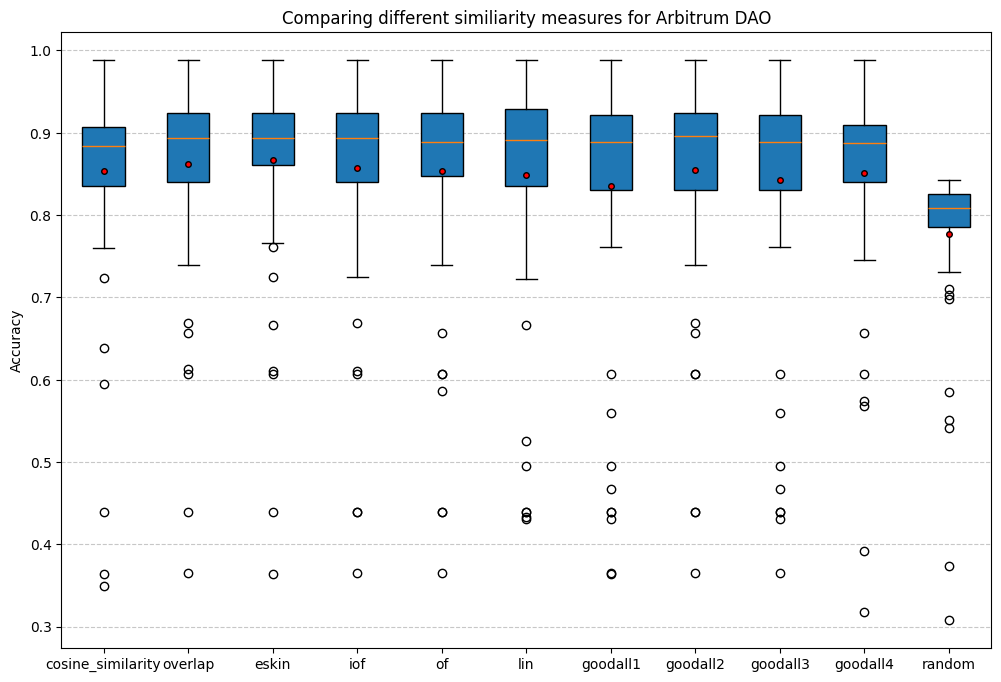

In [64]:
create_boxplots(non_cont_eval_result,"Comparing different similiarity measures for Arbitrum DAO")

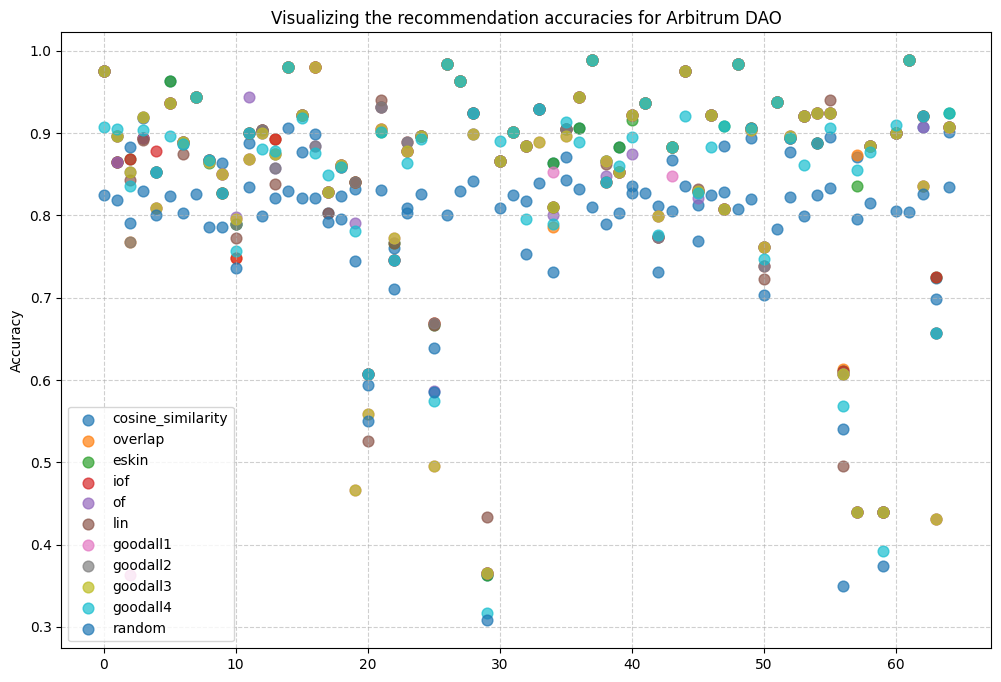

In [65]:
create_scatterplots(non_cont_eval_result,"Visualizing the recommendation accuracies for Arbitrum DAO")

# AAVE DAO

## Getting proposal data

In [36]:
 # getting proposals
query = gql("""
{
  proposals(
    first: 1000, 
    skip: 0, 
    where: { 
        space: "aavedao.eth"
    }, 
    orderBy: "created", 
    orderDirection: desc
) {
    id
    title
    start
    end
    state
    choices
    scores
    scores_total
    scores_updated
    author
    }
}
""")

#running the query
response = client.execute(query)
proposals = response['proposals']

# adding percentage scores to proposals
for i in range(len(proposals)):
    if proposals[i]['scores_total'] != 0:
        proposals[i]['percentage_scores'] = [proposals[i]['scores'][j]/sum(proposals[i]['scores']) for j in range(len(proposals[i]['scores']))]
    else:
        proposals[i]['percentage_scores'] = [0 for _ in range(len(proposals[i]['scores']))]

# converting to dataframe
proposals_df = pd.DataFrame(proposals)
proposals_df.head()

,id,title,start,end,state,choices,scores,scores_total,scores_updated,author,percentage_scores
0,0x45dd55f78430a6326bb13c442c8c399443cc5fa363ac...,[TEMP CHECK] Onboard tUSDe December expiry PT ...,1755097906,1755357106,closed,"[YAE, NAE, ABSTAIN]","[874839.6068089791, 0.02328936552757736, 156.4...",874996.117309,1755357166,0x320e8965D27522e64D134470264A9B4DeBC4C89d,"[0.9998211300634685, 2.661653585298625e-08, 0...."
1,0x6f269b20b8cf2806a25bd119a744f27c2238dcbe769b...,[TEMP CHECK] Onboard LsETH to Aave V3 Core Ins...,1755097754,1755356954,closed,"[YAE, NAE, ABSTAIN]","[874861.0530437803, 155.3827816176049, 1.12101...",875017.556838,1755357014,0x320e8965D27522e64D134470264A9B4DeBC4C89d,"[0.9998211421094602, 0.0001775767587784985, 1...."
2,0x505bb46ea29c5dbc0d8966f9dbcc61b4c635ebcb7dc5...,[ARFC] Aave Asset class Allowlist (AAcA) creation,1754383771,1754642971,closed,"[For, Against, Abstain]","[542141.1779666481, 0, 0]",542141.177967,1754643031,0xf71fc92e2949ccF6A5Fd369a0b402ba80Bc61E02,"[1.0, 0.0, 0.0]"
3,0xb2cba79897034be3d4c8ac48bb25f9485592b5f61578...,[TEMP CHECK] Update forum features,1754041526,1754300726,closed,"[YAE, NAY, Abstain]","[870398.6407089981, 0, 0]",870398.640709,1754300786,0xF1dF824419879Bb8a7E758173523F88EfB7Af193,"[1.0, 0.0, 0.0]"
4,0xd0d6ae015476ab371ea10e68ce270af05f45ec4ebcb1...,[ARFC] Claiming AAVE Rewards for the Sablier L...,1753872863,1754132063,closed,"[YAE, NAY, Abstain]","[863689.1321379007, 0, 0.039706281038571704]",863689.171844,1754132356,0xF1dF824419879Bb8a7E758173523F88EfB7Af193,"[0.9999999540271173, 0.0, 4.5972882760344624e-08]"


In [37]:
# deleting rows with zero engagement
proposals_df = proposals_df[proposals_df['scores_total'] != 0]

In [38]:
# saving proposals as json
proposals_df.to_json('snapshot_proposals_aave.json', orient='records', indent=4)

In [39]:
# identify proposals with high disasgreement
for row in proposals_df.itertuples():
    if max(row.percentage_scores) < 0.9:
        index = np.argmax(row.percentage_scores)
        print(row.choices[index],round(row.percentage_scores[index],3))

Against 0.692
YAE 0.768
YAE 0.858
YAE 0.827
For 0.847
YAE 0.541
YAE 0.689
YAE 0.839
YAE 0.87
YAE 0.788
YAE 0.808
ABSTAIN 0.766
YAE 0.763
YAE 0.882
ABSTAIN 0.65
YAE 0.82
YAE 0.478
NAY 0.9
YAE (Aggresive) 0.71
NAY 0.763
NAY 0.886
Arbitrum 0.874
Onboard LlamaRisk 0.808
YAE 0.72
YAE 0.511
YAE 0.693
YAE 0.514
NAY 0.648
YAE 0.803
ABSTAIN 0.677
YAE: Option C 0.616
YAE 0.83
YAE 0.564
For 0.639
Option B 0.695
Abstain 0.656
YAE 0.877
Aggressive Option 0.771
NAY 0.886
YAE 0.661
YAE 0.868
YAE 0.883
Option 2 0.68
ABSTAIN 0.63
ABSTAIN 0.454
YAE 0.56
YAE 0.895
YAE 0.838
Slope 1 -> 2.8%, Uopt -> 0.8 0.699
YAE 0.863
YAE 0.813
YAE (Option 3) 0.827
Option 1 0.727
Option 1 0.408
YAE 0.751
YAE 0.715
YAE 0.525
Option 3: 0.9 (no change) 0.522
Option 1 0.666
YAE 0.751
YAE 0.804
YAE 0.852
YAE 0.837
YAE 0.866
YAE 0.466
YAE 0.829
YAE 0.483
Reduce Stream 0.558
Option 3: Lever B 0.864
YAE - Agressive  0.854
YAE 0.458
YAE 0.867
YAE 0.532
NAE 0.499
YAE 0.869
YAE - Aggressive 0.542
Option 1: Lower LT 0.873
YAE 0.793


In [47]:
#defining contreversial proposals
mask = proposals_df['percentage_scores'].apply(lambda scores: max(scores) <= 0.7)
contreversial_proposals = proposals_df[mask]
print(contreversial_proposals['percentage_scores'].shape)

(65,)


## Getting voting data

In [49]:
# getting votes for each proposal
voting_data = []
ctr = 0
for proposal in proposals:
    print(ctr)
    votes_for_proposal = fetch_votes(proposal['id'])
    for vote in votes_for_proposal:
        vote['proposal_id'] = proposal['id']
        voting_data.append(vote)
    ctr+=1
voting_df = pd.DataFrame(voting_data)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [50]:
# saving voter data
voting_df.to_json('all_votes_snapshot_aave.json', orient='records', indent=4) 

In [51]:
# exploring types of proposals
proposals_categories = {'approval': 0,"weighted": 0, "single_choice":0}
prev_prop = None
for row in voting_df.itertuples():
    curr_prop = row.proposal_id
    if curr_prop != prev_prop:
        prev_prop = curr_prop
        if curr_prop in list(contreversial_proposals['id']):
            if isinstance(row.choice,int):
                proposals_categories['single_choice'] += 1
            elif isinstance(row.choice,dict):
                proposals_categories['weighted'] += 1
            elif isinstance(row.choice, list):
                proposals_categories['approval'] += 1

            else:
                raise ValueError
    else:
        continue

print(proposals_categories)

{'approval': 3, 'weighted': 1, 'single_choice': 61}


## Getting participation stats

In [53]:
# setting participation value
voting_df['participated'] = 1

# creating voter proposal matrix
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='participated',
    fill_value=0
)

In [54]:
voter_proposal_matrix.shape

(77093, 867)

In [65]:
#getting participation rate
participation_rate = voter_proposal_matrix.sum(axis=1) / voter_proposal_matrix.shape[1]
active_delegates = voter_proposal_matrix[participation_rate >= 0.5]
active_delegates.shape

(135, 867)

## Creating optimal training set

In [66]:
# getting votes for controversial proposal as basis for training set
voting_df = voting_df[voting_df.proposal_id.isin(contreversial_proposals.id)]

In [69]:
# setting participation value
voting_df['participated'] = 1

# creating voter proposal matrix
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='participated',
    fill_value=0
)

voter_proposal_matrix.shape

/var/folders/lc/cksd2x851xx27g4yf5dxc4mh0000gn/T/ipykernel_77214/1962510995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voting_df['participated'] = 1


(49519, 65)

In [70]:
recommendation_dataset = build_dataset(voter_proposal_matrix,20,50)
print(recommendation_dataset.shape)
recommendation_dataset

count    49519.000000
mean         7.147923
std          7.491548
min          1.000000
25%          1.000000
50%          3.000000
75%         16.000000
max         58.000000
Name: voter_participation, dtype: float64
(49520, 59)
count    49519.000000
mean         6.576789
std          6.755494
min          0.000000
25%          1.000000
50%          3.000000
75%         14.000000
max         58.000000
Name: voter_participation, dtype: float64
(49520, 57)
count    49519.000000
mean         6.565742
std          6.756582
min          0.000000
25%          1.000000
50%          3.000000
75%         14.000000
max         56.000000
Name: voter_participation, dtype: float64
(49520, 55)
count    49519.000000
mean         6.550435
std          6.761126
min          0.000000
25%          1.000000
50%          3.000000
75%         14.000000
max         54.000000
Name: voter_participation, dtype: float64
(49520, 52)
count    49519.000000
mean         6.392577
std          6.880994
min          0

proposal_id,0x00a60204ac48099bccff1b5801299486f73ef97fb4b51773e74a22a9e767930c,0x01986b578bdc52661ab0bedb85c57306f448b03d52cddf996784a7c498910d9d,0x02c94cf8410d02290354f589062cd3c1aee12b3c12f813000a0449c301ab03f0,0x151df3127d187c203ff3a975d8ab9e34493d77edf67ec6884dc086d5aea9ce89,0x1751d8de3c549ee99fbc9c1286d9575c482c3e639500dcc027455c8742d48bc9,0x192a24fd2b3e1860ce4570c0773d82ab895d27cabf48dddd9bafba7e4e13851e,0x1ef144485f473c7049f56db0818c09a74ca92d6f67975f5dc620cccd9646e015,0x25045871e22346303d2c2c89a4185a58859b3567e2b7dc0234dd2dd920d7c1f7,0x2cb10cfb57a79bb97c3aed1cc3e9847227fb0f6a843916921ae315b9d8ad11d3,0x2d7bf95ae2f77992afdc1d507d31ff71bff89022e579e3bb2d01b770b77c0d2b,...,0xd0c7e9d2268d97818c8c9fd99495eeb67cfa736c2b35c07bacfba70603c50d6c,0xd7421a74db14aecb20a12c2e8c107d6718131e47b4c92cf8490fd6771b01c5b1,0xdd959bb517650feceb9720c0581aa3703e5d5acf1dfaf13310e53eba8e945c34,0xe9b62e197a98832da7d1231442b5960588747f184415fba4699b6325d7618842,0xf6bc25809a931910ea490b86b3c847dc30e09fc0d278ebf0bcdd48f4868e35c1,0xf6da417983653f7e7f5560a8e16ad77d5e25533bba9157abfd222347b40d09d0,0xf9261916c696ce2d793af41b7fe556896ed1ff7a8330b7d0489d5567ebefe3ba,0xf92c5647c7f60a4a3db994b4953fc4408f5946cafdc0cebcd4c5924f40e04d36,0xfdd5f215f845ec1733f07997160864af31d6fb5347dc868684476ef42494f0b8,voter_participation
0x2D5823E8e8B4dfbf599a97566ff2A121Cc141d60,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0
0x70Ddb5AbF21202602b57F4860eE1262a594a0086,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0
0x35E6fc00e3F190A8dFe15faa219368a01028ec14,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0
0x9FA7d42Ef9eb89ef6FAbDdE88207FbE6AfA70626,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0
0xe44782AFE398800d7190796018C4b865E32fF806,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0
0xd31A84c20bc430aD75E6a1903E7dDbee52211072,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0
0xD03Ad690ed8065EDfdC1E08197a3ebC71535A7ff,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0
0x1B9DA462D07512Fa37021973d853B59dEbB761Dd,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0
0x79ccEDbEFbfE6c95570d85e65f8B0aC0D6bd017B,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0
0x972a8B7D891B88220780421fE4D11f174354cEEd,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0


In [71]:
recommendation_dataset = recommendation_dataset.drop('voter_participation', axis = 1)

In [72]:
proposal_choices_dict = contreversial_proposals.set_index('id')['choices'].to_dict()
voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice_value',
    aggfunc='first',
    fill_value="NaN"
)
recommendation_dataset_matrix = voter_proposal_matrix.loc[voter_proposal_matrix.index.isin(recommendation_dataset.index)]
recommendation_dataset_matrix = recommendation_dataset_matrix.drop([col for col in recommendation_dataset_matrix.columns if col not in recommendation_dataset.columns], axis = 1)
recommendation_dataset_matrix[recommendation_dataset_matrix.columns] = recommendation_dataset_matrix[recommendation_dataset_matrix.columns].astype(int)
recommendation_dataset_matrix

/var/folders/lc/cksd2x851xx27g4yf5dxc4mh0000gn/T/ipykernel_77214/1628410998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)


proposal_id,0x00a60204ac48099bccff1b5801299486f73ef97fb4b51773e74a22a9e767930c,0x01986b578bdc52661ab0bedb85c57306f448b03d52cddf996784a7c498910d9d,0x02c94cf8410d02290354f589062cd3c1aee12b3c12f813000a0449c301ab03f0,0x151df3127d187c203ff3a975d8ab9e34493d77edf67ec6884dc086d5aea9ce89,0x1751d8de3c549ee99fbc9c1286d9575c482c3e639500dcc027455c8742d48bc9,0x192a24fd2b3e1860ce4570c0773d82ab895d27cabf48dddd9bafba7e4e13851e,0x1ef144485f473c7049f56db0818c09a74ca92d6f67975f5dc620cccd9646e015,0x25045871e22346303d2c2c89a4185a58859b3567e2b7dc0234dd2dd920d7c1f7,0x2cb10cfb57a79bb97c3aed1cc3e9847227fb0f6a843916921ae315b9d8ad11d3,0x2d7bf95ae2f77992afdc1d507d31ff71bff89022e579e3bb2d01b770b77c0d2b,...,0xceae27bbaf42658a1b46baec664c66c09f9cba4f9452ed2d2bed6f6ce5c66e35,0xd0c7e9d2268d97818c8c9fd99495eeb67cfa736c2b35c07bacfba70603c50d6c,0xd7421a74db14aecb20a12c2e8c107d6718131e47b4c92cf8490fd6771b01c5b1,0xdd959bb517650feceb9720c0581aa3703e5d5acf1dfaf13310e53eba8e945c34,0xe9b62e197a98832da7d1231442b5960588747f184415fba4699b6325d7618842,0xf6bc25809a931910ea490b86b3c847dc30e09fc0d278ebf0bcdd48f4868e35c1,0xf6da417983653f7e7f5560a8e16ad77d5e25533bba9157abfd222347b40d09d0,0xf9261916c696ce2d793af41b7fe556896ed1ff7a8330b7d0489d5567ebefe3ba,0xf92c5647c7f60a4a3db994b4953fc4408f5946cafdc0cebcd4c5924f40e04d36,0xfdd5f215f845ec1733f07997160864af31d6fb5347dc868684476ef42494f0b8
voter,,,,,,,,,,,,,,,,,,,,,
0x00432772Ed25d4Eb3C6EB26Dc461239b35cf8760,7,1,1,2,1,1,1,1,1,1,...,1,1,1,1,2,3,7,2,3,1
0x0516cf37B67235E07aF38ad8E388d0E68089b0F2,1,1,1,2,1,1,1,1,1,1,...,1,1,1,1,2,3,7,2,3,1
0x0E26F5bd12EafaE9753E2741f2dc151bE894070A,5,1,1,2,1,1,1,1,1,1,...,1,1,1,1,2,3,3,2,3,1
0x0fF9B6AB6Ec58ceB6D5ae8a1690dd5a0959aD002,2,2,1,2,1,1,1,1,1,1,...,1,1,1,1,2,3,7,2,3,1
0x119383B0051e920D6161cEe971247D625B8D69Cb,8,1,1,2,1,1,1,1,1,1,...,1,1,1,1,2,3,7,2,3,1
0x1B9DA462D07512Fa37021973d853B59dEbB761Dd,2,1,1,2,1,1,1,1,1,1,...,1,1,1,1,2,3,11,2,3,1
0x1b5b4fCEDF1252cd92496a2fd5C593b39aC49b01,6,1,1,2,1,1,1,1,1,1,...,1,1,1,1,2,3,11,2,3,1
0x2D5823E8e8B4dfbf599a97566ff2A121Cc141d60,6,1,1,2,1,1,1,1,1,1,...,1,1,1,1,2,3,1,2,3,1
0x344b1E4Ac175f16D3bA40A688cA928E3768E275a,1,1,1,2,1,1,1,1,1,1,...,1,1,1,1,2,3,9,2,3,1


In [73]:
# saving recommendation_dataset_matrix into json
recommendation_dataset_matrix.to_json('recommendation_dataset_matrix_aave.json', orient='table', indent=4)

In [74]:
# evaluating behavior for active delegates in these proposals
proposals = list(recommendation_dataset_matrix.columns)
for prop in proposals:
    prop_voting_data = list(recommendation_dataset_matrix[prop])
    voter_behaviour = {}
    for vote in prop_voting_data:
        if vote in voter_behaviour.keys():
            voter_behaviour[vote] += 1
        else:
            voter_behaviour[vote] = 1
    stats = round(max(voter_behaviour.values())/sum(voter_behaviour.values()),2)
    print('agreement rate for prop: ', prop, ' = ',stats)
    # print(voter_behaviour)

agreement rate for prop:  0x00a60204ac48099bccff1b5801299486f73ef97fb4b51773e74a22a9e767930c  =  0.21
agreement rate for prop:  0x01986b578bdc52661ab0bedb85c57306f448b03d52cddf996784a7c498910d9d  =  0.79
agreement rate for prop:  0x02c94cf8410d02290354f589062cd3c1aee12b3c12f813000a0449c301ab03f0  =  1.0
agreement rate for prop:  0x151df3127d187c203ff3a975d8ab9e34493d77edf67ec6884dc086d5aea9ce89  =  0.97
agreement rate for prop:  0x1751d8de3c549ee99fbc9c1286d9575c482c3e639500dcc027455c8742d48bc9  =  1.0
agreement rate for prop:  0x192a24fd2b3e1860ce4570c0773d82ab895d27cabf48dddd9bafba7e4e13851e  =  0.97
agreement rate for prop:  0x1ef144485f473c7049f56db0818c09a74ca92d6f67975f5dc620cccd9646e015  =  1.0
agreement rate for prop:  0x25045871e22346303d2c2c89a4185a58859b3567e2b7dc0234dd2dd920d7c1f7  =  0.97
agreement rate for prop:  0x2cb10cfb57a79bb97c3aed1cc3e9847227fb0f6a843916921ae315b9d8ad11d3  =  0.97
agreement rate for prop:  0x2d7bf95ae2f77992afdc1d507d31ff71bff89022e579e3bb2d01b770b

## Creating training and validation sets

In [66]:
recommendation_dataset = pd.read_json('recommendation_dataset_matrix_aave.json', orient='table')

In [67]:
training_set = recommendation_dataset

In [68]:
choices = {}
for prop in training_set.columns:
    # getting choices
    query = gql(f"""
    {{
    proposals(
        first: 1000, 
        skip: 0, 
        where: {{ 
            space: "aavedao.eth",
            id: "{prop}"
        }}, 
        orderBy: "created", 
        orderDirection: desc
    ) {{
        choices
        }}
    }}
    """)
    #running the query
    response = client.execute(query)
    choices[prop] = response['proposals'][0]['choices']
print(choices)

{'0x00a60204ac48099bccff1b5801299486f73ef97fb4b51773e74a22a9e767930c': ['Good Faith / Integrity', 'Best Interest', 'Due Care and Attention', 'Communication', 'Professional Knowledge', 'Conflicts of Interest', 'Availability', 'Security Optimization'], '0x01986b578bdc52661ab0bedb85c57306f448b03d52cddf996784a7c498910d9d': ['YAE - Option 1', 'YAE - Option 2', 'YAE - Option 3', 'NAE', 'ABSTAIN'], '0x02c94cf8410d02290354f589062cd3c1aee12b3c12f813000a0449c301ab03f0': ['YAE', 'NAY', 'ABSTAIN'], '0x151df3127d187c203ff3a975d8ab9e34493d77edf67ec6884dc086d5aea9ce89': ['Option 1', 'Option 2', 'Option 3 (no change)', 'Abstain'], '0x1751d8de3c549ee99fbc9c1286d9575c482c3e639500dcc027455c8742d48bc9': ['YAE', 'NAE', 'ABSTAIN'], '0x192a24fd2b3e1860ce4570c0773d82ab895d27cabf48dddd9bafba7e4e13851e': ['Slope 1 -> 3.2%, Uopt -> 0.8', 'Slope 1 -> 2.8%, Uopt -> 0.8', 'No change', 'Abstain'], '0x1ef144485f473c7049f56db0818c09a74ca92d6f67975f5dc620cccd9646e015': ['YAE', 'NAY', 'ABSTAIN'], '0x25045871e22346303d2c

In [69]:
with open("all_votes_snapshot_aave.json", "r") as f:
    data = json.load(f)
voting_df = pd.DataFrame(data).set_index("voter")
voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)
vp_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice_value',
    aggfunc='first',
    fill_value=np.nan
)
freq_dist = get_freq_dist_vp_matrix(training_set)

/var/folders/lc/cksd2x851xx27g4yf5dxc4mh0000gn/T/ipykernel_50544/1596539548.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vp_matrix = voting_df.pivot_table(


In [70]:
# building a new dict for vectorizing labels
vectorized_labels_mapping = {
    'Option 1' : 1,
    'Option 2' : -1,
    "No change" : 0,
    "YAE - 80/20 AAVE/wETH":1,
    'YAE - 80/20 AAVE/wstETH':2,
    'NAE - Rework Proposal':-1,
    'ABSTAIN':0,
    'For':1,
    'Against':-1,
    'Abstain':0,
    'YAE':1,
    'NAY':-1,
    'YAE - Chaos Labs (21,000 units)':21,
    'YAE - Gauntlet (18,000 units)':18,
    'NAE':-1,
    'Option 1: Add EM Specific Caps': 2,
    'Option 2: No EM Specific Caps':1,
    'Nay': -1,
    'Option 1 - YAE 19.6M Supply Cap':196,
    'Option 2 - YAE 29.3M Supply Cap':293,
    'YAE (Cancel Stream)':2,
    'Reduce Stream':1,
    'Option A':1, 
    'Option B':-1
}

In [71]:
transformed_df = encode_labels(training_set,choices,vectorized_labels_mapping)

In [72]:
# performing the recommendation
recommended_delegates = {'cosine_similarity':[], 'overlap': [],'eskin': [],'iof':[], 'of': [], 'lin': [], 'goodall1': [], 'goodall2': [], 'goodall3': [], 'goodall4': []}
for voter_id in training_set.index:
    # storing results of cosine similiarity
    top_delegate = recommend_delegates(voter_id,transformed_df,"cosine_similarity",freq_dist).iloc[0,0]
    recommended_delegates['cosine_similarity'].append((voter_id,top_delegate))
    #storing overlap distance
    top_delegate = recommend_delegates(voter_id,training_set,"overlap",freq_dist).iloc[0,0]
    recommended_delegates['overlap'].append((voter_id,top_delegate))
    #storing results for eskin
    top_delegate = recommend_delegates(voter_id,training_set,"eskin",freq_dist).iloc[0,0]
    recommended_delegates['eskin'].append((voter_id,top_delegate))
    #storing results for iof
    top_delegate = recommend_delegates(voter_id,training_set,"iof",freq_dist).iloc[0,0]
    recommended_delegates['iof'].append((voter_id,top_delegate))
    #storing results for of
    top_delegate = recommend_delegates(voter_id,training_set,"of",freq_dist).iloc[0,0]
    recommended_delegates['of'].append((voter_id,top_delegate))
    #storing results for lin
    top_delegate = recommend_delegates(voter_id,training_set,"lin",freq_dist).iloc[0,0]
    recommended_delegates['lin'].append((voter_id,top_delegate))
    #storing results for goodall1
    top_delegate = recommend_delegates(voter_id,training_set,"goodall1",freq_dist).iloc[0,0]
    recommended_delegates['goodall1'].append((voter_id,top_delegate))
    #storing results for goodall2
    top_delegate = recommend_delegates(voter_id,training_set,"goodall2",freq_dist).iloc[0,0]
    recommended_delegates['goodall2'].append((voter_id,top_delegate))
    #storing results for goodall3
    top_delegate = recommend_delegates(voter_id,training_set,"goodall3",freq_dist).iloc[0,0]
    recommended_delegates['goodall3'].append((voter_id,top_delegate))
    #storing results for goodall4
    top_delegate = recommend_delegates(voter_id,training_set,"goodall4",freq_dist).iloc[0,0]
    recommended_delegates['goodall4'].append((voter_id,top_delegate))

## Evaluating on non contreversial proposals

In [73]:
# getting voting data for non controversial proposals
voting_df = pd.read_json('all_votes_snapshot_aave.json', orient='records')
voting_df = voting_df[~voting_df.proposal_id.isin(recommendation_dataset.columns)]
voting_df = voting_df[voting_df.voter.isin(recommendation_dataset.index)]

In [74]:
proposals = pd.read_json('snapshot_proposals_aave.json', orient='records')

In [75]:
proposal_choices_dict = proposals.set_index('id')['choices'].to_dict()
voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice_value',
    aggfunc='first',
    fill_value=np.nan
)

In [76]:
voter_proposal_matrix

proposal_id,0x001a41f25e7c6689ea5f1b03d234cd9286af0025d14f14f0eefc16515a3217b9,0x003ce30676805f71e5b356745fb3f01e5f82b8d1655750aaef46c7ed4a0a3578,0x00d31a50619d1f2a0b9158145d5cd91f61ce7987952216996f0ac8c64e5fb39a,0x011c725f11b8da5de80cef9b52a5deccb120fcd7f276dd6ede76a7c2fc844860,0x013f763e92d253926bc7f04d79138593a1b31c969a34db7f0955e46850c796d9,0x014370349d306dfd70bb13b81ca299c1d025e177f317de6f910b1a7c70436ce7,0x0152d891ae51ef5eef5c912507842469c7527be2da82e4e03bccf26801e040aa,0x021b40c7042ce770c0ce1ee5ff63591c132a9f0f12e3a1cb92fa209299793dec,0x02283fcdd2d1d91d6bb6cdeca0fd54a57c48bcab2e665a4d2f96a45297298752,0x0341f4050ed20182c2c344fb370d958f8f77f7035c4783408dd0f962b7d39544,...,bafkreiaiba6o7b3bsosligjrxnzlxgvkckgqriqlle6d4xa3i4qcfljmru,bafkreiasu3ha5kldlsqukqu7vq3ar7bujgd6qkvwxsx34smjscplemonua,bafkreiba2pdfwoesezgpedf37bjfgadxmaigavoulek5wayqb7f2tz6byy,bafkreic2sezyt4xnxnp6uyrv7uyzrozmhe3cf6powbs4mnx6zod4vxk2km,bafkreiddji5eiuwpaxg3ntmrici7m3w23iunjnwpylobzkinogpt4elm5e,bafkreidmj5twyypvk3se7nojlgw44zdcoz3d3szgddx2viug65grf42uce,bafkreieeyh6pbqwhgryo6v67oxlmnfhaptrgkc3u7y6bvz2y3jdkxgrrh4,bafkreif6zjw4o3wcgmolqbnehxgflupejziyhsiksldstalz5wz4nghccu,bafkreifzegmoezpusap6vyztlped2lfggpyzjooyz3h5wdrnqknlpb4ryu,bafkreigdmcfmwvnxfolpds4xkdicgrszgmknig7pz2r2t37tltupdpyfu4
voter,,,,,,,,,,,,,,,,,,,,,
0x00432772Ed25d4Eb3C6EB26Dc461239b35cf8760,1.0,NaN,1.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,4.0
0x0516cf37B67235E07aF38ad8E388d0E68089b0F2,1.0,NaN,1.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,4.0
0x0E26F5bd12EafaE9753E2741f2dc151bE894070A,1.0,NaN,1.0,NaN,2.0,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
0x0fF9B6AB6Ec58ceB6D5ae8a1690dd5a0959aD002,1.0,NaN,1.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,4.0
0x119383B0051e920D6161cEe971247D625B8D69Cb,1.0,NaN,1.0,1.0,2.0,1.0,1.0,NaN,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,4.0
0x1B9DA462D07512Fa37021973d853B59dEbB761Dd,1.0,NaN,1.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,4.0
0x1b5b4fCEDF1252cd92496a2fd5C593b39aC49b01,1.0,NaN,1.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,4.0
0x2D5823E8e8B4dfbf599a97566ff2A121Cc141d60,1.0,NaN,1.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,4.0
0x344b1E4Ac175f16D3bA40A688cA928E3768E275a,1.0,NaN,1.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,4.0


In [77]:
# performing evaluation
non_cont_eval_result = {'cosine_similarity':[], 'overlap': [], 'eskin': [],'iof':[], 'of': [], 'lin': [], 'goodall1': [], 'goodall2': [], 'goodall3': [], 'goodall4': [], "random":[]}
# get number of evaluation points
eval_points = len(recommended_delegates['cosine_similarity'])
for i in range(eval_points):
    # evaluating cosine similiarity
    non_cont_eval_result['cosine_similarity'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'cosine_similarity',i))

    # evaluating overlap similiarity
    non_cont_eval_result['overlap'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'overlap',i))

    # evaluating eskin similiarity
    non_cont_eval_result['eskin'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'eskin',i))

    # evaluating iof similiarity
    non_cont_eval_result['iof'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'iof',i))

    # evaluating of similiarity
    non_cont_eval_result['of'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'of',i))

    # evaluating lin similiarity
    non_cont_eval_result['lin'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'lin',i))

    # evaluating goodall1 similiarity
    non_cont_eval_result['goodall1'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall1',i))

    # evaluating goodall2 similiarity
    non_cont_eval_result['goodall2'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall2',i))

    # evaluating goodall3 similiarity
    non_cont_eval_result['goodall3'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall3',i))

    # evaluating goodall4 similiarity
    non_cont_eval_result['goodall4'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall4',i))

    # evaluating random delegation (baseline)
    baseline_for_voter = []
    for possible_delegate in voter_proposal_matrix.drop(recommended_delegates['overlap'][i][0]).index:
        common_proposals = filter_common_proposals(voter_proposal_matrix.loc[recommended_delegates['overlap'][i][0]],voter_proposal_matrix.loc[possible_delegate])
        if common_proposals:
            same_votes = [prop for prop in common_proposals if voter_proposal_matrix.loc[recommended_delegates['overlap'][i][0]][prop] == voter_proposal_matrix.loc[possible_delegate][prop]]
            baseline_for_voter.append(len(same_votes)/len(common_proposals))
    non_cont_eval_result['random'].append(sum(baseline_for_voter)/len(baseline_for_voter))

In [78]:
# Printing out stats
print("Cosine Similarity")
print(pd.Series(non_cont_eval_result['cosine_similarity']).describe())
print()
print("Overlap Similarity")
print(pd.Series(non_cont_eval_result['overlap']).describe())
print()
print("Eskin")
print(pd.Series(non_cont_eval_result['eskin']).describe())
print()
print("iof")
print(pd.Series(non_cont_eval_result['iof']).describe())
print()
print("of")
print(pd.Series(non_cont_eval_result['of']).describe())
print()
print("lin")
print(pd.Series(non_cont_eval_result['lin']).describe())
print()
print("goodall1")
print(pd.Series(non_cont_eval_result['goodall1']).describe())
print()
print("goodall2")
print(pd.Series(non_cont_eval_result['goodall2']).describe())
print()
print("goodall3")
print(pd.Series(non_cont_eval_result['goodall3']).describe())
print()
print("goodall4")
print(pd.Series(non_cont_eval_result['goodall4']).describe())
print()
print("Random Delegation (Baseline)")
print(pd.Series(non_cont_eval_result['random']).describe())

Cosine Similarity
count    29.000000
mean      0.983144
std       0.017780
min       0.895210
25%       0.984071
50%       0.986532
75%       0.989316
max       0.995717
dtype: float64

Overlap Similarity
count    29.000000
mean      0.985016
std       0.019603
min       0.887324
25%       0.987273
50%       0.989316
75%       0.991135
max       0.996377
dtype: float64

Eskin
count    29.000000
mean      0.985268
std       0.018900
min       0.891566
25%       0.986532
50%       0.989316
75%       0.991409
max       0.996377
dtype: float64

iof
count    29.000000
mean      0.982629
std       0.024424
min       0.895210
25%       0.986532
50%       0.989150
75%       0.989916
max       0.996377
dtype: float64

of
count    29.000000
mean      0.986171
std       0.019893
min       0.887324
25%       0.987273
50%       0.989637
75%       0.993243
max       0.997863
dtype: float64

lin
count    29.000000
mean      0.983254
std       0.024573
min       0.895210
25%       0.987319
50%       0

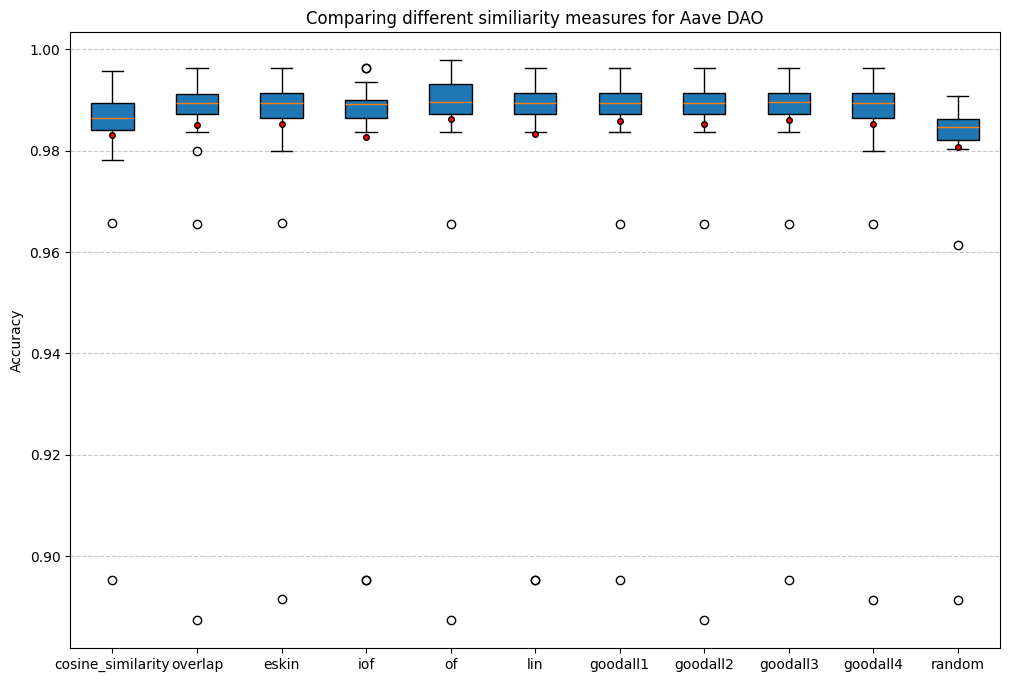

In [79]:
create_boxplots(non_cont_eval_result,"Comparing different similiarity measures for Aave DAO")

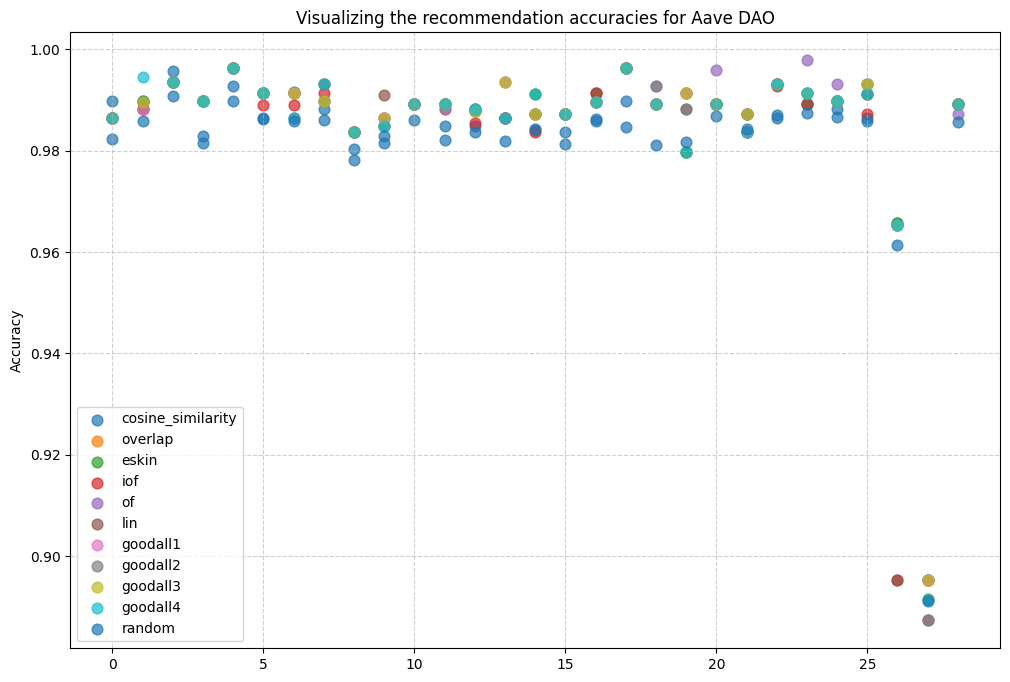

In [80]:
create_scatterplots(non_cont_eval_result,"Visualizing the recommendation accuracies for Aave DAO")

## Calculating similiarity between active delegates

In [106]:
voting_df = pd.read_json('all_votes_snapshot_aave.json', orient='records').set_index('voter')
# setting participation value
voting_df['participated'] = 1

# creating voter proposal matrix
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='participated',
    fill_value=0
)
participation_rate = voter_proposal_matrix.sum(axis=1) / voter_proposal_matrix.shape[1]

In [107]:
active_delegates = voter_proposal_matrix[participation_rate >= 0.745]

In [109]:
proposals_df = pd.read_json('snapshot_proposals_aave.json', orient='records')

In [110]:
voting_df['choice'] = voting_df.apply(map_choice_value, axis=1)
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice',
    aggfunc='first'
)

In [111]:
voter_proposal_matrix = voter_proposal_matrix.loc[voter_proposal_matrix.index.isin(active_delegates.index)]

In [112]:
similarity_matrix_active_delegates = pd.DataFrame(np.nan, index=voter_proposal_matrix.index, columns=voter_proposal_matrix.index)

In [113]:
for delegate_i in voter_proposal_matrix.index:
    for delegate_j in voter_proposal_matrix.index:
        common_proposals = filter_common_proposals(voter_proposal_matrix.loc[delegate_i],voter_proposal_matrix.loc[delegate_j])
        same_votes = [prop for prop in common_proposals if voter_proposal_matrix.loc[delegate_i][prop] == voter_proposal_matrix.loc[delegate_j][prop]]
        similarity_matrix_active_delegates.loc[delegate_i,delegate_j] = len(same_votes)/len(common_proposals)

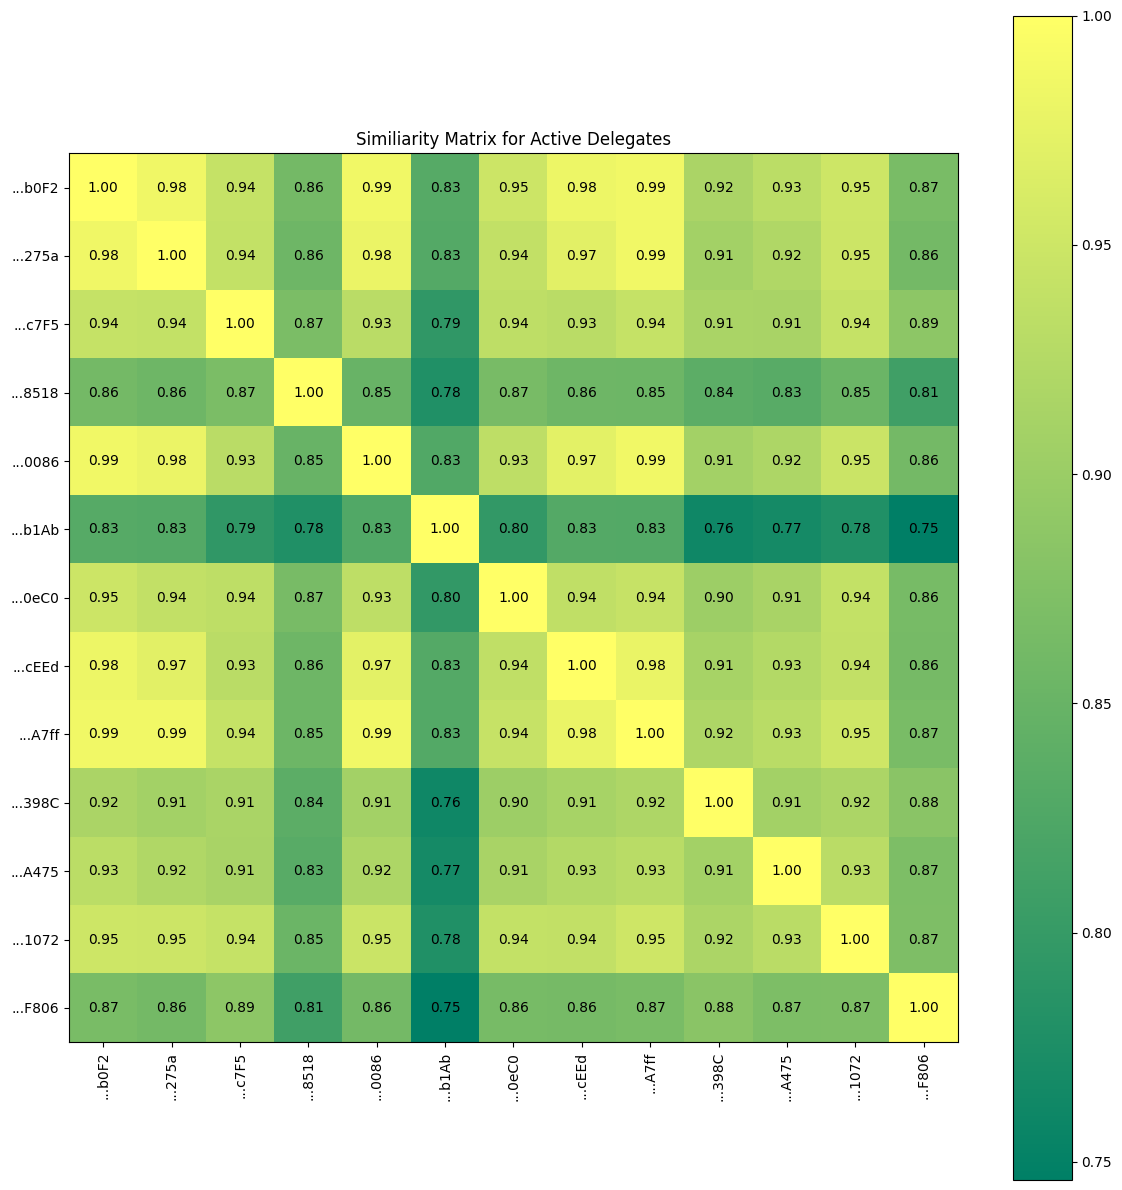

In [114]:
plot_similiarity_matrix(similarity_matrix_active_delegates,(12,12))

# ENS DAO

## Fetching proposal data

In [115]:
# getting proposals
query = gql("""
{
  proposals(
    first: 1000, 
    skip: 0, 
    where: { 
        space: "ens.eth"
    }, 
    orderBy: "created", 
    orderDirection: desc
) {
    id
    title
    start
    end
    state
    choices
    scores
    scores_total
    scores_updated
    author
    }
}
""")

#running the query
response = client.execute(query)
proposals = response['proposals']

# adding percentage scores to proposals
for i in range(len(proposals)):
    if proposals[i]['scores_total'] != 0:
        proposals[i]['percentage_scores'] = [proposals[i]['scores'][j]/sum(proposals[i]['scores']) for j in range(len(proposals[i]['scores']))]
    else:
        proposals[i]['percentage_scores'] = [0 for _ in range(len(proposals[i]['scores']))]

# converting to dataframe
proposals_df = pd.DataFrame(proposals)
proposals_df.head()

,id,title,start,end,state,choices,scores,scores_total,scores_updated,author,percentage_scores
0,0xf06f3ad61f9f77c8ed362dd54913cc44d030841eebeb...,[EP6.16] [Social] Enhancing ENS Governance wit...,1752721753,1753153753,closed,"[For, Against, Abstain]","[647.5762625905046, 1153764.2056795838, 30120....",1.184532e+06,1753153813,0xc02771315d0958F23a64140160E78ECB9bB8614e,"[0.0005466935909684304, 0.9740250425650164, 0...."
1,0xa9c47b281667a85f80e0cc9be5904438c9205e123352...,[EP 6.14] [Social] Proposal to form the OpenBo...,1750884477,1751316477,closed,"[For, Against, Abstain]","[1339966.942543978, 0, 111423.70622945488]",1.451391e+06,1751316537,0xe52C39327FF7576bAEc3DBFeF0787bd62dB6d726,"[0.9232296926236787, 0.0, 0.07677030737632133]"
2,0x98c65ac02f738ddb430fcd723ea5852a45168550b3da...,[EP 6.10] [Social] Select providers for Servic...,1746658412,1747090412,closed,"[NONE BELOW, Web3bio, Lighthouse Labs, Agora -...","[107698.86087419953, 17231.817739871924, 81851...",2.714011e+06,1747090416,0xe52C39327FF7576bAEc3DBFeF0787bd62dB6d726,"[0.03968253968253969, 0.00634920634920635, 0.0..."
3,0x2c07add832383dc6900077406b4241a34dc4923ba209...,[6.6.2] [Social] April Funding Request - ENS P...,1744841373,1745273373,closed,"[For, Against, Abstain]","[1492560.8372845452, 0, 1.0330023344766626]",1.492562e+06,1745273388,0x54BeCc7560a7Be76d72ED76a1f5fee6C5a2A7Ab6,"[0.9999993078998232, 0.0, 6.921001769113351e-07]"
4,0x2c56d8776c8be3a824d010f94f00108716acaa31ede9...,[6.6.1] [Social] April Funding Request - ENS M...,1744808571,1745240571,closed,"[For, Against, Abstain]","[1602311.5991022713, 0.1947185787506478, 1.033...",1.602313e+06,1745240591,0xe52C39327FF7576bAEc3DBFeF0787bd62dB6d726,"[0.9999992337820102, 1.2152344753845938e-07, 6..."


In [116]:
# deleting rows with zero engagement
proposals_df = proposals_df[proposals_df['scores_total'] != 0]

In [118]:
# saving proposals as json
proposals_df.to_json('snapshot_proposals_ens.json', orient='records', indent=4)

In [119]:
# identify proposals with high disasgreement
for row in proposals_df.itertuples():
    if max(row.percentage_scores) < 0.9:
        index = np.argmax(row.percentage_scores)
        print(row.choices[index],round(row.percentage_scores[index],3))

eth.limo - basic 0.056
For 0.785
For 0.59
RENEW and increase to $4.5M/y 0.523
coltron.eth 0.27
limes.eth 0.311
netto.eth / alexnetto.eth 0.268
Nick.eth  0.83
For 0.851
YES | 30K ENS 0.505
For 0.502
Abstain 0.801
For 0.588
For 0.891
For 0.49
Approve $300k settlement 0.358
coltron.eth 0.292
eth.limo 0.119
limes.eth 0.285
Spence / 5pence.eth 0.323
YES for one year terms 0.501
YES: Budget of $3.6M/y 0.649
For 0.818
Nick Johnson / nick.eth 0.254
slobo.eth 0.295
coltron.eth 0.335
Alex Van de Sande 0.88
For 0.867
nick.eth 0.228
slobo.eth 0.319
avsa.eth 0.249
Karpatkey 0.576
For 0.861
For 0.881
avsa.eth 0.565
coltron.eth 0.5
slobo.eth 0.501
nick.eth 0.522
avsa.eth 0.606
Against 0.434
ceresstation.eth 0.517
spencecoin.eth 0.567
avsa.eth 0.615
simona.eth 0.548
1. Transfer Treasury 0.3
Ratify Article I 0.251
Nfty chat by slobo.eth 0.749
100 copies, raffle 0.681


In [124]:
#defining contreversial proposals
mask = proposals_df['percentage_scores'].apply(lambda scores: max(scores) <= 0.7)
contreversial_proposals = proposals_df[mask]
print(contreversial_proposals['percentage_scores'].shape)

(37,)


## Getting voting data

In [125]:
# getting votes for each proposal
voting_data = []
ctr = 0
for proposal in proposals:
    print(ctr)
    votes_for_proposal = fetch_votes(proposal['id'])
    for vote in votes_for_proposal:
        vote['proposal_id'] = proposal['id']
        voting_data.append(vote)
    ctr+=1
voting_df = pd.DataFrame(voting_data)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83


In [126]:
# saving voter data
voting_df.to_json('all_votes_snapshot_ens.json', orient='records', indent=4) 

In [127]:
# exploring types of proposals
proposals_categories = {'approval': 0,"weighted": 0, "single_choice":0}
prev_prop = None
for row in voting_df.itertuples():
    curr_prop = row.proposal_id
    if curr_prop != prev_prop:
        prev_prop = curr_prop
        if curr_prop in list(contreversial_proposals['id']):
            if isinstance(row.choice,int):
                proposals_categories['single_choice'] += 1
            elif isinstance(row.choice,dict):
                proposals_categories['weighted'] += 1
            elif isinstance(row.choice, list):
                proposals_categories['approval'] += 1

            else:
                raise ValueError
    else:
        continue

print(proposals_categories)

{'approval': 31, 'weighted': 0, 'single_choice': 6}


## Getting participation stats of delegates

In [128]:
# setting participation value
voting_df['participated'] = 1

# creating voter proposal matrix
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='participated',
    fill_value=0
)

In [129]:
voter_proposal_matrix.shape

(87840, 84)

In [130]:
#getting participation rate
participation_rate = voter_proposal_matrix.sum(axis=1) / voter_proposal_matrix.shape[1]

In [136]:
active_delegates = voter_proposal_matrix[participation_rate >= 0.5]
active_delegates.shape

(50, 84)

## Creating optimal training dataset

In [137]:
# getting votes for controversial proposal as basis for training set
voting_df = voting_df[voting_df.proposal_id.isin(contreversial_proposals.id)]

In [149]:
# setting participation value
voting_df['participated'] = 1

# creating voter proposal matrix
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='participated',
    fill_value=0
)

voter_proposal_matrix.shape

(86944, 37)

In [150]:
recommendation_dataset = build_dataset(voter_proposal_matrix,20,20)
print(recommendation_dataset.shape)
recommendation_dataset

count    86944.000000
mean         1.165394
std          1.139377
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         37.000000
Name: voter_participation, dtype: float64
(86945, 37)
count    86944.000000
mean         1.162070
std          1.116441
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         36.000000
Name: voter_participation, dtype: float64
(86945, 36)
count    86944.000000
mean         1.137065
std          1.101915
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         35.000000
Name: voter_participation, dtype: float64
(86945, 35)
count    86944.000000
mean         1.131866
std          1.060011
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         34.000000
Name: voter_participation, dtype: float64
(86945, 34)
count    86944.000000
mean         1.128048
std          1.021859
min          0

proposal_id,0x00bd3f6c317331cb20e8123d9423538ddde87e74d4caa54becb50ef56f999561,0x1ab7ef84f6e904582d5b5b921944b5b1a8e36dbff1f1248fde87fef02b046816,0x1b1ed675d08dd689148133c5be076e78997500d1969894d980759ba38c358c3d,0x26a5c8dec547837495707e70446d1e7cd874a91f75753c602998f6e70083a266,0x3585235855fd484251e01820c8cbf3e69174c0176496823b7b54be7a6b68b86c,0x42605fa85d059459f7072aeaeea4cd14ada78e15d9aa1998fe99634a75f9f5a6,0x5748982aed143f51333befbc6cc490116648b85a2b0212fdfaf3ab848932c7ae,0x6ebef8ee7169fd81bd87691e8dad852e2fa677bd52eedf0fd2da3623f489cd3d,0xa1a41a0a1d0588502cd8a3e0c1d0d6e0ad82b2c7af21a1a4999ff7f617a01ac9,0xa245dc7264ae072620434996e1c66d82c64cefc5a2edde5114d691a8559d0b5f,...,0xa9a2dc5a52ea54b478c4c5fea88540622dff7ad5000f8d146dff482c6e6b6055,0xb33e76201100b32a09f8aa367ad564e910f45b845318715439fee7e4978efd6b,0xd06e971e596ea5d9704372184503fdacbbe69c9ee7aa9e6af1acba4355b5954f,0xd42e261f9bf298bb5a793ee230a5f1a164db6c47e9656aaa83cf2ad4c4798832,0xdaff050d30c77fe469da7eaa5b5bae0cb892f91a89c119367e47faf370667240,0xe2435d6d84f3a1cfc49a3579a2e613a0dc59b5ede9b1d3f62328777894e845bd,0xfa1fdf0cfb94eabecf613ccd6b0c3a9247c21e64047cf330c000760970a02536,0xfbf3672c52618816a0a7a759e25476b69b86357d500f19ba714030aebacbb225,0xff480a86ea2a08bb50999f22d96de77c3da1eb03c5b082c6265f365c8f9c9274,voter_participation
0xA7860E99e3ce0752D1ac53b974E309fFf80277C6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0
0x839395e20bbB182fa440d08F850E6c7A8f6F0780,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0
0x983110309620D911731Ac0932219af06091b6744,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0
0x399e0Ae23663F27181Ebb4e66Ec504b3AAB25541,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0
0x534631Bcf33BDb069fB20A93d2fdb9e4D4dD42CF,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0
0x97432c12ea8C957C3aE2d59c9953CF8dF9CBc5b0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0
0x2B888954421b424C5D3D9Ce9bB67c9bD47537d12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0
0x5BFCB4BE4d7B43437d5A0c57E908c048a4418390,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0
0x29a82E07B96c405aC99a8023F767D2971546DE70,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0
0x3335cc8BDa40fB5a5F8Db1D0011dEc98728d81E1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0


In [151]:
recommendation_dataset = recommendation_dataset.drop('voter_participation', axis = 1)

In [152]:
proposal_choices_dict = contreversial_proposals.set_index('id')['choices'].to_dict()
voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice_value',
    aggfunc='first',
    fill_value="NaN"
)
recommendation_dataset_matrix = voter_proposal_matrix.loc[voter_proposal_matrix.index.isin(recommendation_dataset.index)]
recommendation_dataset_matrix = recommendation_dataset_matrix.drop([col for col in recommendation_dataset_matrix.columns if col not in recommendation_dataset.columns], axis = 1)
recommendation_dataset_matrix[recommendation_dataset_matrix.columns] = recommendation_dataset_matrix[recommendation_dataset_matrix.columns].astype(int)
recommendation_dataset_matrix

proposal_id,0x00bd3f6c317331cb20e8123d9423538ddde87e74d4caa54becb50ef56f999561,0x1ab7ef84f6e904582d5b5b921944b5b1a8e36dbff1f1248fde87fef02b046816,0x1b1ed675d08dd689148133c5be076e78997500d1969894d980759ba38c358c3d,0x26a5c8dec547837495707e70446d1e7cd874a91f75753c602998f6e70083a266,0x3585235855fd484251e01820c8cbf3e69174c0176496823b7b54be7a6b68b86c,0x42605fa85d059459f7072aeaeea4cd14ada78e15d9aa1998fe99634a75f9f5a6,0x5748982aed143f51333befbc6cc490116648b85a2b0212fdfaf3ab848932c7ae,0x6ebef8ee7169fd81bd87691e8dad852e2fa677bd52eedf0fd2da3623f489cd3d,0xa1a41a0a1d0588502cd8a3e0c1d0d6e0ad82b2c7af21a1a4999ff7f617a01ac9,0xa245dc7264ae072620434996e1c66d82c64cefc5a2edde5114d691a8559d0b5f,0xa714c25d0f6bcb108635c1ea5a79bd5ef1c0a1c6e7fb13d62b9ab1fa83a68ff8,0xa9a2dc5a52ea54b478c4c5fea88540622dff7ad5000f8d146dff482c6e6b6055,0xb33e76201100b32a09f8aa367ad564e910f45b845318715439fee7e4978efd6b,0xd06e971e596ea5d9704372184503fdacbbe69c9ee7aa9e6af1acba4355b5954f,0xd42e261f9bf298bb5a793ee230a5f1a164db6c47e9656aaa83cf2ad4c4798832,0xdaff050d30c77fe469da7eaa5b5bae0cb892f91a89c119367e47faf370667240,0xe2435d6d84f3a1cfc49a3579a2e613a0dc59b5ede9b1d3f62328777894e845bd,0xfa1fdf0cfb94eabecf613ccd6b0c3a9247c21e64047cf330c000760970a02536,0xfbf3672c52618816a0a7a759e25476b69b86357d500f19ba714030aebacbb225,0xff480a86ea2a08bb50999f22d96de77c3da1eb03c5b082c6265f365c8f9c9274
voter,,,,,,,,,,,,,,,,,,,,
0x1D5460F896521aD685Ea4c3F2c679Ec0b6806359,4,1,3,1,3,6,2,6,3,2,2,3,4,1,1,1,3,1,1,9
0x29a82E07B96c405aC99a8023F767D2971546DE70,6,1,2,1,3,10,4,6,1,2,7,2,5,1,1,1,5,1,1,2
0x2B888954421b424C5D3D9Ce9bB67c9bD47537d12,5,2,1,1,4,5,2,3,5,1,7,2,1,1,2,1,3,3,1,10
0x3335cc8BDa40fB5a5F8Db1D0011dEc98728d81E1,5,4,4,1,4,10,2,6,3,3,2,2,5,3,2,2,5,1,4,9
0x399e0Ae23663F27181Ebb4e66Ec504b3AAB25541,6,1,2,1,4,8,2,5,1,4,2,3,5,4,3,1,4,2,9,2
0x534631Bcf33BDb069fB20A93d2fdb9e4D4dD42CF,5,4,2,1,2,5,2,4,3,4,2,2,2,2,3,1,1,1,8,9
0x5BFCB4BE4d7B43437d5A0c57E908c048a4418390,2,4,2,3,2,5,2,6,4,2,7,1,2,3,2,2,5,2,3,9
0x809FA673fe2ab515FaA168259cB14E2BeDeBF68e,1,2,5,1,6,9,2,1,1,2,2,3,2,1,2,1,1,1,9,10
0x839395e20bbB182fa440d08F850E6c7A8f6F0780,2,2,3,1,4,5,3,3,3,2,2,2,2,4,6,1,3,2,9,10


In [153]:
# saving recommendation_dataset_matrix into json
recommendation_dataset_matrix.to_json('recommendation_dataset_matrix_ens.json', orient='table', indent=4)

In [154]:
# evaluating behavior for active delegates in these proposals
proposals = list(recommendation_dataset_matrix.columns)
for prop in proposals:
    prop_voting_data = list(recommendation_dataset_matrix[prop])
    voter_behaviour = {}
    for vote in prop_voting_data:
        if vote in voter_behaviour.keys():
            voter_behaviour[vote] += 1
        else:
            voter_behaviour[vote] = 1
    stats = round(max(voter_behaviour.values())/sum(voter_behaviour.values()),2)
    print('agreement rate for prop: ', prop, ' = ',stats)
    # print(voter_behaviour)

agreement rate for prop:  0x00bd3f6c317331cb20e8123d9423538ddde87e74d4caa54becb50ef56f999561  =  0.38
agreement rate for prop:  0x1ab7ef84f6e904582d5b5b921944b5b1a8e36dbff1f1248fde87fef02b046816  =  0.38
agreement rate for prop:  0x1b1ed675d08dd689148133c5be076e78997500d1969894d980759ba38c358c3d  =  0.38
agreement rate for prop:  0x26a5c8dec547837495707e70446d1e7cd874a91f75753c602998f6e70083a266  =  0.85
agreement rate for prop:  0x3585235855fd484251e01820c8cbf3e69174c0176496823b7b54be7a6b68b86c  =  0.38
agreement rate for prop:  0x42605fa85d059459f7072aeaeea4cd14ada78e15d9aa1998fe99634a75f9f5a6  =  0.31
agreement rate for prop:  0x5748982aed143f51333befbc6cc490116648b85a2b0212fdfaf3ab848932c7ae  =  0.62
agreement rate for prop:  0x6ebef8ee7169fd81bd87691e8dad852e2fa677bd52eedf0fd2da3623f489cd3d  =  0.38
agreement rate for prop:  0xa1a41a0a1d0588502cd8a3e0c1d0d6e0ad82b2c7af21a1a4999ff7f617a01ac9  =  0.54
agreement rate for prop:  0xa245dc7264ae072620434996e1c66d82c64cefc5a2edde5114d691

## Creating training and validation sets

In [81]:
recommendation_dataset = pd.read_json('recommendation_dataset_matrix_ens.json', orient='table')

In [82]:
training_set = recommendation_dataset

In [83]:
choices = {}
for prop in training_set.columns:
    # getting choices
    query = gql(f"""
    {{
    proposals(
        first: 1000, 
        skip: 0, 
        where: {{ 
            space: "ens.eth",
            id: "{prop}"
        }}, 
        orderBy: "created", 
        orderDirection: desc
    ) {{
        choices
        }}
    }}
    """)
    #running the query
    response = client.execute(query)
    choices[prop] = response['proposals'][0]['choices']
print(choices)

{'0x00bd3f6c317331cb20e8123d9423538ddde87e74d4caa54becb50ef56f999561': ['impacto.eth', 'simona.eth', 'victorcaribe.eth', 'zeugh.eth', 'coltron.eth', 'vegayp.eth', 'honn.eth'], '0x1ab7ef84f6e904582d5b5b921944b5b1a8e36dbff1f1248fde87fef02b046816': ['Avantgarde', 'Karpatkey', 'Llama', 'None of the above'], '0x1b1ed675d08dd689148133c5be076e78997500d1969894d980759ba38c358c3d': ['daylon.eth', 'coltron.eth', 'vegayp.eth / Eduardo', 'limes.eth', 'validator.eth'], '0x26a5c8dec547837495707e70446d1e7cd874a91f75753c602998f6e70083a266': ['YES for one year terms', 'NO for one year terms', 'YES for changes in comp rules', 'NO for changes in comp rules'], '0x3585235855fd484251e01820c8cbf3e69174c0176496823b7b54be7a6b68b86c': ['Magnum.eth', 'Katherine Wu / katherineykwu.eth', 'Nick Johnson / nick.eth', 'Spence / 5pence.eth', 'daylon.eth', 'Simona / simona.eth'], '0x42605fa85d059459f7072aeaeea4cd14ada78e15d9aa1998fe99634a75f9f5a6': ['kn00t.eth', 'sumedha.eth', 'victorstark.eth', 'anthonyware.eth', 'ceres

In [84]:
with open("all_votes_snapshot_ens.json", "r") as f:
    data = json.load(f)
voting_df = pd.DataFrame(data).set_index("voter")
voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)
vp_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice_value',
    aggfunc='first',
    fill_value=np.nan
)
freq_dist = get_freq_dist_vp_matrix(training_set)

In [85]:
# building a new dict for vectorizing labels
vectorized_labels_mapping = {
    'YES: Budget of $4.8M/y' : 48,
    'YES: Budget of $3.6M/y' : 36,
    "YES: Budget of $2.4M/y" : 24,
    'YES: Budget of $1.2M/y' : 12,
    'NO. Reject full proposal': -48,
    'For': 1,
    'Abstain': 0,
    'Against': -1,
    'YES for one year terms': 1,
    'NO for one year terms': -1,
    'YES for changes in comp rules': 1,
    'NO for changes in comp rules': -1
}

In [86]:
transformed_df = encode_labels(training_set,choices,vectorized_labels_mapping)


In [87]:
# performing the recommendation
recommended_delegates = {'cosine_similarity':[], 'overlap': [],'eskin': [],'iof':[], 'of': [], 'lin': [], 'goodall1': [], 'goodall2': [], 'goodall3': [], 'goodall4': []}
for voter_id in training_set.index:
    # storing results of cosine similiarity
    top_delegate = recommend_delegates(voter_id,transformed_df,"cosine_similarity",freq_dist).iloc[0,0]
    recommended_delegates['cosine_similarity'].append((voter_id,top_delegate))
    #storing overlap distance
    top_delegate = recommend_delegates(voter_id,training_set,"overlap",freq_dist).iloc[0,0]
    recommended_delegates['overlap'].append((voter_id,top_delegate))
    #storing results for eskin
    top_delegate = recommend_delegates(voter_id,training_set,"eskin",freq_dist).iloc[0,0]
    recommended_delegates['eskin'].append((voter_id,top_delegate))
    #storing results for iof
    top_delegate = recommend_delegates(voter_id,training_set,"iof",freq_dist).iloc[0,0]
    recommended_delegates['iof'].append((voter_id,top_delegate))
    #storing results for of
    top_delegate = recommend_delegates(voter_id,training_set,"of",freq_dist).iloc[0,0]
    recommended_delegates['of'].append((voter_id,top_delegate))
    #storing results for lin
    top_delegate = recommend_delegates(voter_id,training_set,"lin",freq_dist).iloc[0,0]
    recommended_delegates['lin'].append((voter_id,top_delegate))
    #storing results for goodall1
    top_delegate = recommend_delegates(voter_id,training_set,"goodall1",freq_dist).iloc[0,0]
    recommended_delegates['goodall1'].append((voter_id,top_delegate))
    #storing results for goodall2
    top_delegate = recommend_delegates(voter_id,training_set,"goodall2",freq_dist).iloc[0,0]
    recommended_delegates['goodall2'].append((voter_id,top_delegate))
    #storing results for goodall3
    top_delegate = recommend_delegates(voter_id,training_set,"goodall3",freq_dist).iloc[0,0]
    recommended_delegates['goodall3'].append((voter_id,top_delegate))
    #storing results for goodall4
    top_delegate = recommend_delegates(voter_id,training_set,"goodall4",freq_dist).iloc[0,0]
    recommended_delegates['goodall4'].append((voter_id,top_delegate))

## Evaluating on non contreversial proposals

In [88]:
# getting voting data for non controversial proposals
voting_df = pd.read_json('all_votes_snapshot_ens.json', orient='records')
voting_df = voting_df[~voting_df.proposal_id.isin(recommendation_dataset.columns)]
voting_df = voting_df[voting_df.voter.isin(recommendation_dataset.index)]

In [89]:
proposals = pd.read_json('snapshot_proposals_ens.json', orient='records')

In [90]:
proposal_choices_dict = proposals.set_index('id')['choices'].to_dict()
voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice_value',
    aggfunc='first',
    fill_value=np.nan
)

In [91]:
voter_proposal_matrix

proposal_id,0x056dd964a9fb8da60cfc46d82c3770b09b22212c030c81321df7de9015053082,0x085a1e40c264ffd44567b6dce889f5943e72cfa8442eaeb81819261a38f0bd0a,0x0a7bec3cd182dadbd043e77cf7a610a6e33c5228fabe407cb89c632b578b83a9,0x0cca1cf36731203e235b0e2de9041be3a16d9cdeadff6e15e1f1215c611e12ef,0x0f906ef744da4aace051305dff824fe7b000814f23af36f037f0dd23a1a94f98,0x104eb11d42813fadc2b408856e8fa2c10e34dbb4a87abaa2f089ece124263f16,0x12a2abca291496c7e990d099240b4c995099dc0fb85767e04f22b9496e953799,0x1f328fd1fda5f3cabfdace3e521403def7ad41b0b0582e27334c135cd23c511d,0x29040b3196c4d7109fdb7b55b8bfd5e85dd074d3cb22266e0d94cc42cfad1eb2,0x2c07add832383dc6900077406b4241a34dc4923ba209e2d07d1a4243a18fcdef,...,0xed7bbde7c1136cbb5b9090a0abd48438c97a020b9e8a1e8f6257a46d068aa2e0,0xf06f3ad61f9f77c8ed362dd54913cc44d030841eebebfffce4dd6605b1b0e6f3,0xf0c3a2fe4bd085ea74a072cafb830aaadb4830b557a3d122eab36058a17c1860,0xf3a4673fe04a3ecfed4a2f066f6ced1539a5466d61630428333360b843653c54,0xf854140e16ab96eaed7bbd783f31b441ff5122efc8c002632396df9b7d20342d,0xfa54ff2b55f0495c96ec2d8645241bcff48ca6afe1f4925fb51f29c4667252df,0xfe303865510b5ef7fabee2bcbd5081afa01f276195f57e1561ff27c477459984,0xfe73d1b06675d6bc1cc074f440c347274d13c55b513ea02ec950efe639adbbb0,QmW5qrWwivELsMdLViGMTmH27QQYjyqGM2PMqVwpYxL2UN,QmbLws8nx6smvU3rxGPiYkQ5dbvrmGQFnjWHYia1AHLoAw
voter,,,,,,,,,,,,,,,,,,,,,
0x1D5460F896521aD685Ea4c3F2c679Ec0b6806359,5.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,3.0,NaN,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
0x29a82E07B96c405aC99a8023F767D2971546DE70,4.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,...,1.0,NaN,2.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN
0x2B888954421b424C5D3D9Ce9bB67c9bD47537d12,4.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,...,1.0,NaN,NaN,1.0,1.0,NaN,NaN,3.0,NaN,NaN
0x3335cc8BDa40fB5a5F8Db1D0011dEc98728d81E1,5.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,NaN,...,1.0,2.0,1.0,1.0,2.0,3.0,3.0,3.0,NaN,NaN
0x399e0Ae23663F27181Ebb4e66Ec504b3AAB25541,1.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,NaN,...,1.0,NaN,NaN,NaN,1.0,2.0,1.0,1.0,1.0,NaN
0x534631Bcf33BDb069fB20A93d2fdb9e4D4dD42CF,5.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,1.0,...,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,NaN,NaN
0x5BFCB4BE4d7B43437d5A0c57E908c048a4418390,6.0,3.0,1.0,2.0,1.0,NaN,1.0,1.0,1.0,1.0,...,1.0,2.0,1.0,1.0,1.0,3.0,1.0,1.0,NaN,NaN
0x809FA673fe2ab515FaA168259cB14E2BeDeBF68e,2.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,...,1.0,NaN,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
0x839395e20bbB182fa440d08F850E6c7A8f6F0780,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,2.0,1.0,1.0,1.0,2.0,1.0,NaN,NaN,NaN


In [92]:
# performing evaluation
non_cont_eval_result = {'cosine_similarity':[], 'overlap': [], 'eskin': [],'iof':[], 'of': [], 'lin': [], 'goodall1': [], 'goodall2': [], 'goodall3': [], 'goodall4': [], "random":[]}
# get number of evaluation points
eval_points = len(recommended_delegates['cosine_similarity'])
for i in range(eval_points):
    # evaluating cosine similiarity
    non_cont_eval_result['cosine_similarity'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'cosine_similarity',i))

    # evaluating overlap similiarity
    non_cont_eval_result['overlap'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'overlap',i))

    # evaluating eskin similiarity
    non_cont_eval_result['eskin'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'eskin',i))

    # evaluating iof similiarity
    non_cont_eval_result['iof'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'iof',i))

    # evaluating of similiarity
    non_cont_eval_result['of'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'of',i))

    # evaluating lin similiarity
    non_cont_eval_result['lin'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'lin',i))

    # evaluating goodall1 similiarity
    non_cont_eval_result['goodall1'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall1',i))

    # evaluating goodall2 similiarity
    non_cont_eval_result['goodall2'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall2',i))

    # evaluating goodall3 similiarity
    non_cont_eval_result['goodall3'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall3',i))

    # evaluating goodall4 similiarity
    non_cont_eval_result['goodall4'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall4',i))

    # evaluating random delegation (baseline)
    baseline_for_voter = []
    for possible_delegate in voter_proposal_matrix.drop(recommended_delegates['overlap'][i][0]).index:
        common_proposals = filter_common_proposals(voter_proposal_matrix.loc[recommended_delegates['overlap'][i][0]],voter_proposal_matrix.loc[possible_delegate])
        if common_proposals:
            same_votes = [prop for prop in common_proposals if voter_proposal_matrix.loc[recommended_delegates['overlap'][i][0]][prop] == voter_proposal_matrix.loc[possible_delegate][prop]]
            baseline_for_voter.append(len(same_votes)/len(common_proposals))
    non_cont_eval_result['random'].append(sum(baseline_for_voter)/len(baseline_for_voter))

In [93]:
# Printing out stats
print("Cosine Similarity")
print(pd.Series(non_cont_eval_result['cosine_similarity']).describe())
print()
print("Overlap Similarity")
print(pd.Series(non_cont_eval_result['overlap']).describe())
print()
print("Eskin")
print(pd.Series(non_cont_eval_result['eskin']).describe())
print()
print("iof")
print(pd.Series(non_cont_eval_result['iof']).describe())
print()
print("of")
print(pd.Series(non_cont_eval_result['of']).describe())
print()
print("lin")
print(pd.Series(non_cont_eval_result['lin']).describe())
print()
print("goodall1")
print(pd.Series(non_cont_eval_result['goodall1']).describe())
print()
print("goodall2")
print(pd.Series(non_cont_eval_result['goodall2']).describe())
print()
print("goodall3")
print(pd.Series(non_cont_eval_result['goodall3']).describe())
print()
print("goodall4")
print(pd.Series(non_cont_eval_result['goodall4']).describe())
print()
print("Random Delegation (Baseline)")
print(pd.Series(non_cont_eval_result['random']).describe())

Cosine Similarity
count    13.000000
mean      0.759815
std       0.085791
min       0.608696
25%       0.711538
50%       0.775510
75%       0.818182
max       0.868421
dtype: float64

Overlap Similarity
count    13.000000
mean      0.798301
std       0.067392
min       0.708333
25%       0.755556
50%       0.760000
75%       0.818182
max       0.901961
dtype: float64

Eskin
count    13.000000
mean      0.798288
std       0.066829
min       0.685185
25%       0.755556
50%       0.818182
75%       0.818182
max       0.901961
dtype: float64

iof
count    13.000000
mean      0.798940
std       0.059180
min       0.711538
25%       0.760000
50%       0.791667
75%       0.818182
max       0.901961
dtype: float64

of
count    13.000000
mean      0.798301
std       0.067392
min       0.708333
25%       0.755556
50%       0.760000
75%       0.818182
max       0.901961
dtype: float64

lin
count    13.000000
mean      0.798906
std       0.054768
min       0.740000
25%       0.760000
50%       0

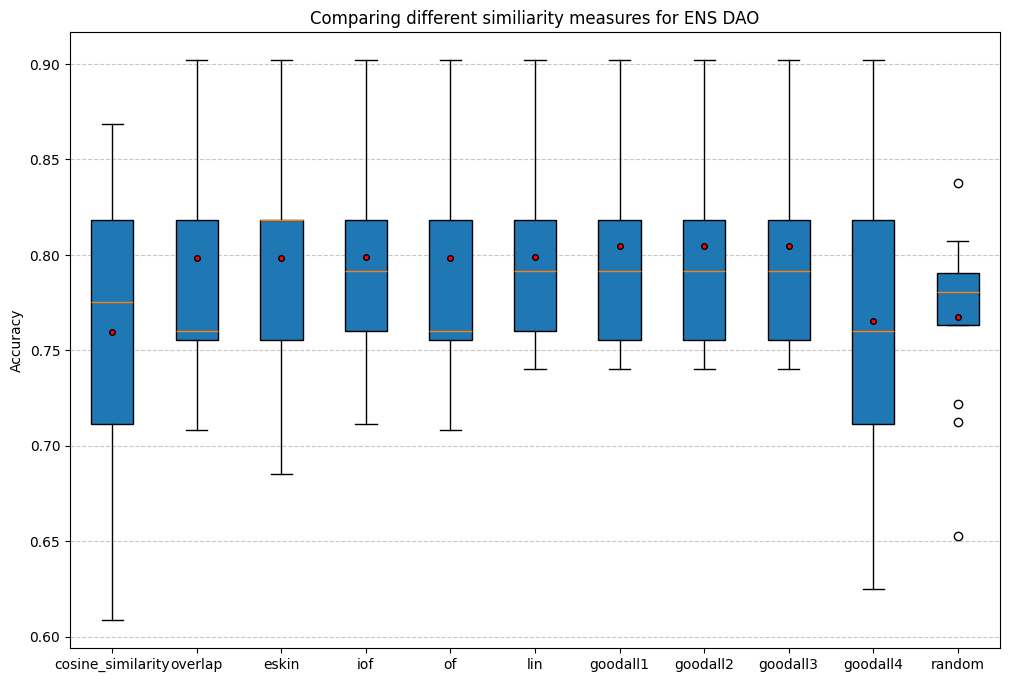

In [95]:
create_boxplots(non_cont_eval_result,"Comparing different similiarity measures for ENS DAO")

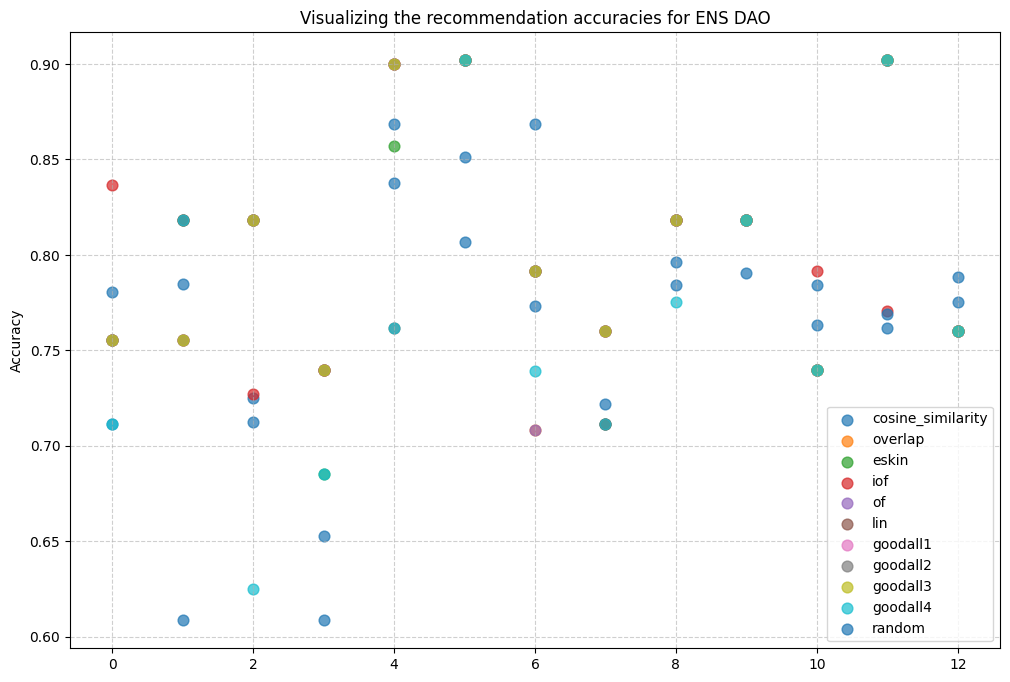

In [96]:
create_scatterplots(non_cont_eval_result,"Visualizing the recommendation accuracies for ENS DAO")

# Stargate DAO

## Getting proposal data

In [81]:
# getting proposals
query = gql("""
{
  proposals(
    first: 1000, 
    skip: 0, 
    where: { 
        space: "stgdao.eth"
    }, 
    orderBy: "created", 
    orderDirection: desc
) {
    id
    title
    start
    end
    state
    choices
    scores
    scores_total
    scores_updated
    author
    }
}
""")

#running the query
response = client.execute(query)
proposals = response['proposals']

# adding percentage scores to proposals
for i in range(len(proposals)):
    if proposals[i]['scores_total'] != 0:
        proposals[i]['percentage_scores'] = [proposals[i]['scores'][j]/sum(proposals[i]['scores']) for j in range(len(proposals[i]['scores']))]
    else:
        proposals[i]['percentage_scores'] = [0 for _ in range(len(proposals[i]['scores']))]

# converting to dataframe
proposals_df = pd.DataFrame(proposals)
proposals_df.head()

,id,title,start,end,state,choices,scores,scores_total,scores_updated,author,percentage_scores
0,0xf5516dd3c7c19d3182431ebac9af33abffdcba74a344...,LayerZero Proposes Acquisition of Stargate (STG),1755390269,1755994500,active,"[For, Against]","[7156260.528299162, 397861.6961044414]",7.554122e+06,1755887586,0xAcC884e01f6ed18E7313a0c480B389ffCD15e6e5,"[0.9473318428951084, 0.0526681571048915]"
1,0xfe2a457fd2cbb45ff1afaf6e3681489f4ab96be6c28b...,Migrate Stargate Protocol Contracts to OneSig,1754713947,1754973147,closed,"[For, Against]","[4637549.719956709, 27460.49923761073]",4.665010e+06,1754973207,0xAcC884e01f6ed18E7313a0c480B389ffCD15e6e5,"[0.9941135178815634, 0.005886482118436463]"
2,0x6bfcf5f666d9e11951aef8a9e46f6416e8eb8b56b994...,Stargate Finance Stablecoin Staking Yield Event,1754005231,1754264431,closed,"[For, Against]","[0, 39.47225120598709]",3.947225e+01,1754281135,0xA6553573f4A2f4bCcaCFf6cB7f743D4f50Ef91AD,"[0.0, 1.0]"
3,0xcb6cf828878e7286a146543790de8e836320b1f65166...,StargateDAO Capital Allocation to Intent Based...,1753721752,1753980952,closed,"[For, Against]","[2125820.760615496, 2725.463034719333]",2.128546e+06,1753981012,0x5A173642E34bc680AC3072c18E372a3f5D4c206F,"[0.9987195659627042, 0.0012804340372958747]"
4,0xd92078d4f940d07aebdf1af8c11f5dd288b1b89c62ab...,[Ratification] ETH and USDC pools on Cronos zkEVM,1753553172,1753812372,closed,"[For, Against]","[1440498.7439195723, 2890043.3509778297]",4.330542e+06,1753812433,0xAcC884e01f6ed18E7313a0c480B389ffCD15e6e5,"[0.33263704920843173, 0.6673629507915682]"


In [5]:
# deleting rows with zero engagement
proposals_df = proposals_df[proposals_df['scores_total'] != 0]

In [6]:
# saving proposals as json
proposals_df.to_json('snapshot_proposals_stargate.json', orient='records', indent=4)

In [7]:
# identify proposals with high disasgreement
for row in proposals_df.itertuples():
    if max(row.percentage_scores) < 0.9:
        index = np.argmax(row.percentage_scores)
        print(row.choices[index],round(row.percentage_scores[index],3))

For 0.882
Against 0.667
Against 0.737
Abstain 0.595
For 0.857
For 0.765
For 0.847
Against 0.619
Yes 0.622
Option 1 (Stables) 0.594
For 0.88
Artemis 0.653
Approve Stargate v2 on Core. 0.898
For 0.618
Yes 0.83
Eligible 0.897
Eligible 0.861
Eligible 0.796
Eligible 0.841
Yes 0.603
Yes 0.67
Yes 0.879
Yes 0.883
Yes 0.707
Yes 0.693
Yes 0.688
Yes 0.68
Do Not Complete The Transaction 0.504
Yes 0.513
Yes 0.612
Yes 0.736


In [8]:
#defining contreversial proposals
mask = proposals_df['percentage_scores'].apply(lambda scores: max(scores) < 0.7)
contreversial_proposals = proposals_df[mask]
print(contreversial_proposals['percentage_scores'].shape)

(15,)


## Getting voter data

In [19]:
# getting votes for each proposal
# voting_data = []
ctr = 0
for proposal in proposals:
    print(ctr)
    if ctr <= 92:
       ctr +=1
       continue
    
    votes_for_proposal = fetch_votes(proposal['id'])
    for vote in votes_for_proposal:
        vote['proposal_id'] = proposal['id']
        voting_data.append(vote)
    ctr+=1
    print(len(voting_data))
voting_df = pd.DataFrame(voting_data)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
VP =  239.02331863356838
VP =  90.46784590032934
VP =  53.68582038986238
VP =  41.9199373294723
VP =  34.286024074353115
VP =  31.1078840583532
VP =  29.550541675576103
VP =  28.561518496796573
VP =  27.827795366129596
VP =  27.24289936761984
2080916
94
VP =  255.40773222133615
VP =  94.20640593812165
VP =  59.36238105760984
VP =  45.364771865735065
VP =  36.39215160670522
VP =  32.113024326897026
VP =  30.144164711887168
VP =  29.050242179955
VP =  28.35620719674571
VP =  27.790319951744515
2134916
95
VP =  250.82635578927062
VP =  94.01062615206409
VP =  59.012789247024955
VP =  45.136803705786356
VP =  36.12907845924721
VP =  31.977701542106217
VP =  30.09305253566143
VP =  29.00877241236165
VP =  28.320537110948703

In [22]:
# saving voter data
voting_df.to_json('all_votes_snapshot_stargate.json', orient='records', indent=4) 

In [24]:
# exploring types of proposals
proposals_categories = {'approval': 0,"weighted": 0, "single_choice":0}
prev_prop = None
for row in voting_df.itertuples():
    curr_prop = row.proposal_id
    if curr_prop != prev_prop:
        prev_prop = curr_prop
        if curr_prop in list(contreversial_proposals['id']):
            if isinstance(row.choice,int):
                proposals_categories['single_choice'] += 1
            elif isinstance(row.choice,dict):
                proposals_categories['weighted'] += 1
            elif isinstance(row.choice, list):
                proposals_categories['approval'] += 1

            else:
                raise ValueError
    else:
        continue

print(proposals_categories)

{'approval': 0, 'weighted': 0, 'single_choice': 15}


## Getting participation stats of delegates

In [25]:
# setting participation value
voting_df['participated'] = 1

# creating voter proposal matrix
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='participated',
    fill_value=0
)

In [26]:
voter_proposal_matrix.shape

(410774, 155)

In [27]:
#getting participation rate
participation_rate = voter_proposal_matrix.sum(axis=1) / voter_proposal_matrix.shape[1]

In [36]:
active_delegates = voter_proposal_matrix[participation_rate >= 0.5]
active_delegates.shape

(414, 155)

## Creating optimal training dataset

In [37]:
# getting votes for controversial proposal as basis for training set
voting_df = voting_df[voting_df.proposal_id.isin(contreversial_proposals.id)]

In [38]:
# setting participation value
voting_df['participated'] = 1

# creating voter proposal matrix
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='participated',
    fill_value=0
)

voter_proposal_matrix.shape

(216859, 15)

In [50]:
recommendation_dataset = build_dataset(voter_proposal_matrix,1,15)
print(recommendation_dataset.shape)
recommendation_dataset

count    216859.000000
mean          2.522090
std           1.819648
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          15.000000
Name: voter_participation, dtype: float64
(26, 16)


proposal_id,0x1007f3e7e228cb432a861565a127da4d8c4a5476dddbb0eb088e44b4ea9c2449,0x331603498dd2beb9d9f8ff960a0d7d8fb902783b9ae15a6012086451e49acfb1,0x39f95f69921626e2100df0d85e0ea77eb554796d79f6978e828f93a860242b99,0x4218ee725798f5450583c29e20fa231c782b9f6880ef9170229235e9eb0442ef,0x45de70585d306879ea79de956ab5d136acd03b97d458ef03f09d61a05f1bf91f,0x57dfc29fe901e154f294e9e5fc6f7b26e58e4f9446d2d131168bb4531bd2a448,0x756e42595e5d9599dde8a9c1e01102cfe7ec6e8dfb1732320236b5f30a049a14,0x8205b6190c68ca1bfe9641335af365e749636d4d7254d83a62ab0e992c09bb65,0x8ca03295d142b8ed1dc55adffdaec3bd24d4a9613a44c1aa983907f3dab5ec9d,0x8d8cebd08408ab6072b9d8701c8b8eb0d53dcc5147ce97d1462d87ed6c547bab,0x9f220b762e40e2fc8166b15e64510a0843bb8328f48d1407a800ae1a63f577fd,0xac174c9bb4f7591f4ace0e8a084e28df7a0c4f9654274c08610f7ec262eed9e3,0xd78c441994d140edde34131051113479651c593ab83badebc537a347ba86b705,0xd92078d4f940d07aebdf1af8c11f5dd288b1b89c62abeb3a7187377b1843e0a1,0xf7b3318b9aed0e20bd550204a25420afc358ce4dd4a4c71d94e4c32efdf52ce1,voter_participation
0xf0FA01501bB9ec23abdaFD69DCA839dd5BB545df,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0
0xFbc891b2453775134b5aFeC38Ab2ce5Cec05d8BE,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0
0xf8Ec5f304E784017b0f47987d3f509a13eCd44fE,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0
0x3D3F817f3083eb0046489D6868E32507f8d8423d,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0
0x977a1078B9Aa5cf99c8b5531F2Efb39a91f7d6D6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0
0xECd9d97C55f7E170fff2a72C6E9a0eBecdf7E9cC,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0
0xbed9Aa3EdC2a6EE40b921b5A5083ee1fB261Df08,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0
0x08F7Fd04e76daC7e4d9e343e0B5510379f5bbA48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0
0xb150c9bEd10a8C62997d58a81c4e1fA75160643e,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0
0xC49a7D4f6DB416011530d5a047Db26B036c51328,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0


In [51]:
recommendation_dataset = recommendation_dataset.drop('voter_participation', axis = 1)

In [54]:
proposal_choices_dict = contreversial_proposals.set_index('id')['choices'].to_dict()
voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice_value',
    aggfunc='first',
    fill_value="NaN"
)
recommendation_dataset_matrix = voter_proposal_matrix.loc[voter_proposal_matrix.index.isin(recommendation_dataset.index)]
recommendation_dataset_matrix = recommendation_dataset_matrix.drop([col for col in recommendation_dataset_matrix.columns if col not in recommendation_dataset.columns], axis = 1)
recommendation_dataset_matrix[recommendation_dataset_matrix.columns] = recommendation_dataset_matrix[recommendation_dataset_matrix.columns].astype(int)
recommendation_dataset_matrix

proposal_id,0x1007f3e7e228cb432a861565a127da4d8c4a5476dddbb0eb088e44b4ea9c2449,0x331603498dd2beb9d9f8ff960a0d7d8fb902783b9ae15a6012086451e49acfb1,0x39f95f69921626e2100df0d85e0ea77eb554796d79f6978e828f93a860242b99,0x4218ee725798f5450583c29e20fa231c782b9f6880ef9170229235e9eb0442ef,0x45de70585d306879ea79de956ab5d136acd03b97d458ef03f09d61a05f1bf91f,0x57dfc29fe901e154f294e9e5fc6f7b26e58e4f9446d2d131168bb4531bd2a448,0x756e42595e5d9599dde8a9c1e01102cfe7ec6e8dfb1732320236b5f30a049a14,0x8205b6190c68ca1bfe9641335af365e749636d4d7254d83a62ab0e992c09bb65,0x8ca03295d142b8ed1dc55adffdaec3bd24d4a9613a44c1aa983907f3dab5ec9d,0x8d8cebd08408ab6072b9d8701c8b8eb0d53dcc5147ce97d1462d87ed6c547bab,0x9f220b762e40e2fc8166b15e64510a0843bb8328f48d1407a800ae1a63f577fd,0xac174c9bb4f7591f4ace0e8a084e28df7a0c4f9654274c08610f7ec262eed9e3,0xd78c441994d140edde34131051113479651c593ab83badebc537a347ba86b705,0xd92078d4f940d07aebdf1af8c11f5dd288b1b89c62abeb3a7187377b1843e0a1,0xf7b3318b9aed0e20bd550204a25420afc358ce4dd4a4c71d94e4c32efdf52ce1
voter,,,,,,,,,,,,,,,
0x08F7Fd04e76daC7e4d9e343e0B5510379f5bbA48,1,1,1,1,1,1,2,1,1,1,1,1,2,1,3
0x3D3F817f3083eb0046489D6868E32507f8d8423d,1,2,1,2,1,1,2,1,1,1,1,3,1,1,1
0x4166687A150DbA40f5b3E489D3728e16A111b7E0,1,2,1,2,1,1,1,1,1,1,1,1,1,1,1
0x4288253A9f9B7812df7e96247d460c6A8F2B47CE,1,1,1,1,1,1,2,3,1,1,1,1,1,2,1
0x4642938C939176b0a3abE0B0C59cc003782977eB,1,2,1,2,1,1,2,1,1,1,1,1,1,1,2
0x499CbeAB7209A5E794D817D3166630768b4aBa42,1,2,1,1,1,1,2,1,1,1,1,1,1,1,1
0x4d9Ba778B7f121e58E5d3BB6aef514e035A7c7F5,1,2,1,2,1,1,2,1,1,1,1,1,1,1,1
0x56f00611Db4070E35ecC46E1F01670DEfc7A5531,1,1,1,1,1,1,2,1,1,1,1,1,1,2,1
0x5d346F55DF93d578B207ADEC5Cb820F15eC708d3,1,1,1,1,1,1,1,3,1,1,1,1,1,2,1


In [55]:
# saving recommendation_dataset_matrix into json
recommendation_dataset_matrix.to_json('recommendation_dataset_matrix_stargate.json', orient='table', indent=4)

In [56]:
# evaluating behavior for active delegates in these proposals
proposals = list(recommendation_dataset_matrix.columns)
for prop in proposals:
    prop_voting_data = list(recommendation_dataset_matrix[prop])
    voter_behaviour = {}
    for vote in prop_voting_data:
        if vote in voter_behaviour.keys():
            voter_behaviour[vote] += 1
        else:
            voter_behaviour[vote] = 1
    stats = round(max(voter_behaviour.values())/sum(voter_behaviour.values()),2)
    print('agreement rate for prop: ', prop, ' = ',stats)
    # print(voter_behaviour)

agreement rate for prop:  0x1007f3e7e228cb432a861565a127da4d8c4a5476dddbb0eb088e44b4ea9c2449  =  0.96
agreement rate for prop:  0x331603498dd2beb9d9f8ff960a0d7d8fb902783b9ae15a6012086451e49acfb1  =  0.58
agreement rate for prop:  0x39f95f69921626e2100df0d85e0ea77eb554796d79f6978e828f93a860242b99  =  0.88
agreement rate for prop:  0x4218ee725798f5450583c29e20fa231c782b9f6880ef9170229235e9eb0442ef  =  0.65
agreement rate for prop:  0x45de70585d306879ea79de956ab5d136acd03b97d458ef03f09d61a05f1bf91f  =  1.0
agreement rate for prop:  0x57dfc29fe901e154f294e9e5fc6f7b26e58e4f9446d2d131168bb4531bd2a448  =  0.96
agreement rate for prop:  0x756e42595e5d9599dde8a9c1e01102cfe7ec6e8dfb1732320236b5f30a049a14  =  0.81
agreement rate for prop:  0x8205b6190c68ca1bfe9641335af365e749636d4d7254d83a62ab0e992c09bb65  =  0.73
agreement rate for prop:  0x8ca03295d142b8ed1dc55adffdaec3bd24d4a9613a44c1aa983907f3dab5ec9d  =  1.0
agreement rate for prop:  0x8d8cebd08408ab6072b9d8701c8b8eb0d53dcc5147ce97d1462d87ed

## Perfomring recommendation

In [97]:
recommendation_dataset = pd.read_json('recommendation_dataset_matrix_stargate.json', orient='table')

In [98]:
# calcualting agreement to filter training and validation sets
training_set = recommendation_dataset


In [99]:
choices = {}
for prop in training_set.columns:
    # getting choices
    query = gql(f"""
    {{
    proposals(
        first: 1000, 
        skip: 0, 
        where: {{ 
            space: "stgdao.eth",
            id: "{prop}"
        }}, 
        orderBy: "created", 
        orderDirection: desc
    ) {{
        choices
        }}
    }}
    """)
    #running the query
    response = client.execute(query)
    choices[prop] = response['proposals'][0]['choices']
print(choices)

{'0x1007f3e7e228cb432a861565a127da4d8c4a5476dddbb0eb088e44b4ea9c2449': ['For', 'Against'], '0x331603498dd2beb9d9f8ff960a0d7d8fb902783b9ae15a6012086451e49acfb1': ['For', 'Against'], '0x39f95f69921626e2100df0d85e0ea77eb554796d79f6978e828f93a860242b99': ['Yes', 'No', 'Abstain'], '0x4218ee725798f5450583c29e20fa231c782b9f6880ef9170229235e9eb0442ef': ['Complete The Transaction', 'Do Not Complete The Transaction'], '0x45de70585d306879ea79de956ab5d136acd03b97d458ef03f09d61a05f1bf91f': ['Yes', 'No'], '0x57dfc29fe901e154f294e9e5fc6f7b26e58e4f9446d2d131168bb4531bd2a448': ['Yes', 'No', 'Abstain'], '0x756e42595e5d9599dde8a9c1e01102cfe7ec6e8dfb1732320236b5f30a049a14': ['Option 1 (Stables)', 'Option 1 (STG)', 'Option 2 (Stables)', 'Option 2 (STG)'], '0x8205b6190c68ca1bfe9641335af365e749636d4d7254d83a62ab0e992c09bb65': ['For', 'Against', 'Abstain'], '0x8ca03295d142b8ed1dc55adffdaec3bd24d4a9613a44c1aa983907f3dab5ec9d': ['Yes', 'No', 'Abstain'], '0x8d8cebd08408ab6072b9d8701c8b8eb0d53dcc5147ce97d1462d87e

In [100]:
with open("all_votes_snapshot_stargate.json", "r") as f:
    data = json.load(f)
voting_df = pd.DataFrame(data).set_index("voter")
voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)
vp_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice_value',
    aggfunc='first',
    fill_value=np.nan
)
freq_dist = get_freq_dist_vp_matrix(training_set)

In [101]:
# building a new dict for vectorizing labels
vectorized_labels_mapping = {
    'Yes':1,
    'No': -1,
    'Abstain':0,
    'yes':1,
    'no':-1,
    'abstain':0,
    'Yes - Make them whole':1,
    "No - Rug 'em":-1,
    'Abstain - IDK':0,
    "Approve Update":1,
    'Decline Update':-1,
    'Yes - Incentivize balancing':1,
    'No - Leave it alone':-1,
    'Yes - support the amendment':1,
    'No - do not support amendment':-1,
    'Yes - Incentivize ':1,
    'No - Do Not Incentivize ':-1,
    'Update Emissions ':1,
    'No Change':-1,
    'Update Pathways':1,
    'No Update':-1
}

In [102]:
transformed_df = encode_labels(training_set,choices,vectorized_labels_mapping)

In [103]:
# performing the recommendation
recommended_delegates = {'cosine_similarity':[], 'overlap': [],'eskin': [],'iof':[], 'of': [], 'lin': [], 'goodall1': [], 'goodall2': [], 'goodall3': [], 'goodall4': []}
for voter_id in training_set.index:
    # storing results of cosine similiarity
    top_delegate = recommend_delegates(voter_id,transformed_df,"cosine_similarity",freq_dist).iloc[0,0]
    recommended_delegates['cosine_similarity'].append((voter_id,top_delegate))
    #storing overlap distance
    top_delegate = recommend_delegates(voter_id,training_set,"overlap",freq_dist).iloc[0,0]
    recommended_delegates['overlap'].append((voter_id,top_delegate))
    #storing results for eskin
    top_delegate = recommend_delegates(voter_id,training_set,"eskin",freq_dist).iloc[0,0]
    recommended_delegates['eskin'].append((voter_id,top_delegate))
    #storing results for iof
    top_delegate = recommend_delegates(voter_id,training_set,"iof",freq_dist).iloc[0,0]
    recommended_delegates['iof'].append((voter_id,top_delegate))
    #storing results for of
    top_delegate = recommend_delegates(voter_id,training_set,"of",freq_dist).iloc[0,0]
    recommended_delegates['of'].append((voter_id,top_delegate))
    #storing results for lin
    top_delegate = recommend_delegates(voter_id,training_set,"lin",freq_dist).iloc[0,0]
    recommended_delegates['lin'].append((voter_id,top_delegate))
    #storing results for goodall1
    top_delegate = recommend_delegates(voter_id,training_set,"goodall1",freq_dist).iloc[0,0]
    recommended_delegates['goodall1'].append((voter_id,top_delegate))
    #storing results for goodall2
    top_delegate = recommend_delegates(voter_id,training_set,"goodall2",freq_dist).iloc[0,0]
    recommended_delegates['goodall2'].append((voter_id,top_delegate))
    #storing results for goodall3
    top_delegate = recommend_delegates(voter_id,training_set,"goodall3",freq_dist).iloc[0,0]
    recommended_delegates['goodall3'].append((voter_id,top_delegate))
    #storing results for goodall4
    top_delegate = recommend_delegates(voter_id,training_set,"goodall4",freq_dist).iloc[0,0]
    recommended_delegates['goodall4'].append((voter_id,top_delegate))

## Evaluating on non contreversial proposals

In [104]:
# getting voting data for non controversial proposals
with open("all_votes_snapshot_stargate.json", "r") as f:
    data = json.load(f)
voting_df = pd.DataFrame(data)
voting_df = voting_df[~voting_df.proposal_id.isin(recommendation_dataset.columns)]
voting_df = voting_df[voting_df.voter.isin(recommendation_dataset.index)]

In [105]:
proposals = pd.read_json('snapshot_proposals_stargate.json', orient='records')

In [106]:
proposal_choices_dict = proposals.set_index('id')['choices'].to_dict()
voting_df['choice_value'] = voting_df.apply(map_choice_value, axis=1)
voter_proposal_matrix = voting_df.pivot_table(
    index='voter',
    columns='proposal_id',
    values='choice_value',
    aggfunc='first',
    fill_value=np.nan
)

In [107]:
voter_proposal_matrix

proposal_id,0x00b8f2f79d105b9c2da9a346a24ff7c9f1295d4760e11e93709d4e5f0165c2ef,0x04df8aafa123cf995b4ef28e0d28c4987ae09a41a4396235bd9c7368b05fdc80,0x0b0b40c3617bf0849c85cfd5902a992e6c9029f551362c068b0aaa1fc2c3d744,0x0dabcc487407cab6a0d471f7c61a01e9e4729ae7426957fece376939f2875aa6,0x108a9e597560c4f249cd8be23acd409059fcd17bb2290d69a550ac2232676e7d,0x11e9daab4e806cba220d5d6eae6be76f799f27ad20723d0aabedf0263ca2a28f,0x133468db5cd15d0b3622886ffc8dd8e2bdd8f94dfa8c70e5bf70b0b46d8ba472,0x13e489cc2b60e4b57876266b70e15d77d6ac86a23817dffba26043e69e3bf91e,0x13fad4320a30668d3f1badc53b911b5950ca465bdc37a2d113e527a43a1ab94e,0x1568deb7f61440b48a56e1c44e3d023852002e693fb3e58a085b5fb6f3134e98,...,0xef39ffb2c07e7b136b27831ef693dddccaba7517fb05e0243aacc45af660b476,0xf095ab5713a1a5052f264f6acda54690e921a276d8242c695c2394e9fe77ed85,0xf1274081c9f4db1db77f30f21b53f61dde8716f8d3f2aac7367709bd4af369b2,0xf3382953f8b018ee5e091275a637b7e33eea7f91bfc7a3f3e0aeeca742616dfc,0xf5516dd3c7c19d3182431ebac9af33abffdcba74a3440fdf851a96e58784d25c,0xf6235e1e4327a0490a561b11409e14f3526d624821cd301eaef4df5b7e704dcd,0xf980d6deed62c3d77dd055963724b9d07ea0f383a2142703e5581c8e751b06ad,0xfb862e6810019e8bf3282a1e06d2077edf28424bfc830562e56b91db0a70e861,0xfde5c822cec8720b374bfcaa89e69f0ee447df4dfb7e3c7272dc78f378a3b01d,0xfe2a457fd2cbb45ff1afaf6e3681489f4ab96be6c28becd1adaf758621e4ff98
voter,,,,,,,,,,,,,,,,,,,,,
0x08F7Fd04e76daC7e4d9e343e0B5510379f5bbA48,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0
0x3D3F817f3083eb0046489D6868E32507f8d8423d,1.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0
0x4166687A150DbA40f5b3E489D3728e16A111b7E0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0
0x4288253A9f9B7812df7e96247d460c6A8F2B47CE,1.0,NaN,NaN,1.0,1.0,1.0,NaN,1.0,1.0,NaN,...,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0
0x4642938C939176b0a3abE0B0C59cc003782977eB,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0x499CbeAB7209A5E794D817D3166630768b4aBa42,1.0,1.0,NaN,1.0,1.0,1.0,2.0,NaN,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
0x4d9Ba778B7f121e58E5d3BB6aef514e035A7c7F5,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,2.0
0x56f00611Db4070E35ecC46E1F01670DEfc7A5531,1.0,NaN,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,...,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0
0x5d346F55DF93d578B207ADEC5Cb820F15eC708d3,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN


In [109]:
# performing evaluation
non_cont_eval_result = {'cosine_similarity':[], 'overlap': [], 'eskin': [],'iof':[], 'of': [], 'lin': [], 'goodall1': [], 'goodall2': [], 'goodall3': [], 'goodall4': [], "random":[]}
# get number of evaluation points
eval_points = len(recommended_delegates['cosine_similarity'])
for i in range(eval_points):
    # evaluating cosine similiarity
    non_cont_eval_result['cosine_similarity'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'cosine_similarity',i))

    # evaluating overlap similiarity
    non_cont_eval_result['overlap'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'overlap',i))

    # evaluating eskin similiarity
    non_cont_eval_result['eskin'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'eskin',i))

    # evaluating iof similiarity
    non_cont_eval_result['iof'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'iof',i))

    # evaluating of similiarity
    non_cont_eval_result['of'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'of',i))

    # evaluating lin similiarity
    non_cont_eval_result['lin'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'lin',i))

    # evaluating goodall1 similiarity
    non_cont_eval_result['goodall1'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall1',i))

    # evaluating goodall2 similiarity
    non_cont_eval_result['goodall2'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall2',i))

    # evaluating goodall3 similiarity
    non_cont_eval_result['goodall3'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall3',i))

    # evaluating goodall4 similiarity
    non_cont_eval_result['goodall4'].append(get_accuracy_for_metric(voter_proposal_matrix,recommended_delegates,'goodall4',i))

    # evaluating random delegation (baseline)
    baseline_for_voter = []
    for possible_delegate in voter_proposal_matrix.drop(recommended_delegates['overlap'][i][0]).index:
        common_proposals = filter_common_proposals(voter_proposal_matrix.loc[recommended_delegates['overlap'][i][0]],voter_proposal_matrix.loc[possible_delegate])
        if common_proposals:
            same_votes = [prop for prop in common_proposals if voter_proposal_matrix.loc[recommended_delegates['overlap'][i][0]][prop] == voter_proposal_matrix.loc[possible_delegate][prop]]
            baseline_for_voter.append(len(same_votes)/len(common_proposals))
    non_cont_eval_result['random'].append(sum(baseline_for_voter)/len(baseline_for_voter))

In [110]:
# Printing out stats
print("Cosine Similarity")
print(pd.Series(non_cont_eval_result['cosine_similarity']).describe())
print()
print("Overlap Similarity")
print(pd.Series(non_cont_eval_result['overlap']).describe())
print()
print("Eskin")
print(pd.Series(non_cont_eval_result['eskin']).describe())
print()
print("iof")
print(pd.Series(non_cont_eval_result['iof']).describe())
print()
print("of")
print(pd.Series(non_cont_eval_result['of']).describe())
print()
print("lin")
print(pd.Series(non_cont_eval_result['lin']).describe())
print()
print("goodall1")
print(pd.Series(non_cont_eval_result['goodall1']).describe())
print()
print("goodall2")
print(pd.Series(non_cont_eval_result['goodall2']).describe())
print()
print("goodall3")
print(pd.Series(non_cont_eval_result['goodall3']).describe())
print()
print("goodall4")
print(pd.Series(non_cont_eval_result['goodall4']).describe())
print()
print("Random Delegation (Baseline)")
print(pd.Series(non_cont_eval_result['random']).describe())

Cosine Similarity
count    26.000000
mean      0.970163
std       0.034664
min       0.836957
25%       0.959954
50%       0.977138
75%       0.996835
max       1.000000
dtype: float64

Overlap Similarity
count    26.000000
mean      0.972283
std       0.025764
min       0.884615
25%       0.966803
50%       0.983609
75%       0.986486
max       1.000000
dtype: float64

Eskin
count    26.000000
mean      0.968513
std       0.031037
min       0.884615
25%       0.966386
50%       0.979708
75%       0.986486
max       1.000000
dtype: float64

iof
count    26.000000
mean      0.965626
std       0.031956
min       0.884615
25%       0.952502
50%       0.982143
75%       0.986486
max       1.000000
dtype: float64

of
count    26.000000
mean      0.970936
std       0.024718
min       0.884615
25%       0.966803
50%       0.982143
75%       0.986486
max       0.988506
dtype: float64

lin
count    26.000000
mean      0.969719
std       0.034795
min       0.836957
25%       0.973333
50%       0

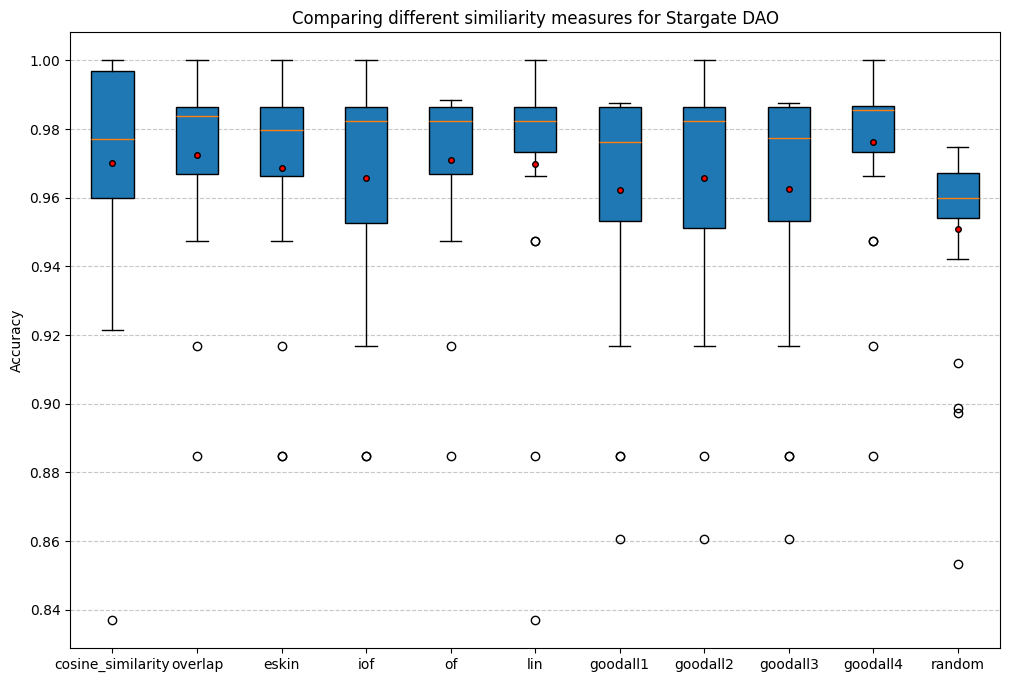

In [111]:
create_boxplots(non_cont_eval_result,"Comparing different similiarity measures for Stargate DAO")

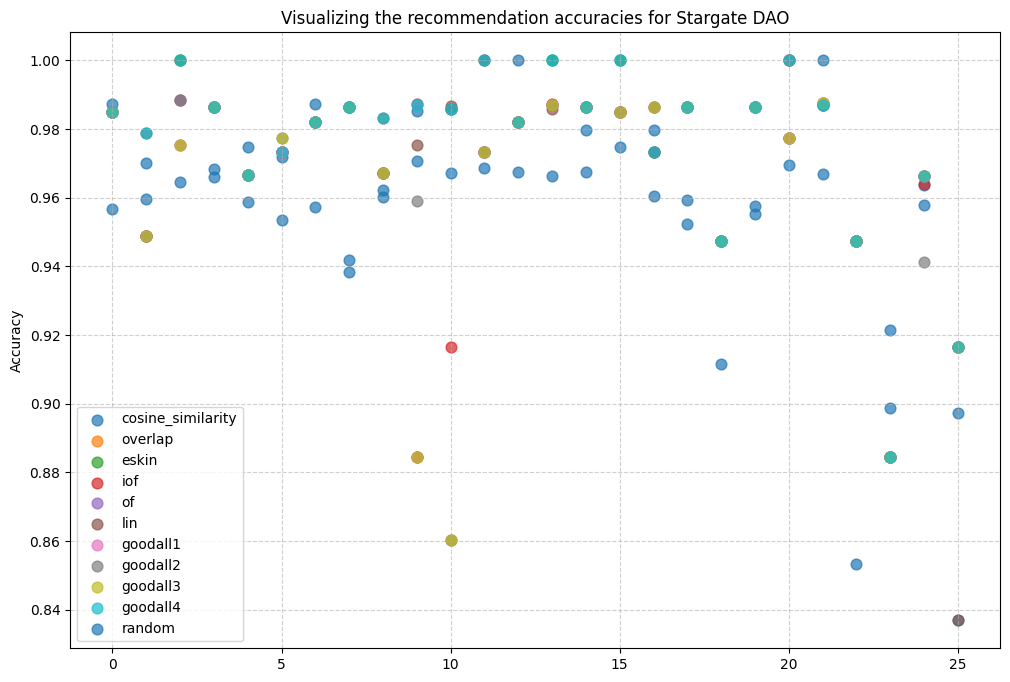

In [112]:
create_scatterplots(non_cont_eval_result,"Visualizing the recommendation accuracies for Stargate DAO")